In [2]:
%matplotlib inline

In [3]:
#import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
#from cv2 import VideoWriter, VideoWriter_fourcc
import pandas as pd
import torch
from scipy import signal, ndimage, spatial
from scipy.signal import correlate
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter
import math 

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, auc

from scipy.interpolate import interp1d
import scipy.stats as stats
from scipy.stats import spearmanr
import seaborn as sns


## Read the SLP Scores 

In [4]:
### LINUX BOX PATH
#path = r'/home/deniz/Code/ClinicalScoreProject/NeuroFace_Dataset/ALS/SLP_Assessment_ALS.csv'


# ALS DATA
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/ALS/SLP_Assessment_ALS.csv'
df_als = pd.read_csv(path)

df_als = df_als.drop('Unnamed: 8', axis=1)

#print(df_als.shape)
#print(df_als.columns)
#print(df_als['Subject ID'].unique())
#df_als.head()

# STROKE DATA
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/Stroke/SLP_Assessment_PS.csv'
df_ps = pd.read_csv(path)

df_ps = df_ps.drop('Unnamed: 8', axis=1)

#print(df_ps.shape)
#print(df_ps.columns)
#print(df_ps['Subject ID'].unique())
#df_ps.head()

# HEALTHY CONTROL DATA
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/Healthy controls/SLP_Assessment_HC.csv'
df_hc = pd.read_csv(path)

df_hc = df_hc.drop('Unnamed: 8', axis=1)
df_hc = df_hc.drop('Unnamed: 15', axis=1)
#print(df_hc.shape)
#print(df_hc.columns)
#print(df_hc['Subject ID'].unique())



slp_scores = pd.concat([df_als, df_ps, df_hc], ignore_index=True)
# average of the clinical scores 

slp_scores['Tot_avg'] = slp_scores.apply(lambda row: (row['Tot (SLP1)'] + row["Tot (SLP2)"])/2, axis=1)
slp_scores['Symmetry_avg'] = slp_scores.apply(lambda row: (row['Symmetry (SLP1)'] + row["Symmetry (SLP2)"])/2, axis=1)
slp_scores['ROM_avg'] = slp_scores.apply(lambda row: (row['ROM (SLP1)'] + row["ROM (SLP2)"])/2, axis=1)
slp_scores['Speed_avg'] = slp_scores.apply(lambda row: (row['Speed (SLP1)'] + row["Speed (SLP2)"])/2, axis=1)
slp_scores['Variability_avg'] = slp_scores.apply(lambda row: (row['Variability (SLP1)'] + row["Variability (SLP2)"])/2, axis=1)
slp_scores['Fatigue_avg'] = slp_scores.apply(lambda row: (row['Fatigue (SLP1)'] + row["Fatigue (SLP2)"])/2, axis=1)


tasks = ['BBP_NORMAL',  'PATAKA', 'PA','BLOW', 'KISS','NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE' ,'BROW']

ids = ['A', 'O', 'S', 'N']

def task_labeler(row):
    for t in tasks: 
        if t in row: 
            return t
        
def pop_labeler(row):
    for i in ids:
        if i in row:
            if i == "A":
                return 'ALS'
            elif i == 'O' or i == "S":
                return 'Stroke'
            else:
                return 'HC'
    

slp_scores['task'] = [task_labeler(x) for x in slp_scores['File Name']]
slp_scores['population'] = [pop_labeler(x) for x in slp_scores['Subject ID']]

print(slp_scores.shape)
print(slp_scores.columns)
print()
print('Total numbr of participants are: ',len(slp_scores['Subject ID'].unique()))
print()
print('Subject IDs included are: ',slp_scores['Subject ID'].unique())
print()
print(slp_scores.columns)
print()
print('The tasks are: ', slp_scores['task'].unique())

slp_scores.head()



(261, 22)
Index(['File Name', 'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)',
       'Speed (SLP1)', 'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)',
       'Symmetry (SLP2)', 'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)',
       'Fatigue (SLP2)', 'Tot (SLP2)', 'Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg', 'task', 'population'],
      dtype='object')

Total numbr of participants are:  36

Subject IDs included are:  ['A002' 'A006' 'A008' 'A009' 'A010' 'A011' 'A012' 'A014' 'A015' 'A016'
 'A017' 'OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007'
 'S008' 'S009' 'S011' 'S012' 'S013' 'N001' 'N002' 'N003' 'N004' 'N007'
 'N008' 'N010' 'N011' 'N012' 'N017' 'N019']

Index(['File Name', 'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)',
       'Speed (SLP1)', 'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)',
       'Symmetry (SLP2)', 'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)',
       'Fatigue (SLP2)', 'Tot (SLP2)', 'Tot_av

File Name Subject ID  Symmetry (SLP1)  ROM (SLP1)  \
0  A002_02_BBP_NORMAL_color.avi       A002                1           1   
1  A002_02_DDK_PATAKA_color.avi       A002                1           1   
2      A002_02_DDK_PA_color.avi       A002                1           1   
3    A002_02_NSM_BLOW_color.avi       A002                2           1   
4    A002_02_NSM_KISS_color.avi       A002                2           1   

   Speed (SLP1)  Variability (SLP1)  Fatigue (SLP1)  Tot (SLP1)  \
0             1                   1               1           5   
1             1                   1               1           5   
2             1                   1               1           5   
3             1                   2               1           7   
4             1                   1               4           9   

   Symmetry (SLP2)  ROM (SLP2)  ...  Fatigue (SLP2)  Tot (SLP2)  Tot_avg  \
0                2           1  ...               1           6      5.5   
1                2           2  ...               2           9      7.0   
2                2           2  ...               2           9      7.0   
3                1           2  ...               1           8      7.5   
4                1           1  ...               3           7      8.0   

   Symmetry_avg  ROM_avg  Speed_avg  Variability_avg  Fatigue_avg        task  \
0           1.5      1.0        1.0              1.0          1.0  BBP_NORMAL   
1           1.5      1.5        1.0              1.5          1.5      PATAKA   
2           1.5      1.5        1.0              1.5          1.5          PA   
3           1.5      1.5        1.5              2.0          1.0        BLOW   
4           1.5      1.0        1.0              1.0          3.5        KISS   

   population  
0         ALS  
1         ALS  
2         ALS  
3         ALS  
4         ALS  

[5 rows x 22 columns]

In [5]:

print(df_als['Subject ID'].unique())
print(len(df_als['Subject ID'].unique()))

print(df_ps['Subject ID'].unique())
print(len(df_ps['Subject ID'].unique()))

print(df_hc['Subject ID'].unique())
print(len(df_hc['Subject ID'].unique()))



['A002' 'A006' 'A008' 'A009' 'A010' 'A011' 'A012' 'A014' 'A015' 'A016'
 'A017']
11
['OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007' 'S008'
 'S009' 'S011' 'S012' 'S013']
14
['N001' 'N002' 'N003' 'N004' 'N007' 'N008' 'N010' 'N011' 'N012' 'N017'
 'N019']
11


In [6]:
a = slp_scores.groupby(['population', 'task']).count()

slp_scores.groupby(['population','task'])['Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg'].describe()


<ipython-input-6-cbf6efbffae7>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  slp_scores.groupby(['population','task'])['Tot_avg', 'Symmetry_avg', 'ROM_avg',


Tot_avg                                          \
                          count       mean       std  min    25%    50%   
population task                                                           
ALS        BBP_NORMAL       9.0   7.611111  1.850300  5.5  6.000   7.00   
           BLOW             6.0   6.416667  0.801041  5.5  5.750   6.50   
           BROW             4.0   5.500000  0.408248  5.0  5.375   5.50   
           KISS            11.0   7.590909  2.467977  5.5  6.000   6.50   
           NSM_BIGSMILE     4.0   9.125000  1.750000  7.0  8.125   9.25   
           NSM_OPEN        11.0   6.363636  1.097518  5.0  5.500   6.50   
           NSM_SPREAD      11.0   9.590909  3.104981  6.0  7.500   8.50   
           PA              10.0   8.200000  1.960725  6.5  6.625   7.50   
           PATAKA          10.0   8.450000  1.423025  5.5  8.000   8.75   
HC         BBP_NORMAL      11.0   5.863636  0.595437  5.0  5.500   5.50   
           BLOW             7.0   5.785714  0.906327  5.0  5.000   6.00   
           BROW             4.0   5.625000  1.250000  5.0  5.000   5.00   
           KISS            11.0   5.772727  0.646670  5.0  5.500   5.50   
           NSM_BIGSMILE     3.0   6.500000  1.500000  5.0  5.750   6.50   
           NSM_OPEN        11.0   5.545455  0.522233  5.0  5.000   5.50   
           NSM_SPREAD      11.0   6.772727  2.078024  5.0  5.000   6.00   
           PA              11.0   5.590909  0.583874  5.0  5.000   5.50   
           PATAKA          11.0   5.863636  0.896965  5.0  5.000   5.50   
Stroke     BBP_NORMAL      14.0   9.107143  2.489814  5.0  7.500   9.00   
           BLOW            11.0   7.363636  2.025968  5.5  6.250   7.00   
           BROW             7.0   8.642857  3.543942  5.0  6.250   7.00   
           KISS            14.0   8.785714  2.599662  5.0  7.000   8.75   
           NSM_BIGSMILE     3.0   6.333333  1.154701  5.0  6.000   7.00   
           NSM_OPEN        14.0   6.892857  1.163195  5.0  6.500   6.50   
           NSM_SPREAD      14.0  10.750000  2.585090  6.0  9.500  10.00   
           PA              14.0   9.607143  2.482079  6.0  7.750   9.50   
           PATAKA          14.0   8.785714  2.100497  5.5  7.000   9.25   

                                      Symmetry_avg            ...  \
                            75%   max        count      mean  ...   
population task                                               ...   
ALS        BBP_NORMAL     9.000  11.0          9.0  1.833333  ...   
           BLOW           6.875   7.5          6.0  1.750000  ...   
           BROW           5.625   6.0          4.0  1.125000  ...   
           KISS           8.500  14.0         11.0  1.681818  ...   
           NSM_BIGSMILE  10.250  11.0          4.0  2.125000  ...   
           NSM_OPEN       7.000   8.5         11.0  1.590909  ...   
           NSM_SPREAD    11.500  15.0         11.0  1.772727  ...   
           PA             9.000  12.5         10.0  1.900000  ...   
           PATAKA         9.375  10.5         10.0  1.850000  ...   
HC         BBP_NORMAL     6.250   7.0         11.0  1.318182  ...   
           BLOW           6.000   7.5          7.0  1.357143  ...   
           BROW           5.625   7.5          4.0  1.125000  ...   
           KISS           6.250   7.0         11.0  1.272727  ...   
           NSM_BIGSMILE   7.250   8.0          3.0  1.500000  ...   
           NSM_OPEN       6.000   6.5         11.0  1.454545  ...   
           NSM_SPREAD     8.500  11.0         11.0  1.409091  ...   
           PA             6.000   6.5         11.0  1.227273  ...   
           PATAKA         6.500   7.5         11.0  1.363636  ...   
Stroke     BBP_NORMAL    10.500  13.5         14.0  2.571429  ...   
           BLOW           7.250  11.5         11.0  2.045455  ...   
           BROW          10.500  15.0          7.0  1.857143  ...   
           KISS           9.875  14.0         14.0  2.178571  ...   
           NSM_BIGSMILE   7.000   7.0          3

In [7]:
print(slp_scores.columns)
slp_scores.groupby(['population']).count()


Index(['File Name', 'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)',
       'Speed (SLP1)', 'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)',
       'Symmetry (SLP2)', 'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)',
       'Fatigue (SLP2)', 'Tot (SLP2)', 'Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg', 'task', 'population'],
      dtype='object')


File Name  Subject ID  Symmetry (SLP1)  ROM (SLP1)  Speed (SLP1)  \
population                                                                     
ALS                76          76               76          76            76   
HC                 80          80               80          80            80   
Stroke            105         105              105         105           105   

            Variability (SLP1)  Fatigue (SLP1)  Tot (SLP1)  Symmetry (SLP2)  \
population                                                                    
ALS                         76              76          76               76   
HC                          80              80          80               80   
Stroke                     105             105         105              105   

            ROM (SLP2)  ...  Variability (SLP2)  Fatigue (SLP2)  Tot (SLP2)  \
population              ...                                                   
ALS                 76  ...                  76              76          76   
HC                  80  ...                  80              80          80   
Stroke             105  ...                 105             105         105   

            Tot_avg  Symmetry_avg  ROM_avg  Speed_avg  Variability_avg  \
population                                                               
ALS              76            76       76         76               76   
HC               80            80       80         80               80   
Stroke          105           105      105        105              105   

            Fatigue_avg  task  
population                     
ALS                  76    76  
HC                   80    80  
Stroke              105   105  

[3 rows x 21 columns]

In [8]:
slp_scores = slp_scores.loc[(slp_scores['task'] == 'BBP_NORMAL') | (slp_scores['task'] == 'NSM_OPEN')| 
                              (slp_scores['task'] == 'NSM_SPREAD') | (slp_scores['task'] == 'NSM_BIGSMILE')|
                           (slp_scores['task'] == 'KISS') |(slp_scores['task'] == 'PA')]


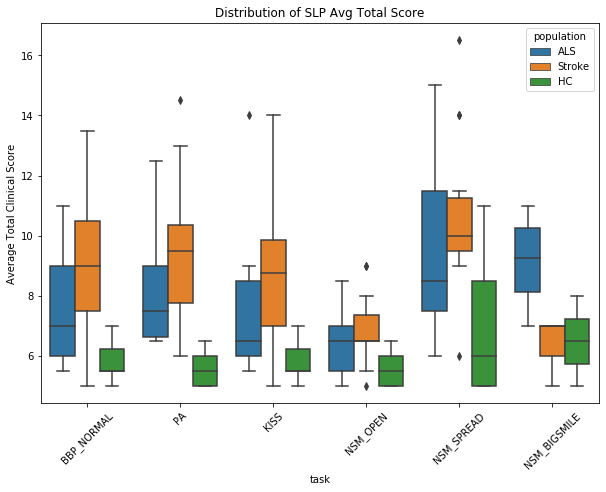

In [9]:
# Clinical Scores
ax, figure = plt.subplots(figsize=(10,7))
g = sns.boxplot(x='task', y='Tot_avg',data=slp_scores, hue='population')
plt.title('Distribution of SLP Total Score')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.ylabel('Average Total Clinical Score')
plt.title('Distribution of SLP Avg Total Score')

plt.show()

if 0:
    sns.boxplot(x=df['Subject ID'], y=df['Tot (SLP2)'])
    plt.title('Distribution of SLP2 Total Score')
    plt.show()

    sns.boxplot(x=df['Subject ID'], y=df['Tot_avg'])
    plt.title('Distribution of SLP Avg Total Score')
    plt.show()

In [69]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

#perform two-way ANOVA
#model = ols('height ~ C(water) + C(sun) + C(water):C(sun)', data=df).fit()
#sm.stats.anova_lm(model, typ=2)


ModuleNotFoundError: No module named 'statsmodels'

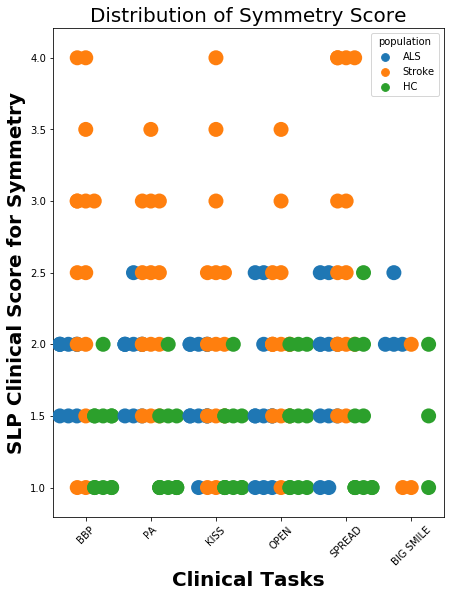

In [35]:
ax, figure = plt.subplots(figsize=(7,9))
#g = sns.boxplot(x='task', y='Symmetry_avg',data=slp_scores, hue='population')

slp_scores['task'].replace({'BBP_NORMAL':'BBP', 'NSM_BIGSMILE': 'BIG SMILE',
                            'NSM_SPREAD':'SPREAD','NSM_OPEN': 'OPEN'}, inplace=True)
g = sns.swarmplot(x='task', y='Symmetry_avg',data=slp_scores, hue='population', dodge=True,size=15)
plt.title('Distribution of SLP Total Score')
g.set_xticklabels(g.get_xticklabels(), rotation=45)


plt.xlabel('Clinical Tasks', fontsize = 20.0, fontweight="bold")
plt.ylabel('SLP Clinical Score for Symmetry', fontsize = 20.0, fontweight="bold")
plt.title('Distribution of Symmetry Score', fontsize = 20.0)
#plt.xticks(['BBP', 'PA', 'KISS', 'OPEN', 'SPREAD', 'BIG SMILE'])
#plt.xticks([2,3,4,5,6,7,8])

plt.savefig('sym', bbox_inches='tight')


plt.show()

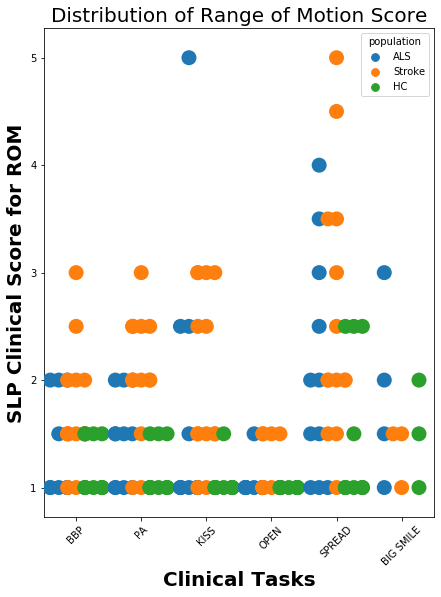

In [34]:
ax, figure = plt.subplots(figsize=(7,9))
#g = sns.boxplot(x='task', y='ROM_avg',data=slp_scores, hue='population')

g = sns.swarmplot(x='task', y='ROM_avg',data=slp_scores, hue='population', dodge=True,size=15)
#g = sns.swarmplot(x='task', y='ROM_avg',data=slp_scores, hue='population')

g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.xlabel('Clinical Tasks', fontsize = 20.0, fontweight="bold")
plt.ylabel('SLP Clinical Score for ROM',  fontsize = 20.0, fontweight="bold")
plt.title('Distribution of Range of Motion Score', fontsize = 20.0)





plt.savefig('rom', bbox_inches='tight')

plt.show()

TypeError: float() argument must be a string or a number, not 'AxesSubplot'

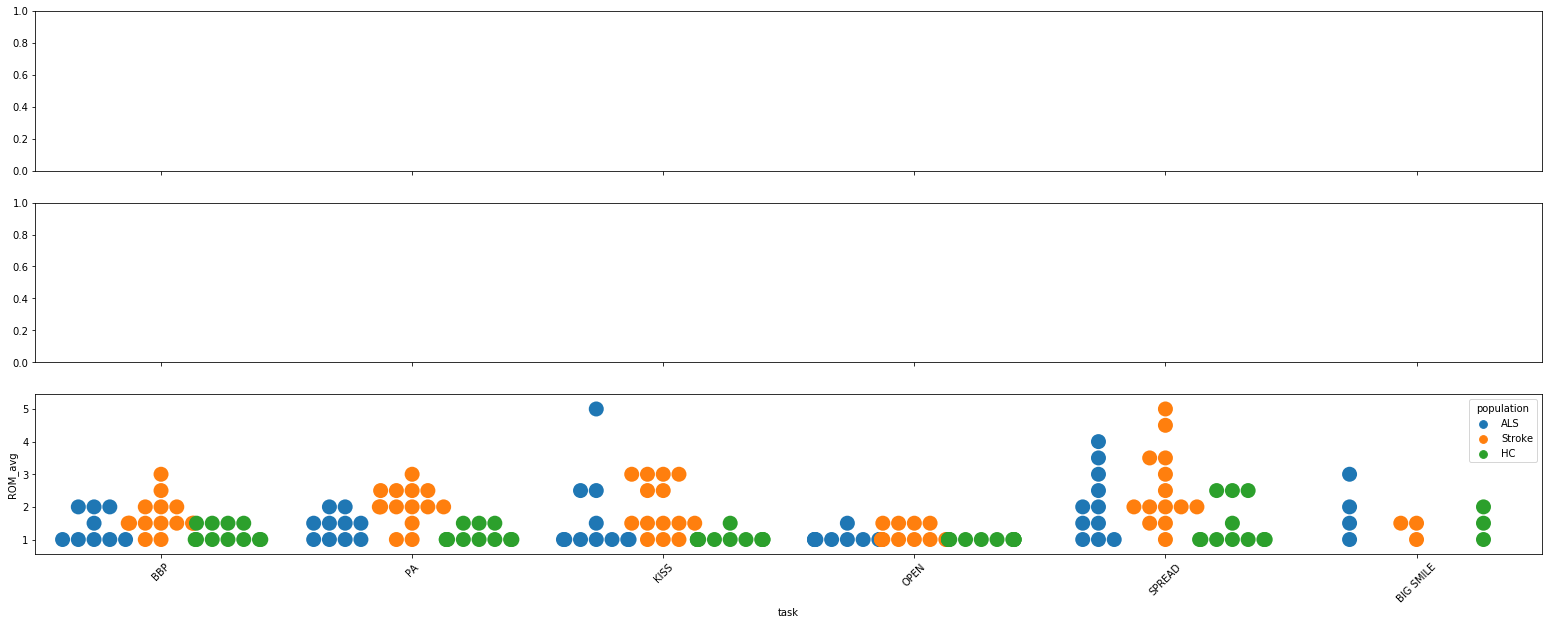

In [29]:

fig, axs = plt.subplots(3, figsize=(27,10),sharex=True)
#fig.suptitle('Horizontally stacked subplots')

#print(axs)


g = sns.swarmplot(x='task', y='ROM_avg',data=slp_scores, hue='population', dodge=True,size=15)
g.set_xticklabels(g.get_xticklabels(), rotation=45)

axs[0].plot(g)
axs[0].set_title('Distribution of SLP Avg Range of Motion Clinical Score')



g2 = sns.swarmplot(x='task', y='Speed_avg',data=slp_scores, hue='population', dodge=True,size=15)
g2.set_xticklabels(g.get_xticklabels(), rotation=45)


axs[1].plot(g2)
axs[1].set_title('Distribution of SLP Avg Speed Clinical Score')



g3 = sns.swarmplot(x='task', y='Symmetry_avg',data=slp_scores, hue='population', dodge=True,size=15)
plt.title('Distribution of SLP Total Score')
g3.set_xticklabels(g.get_xticklabels(), rotation=45)


axs[2].plot(g3)
axs[2].set_title('Distribution of SLP Avg Symmetry Clinical Score')



plt.xlabel('Clinical Tasks')
plt.ylabel('SLP Clinical Score')

#ax1.plot(g)
#ax2.plot(g2)
#ax3.plot(g3)
#ax2.plot(x, -y)

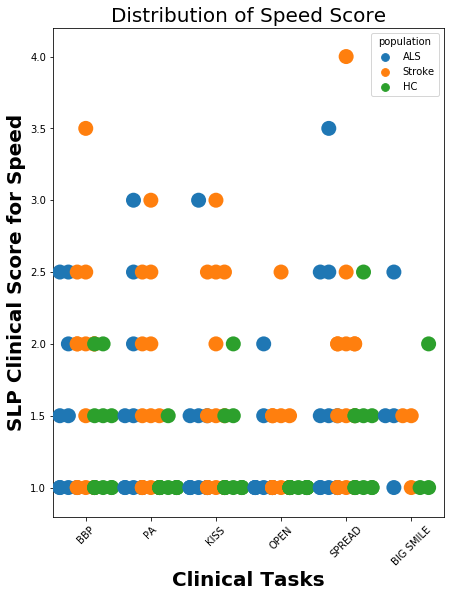

In [37]:
ax, figure = plt.subplots(figsize=(7,9))
#g = sns.boxplot(x='task', y='Speed_avg',data=slp_scores, hue='population')
g = sns.swarmplot(x='task', y='Speed_avg',data=slp_scores, hue='population', dodge=True,size=15)

#plt.title('Distribution of SLP Total Score')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.xlabel('Clinical Tasks', fontsize = 20.0, fontweight="bold")
plt.ylabel('SLP Clinical Score for Speed' ,fontsize = 20.0, fontweight="bold")
plt.title('Distribution of Speed Score', fontsize = 20.0)
plt.savefig('spd', bbox_inches='tight')

plt.show()

In [12]:
### Finding subjects for Symmetry validation 

slp_scores.loc[(slp_scores['Speed_avg'] >= 2.5) & (slp_scores['task'] == 'BBP_NORMAL')]

File Name Subject ID  Symmetry (SLP1)  ROM (SLP1)  \
21   A009_02_BBP_NORMAL_color.avi       A009                2           1   
28   A010_02_BBP_NORMAL_color.avi       A010                2           1   
76   OP01_02_BBP_NORMAL_color.avi       OP01                2           2   
107  S002_02_BBP_NORMAL_color.avi       S002                3           2   
173  S013_02_BBP_NORMAL_color.avi       S013                2           2   

     Speed (SLP1)  Variability (SLP1)  Fatigue (SLP1)  Tot (SLP1)  \
21              2                   2               2           9   
28              2                   1               1           7   
76              3                   2               2          11   
107             4                   4               1          14   
173             4                   1               1          10   

     Symmetry (SLP2)  ROM (SLP2)  ...  Fatigue (SLP2)  Tot (SLP2)  Tot_avg  \
21                 2           3  ...               3          13     11.0   
28                 2           2  ...               2          11      9.0   
76                 2           1  ...               1           7      9.0   
107                3           2  ...               1          13     13.5   
173                1           1  ...               1           5      7.5   

     Symmetry_avg  ROM_avg  Speed_avg  Variability_avg  Fatigue_avg  \
21            2.0      2.0        2.5              2.0          2.5   
28            2.0      1.5        2.5              1.5          1.5   
76            2.0      1.5        2.5              1.5          1.5   
107           3.0      2.0        3.5              4.0          1.0   
173           1.5      1.5        2.5              1.0          1.0   

           task  population  
21   BBP_NORMAL         ALS  
28   BBP_NORMAL         ALS  
76   BBP_NORMAL      Stroke  
107  BBP_NORMAL      Stroke  
173  BBP_NORMAL      Stroke  

[5 rows x 22 columns]

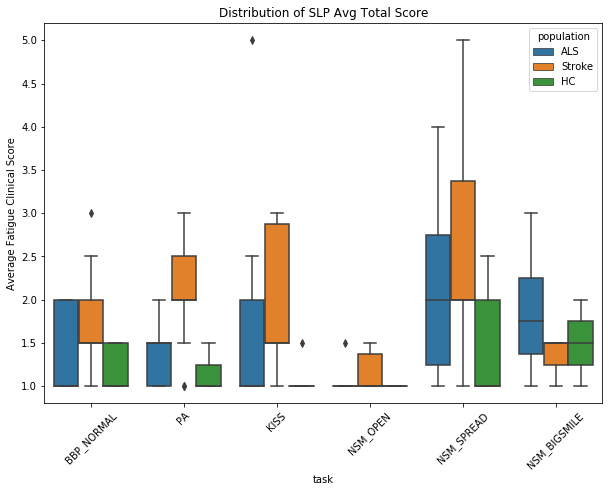

In [13]:
ax, figure = plt.subplots(figsize=(10,7))
g = sns.boxplot(x='task', y='ROM_avg',data=slp_scores, hue='population')
plt.title('Distribution of SLP Total Score')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.ylabel('Average Fatigue Clinical Score')
plt.title('Distribution of SLP Avg Total Score')

plt.show()

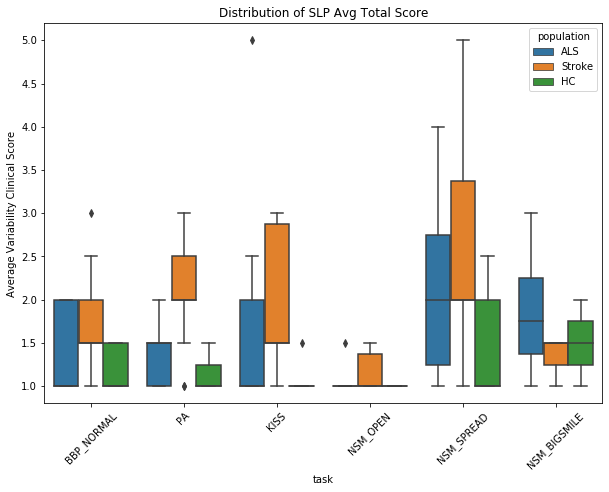

In [14]:
#ax, figure = plt.subplots(figsize=(10,7))
g = sns.boxplot(x='task', y='ROM_avg',data=slp_scores, hue='population')
plt.title('Distribution of SLP Total Score')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.ylabel('Clinical Tasks')
plt.ylabel('SLP Clinical Score for ROM')
plt.title('Distribution of SLP Avg Range of Motion Score')
plt.savefig('rom', bbox_inches='tight')
plt.show()

In [15]:
### Finding subjects for Symmetry validation 

slp_scores.loc[(slp_scores['ROM_avg'] >= 3) & ((slp_scores['task'] == 'NSM_SPREAD')|(slp_scores['task'] == 'BBP_NORMAL'))]

#slp_scores.loc[(slp_scores['ROM_avg'] == 1) & (slp_scores['task'] == 'BBP_NORMAL')]

## S1, S2, S3, S5, S6, S9 and S11 have high Symmetry scores for NSM_Spread 
## A006 and A009 
### Diego doesn't have S11, so we are going to look at S9
### S9 is RSSDK format 


#slp_scores.loc[(slp_scores['Symmetry_avg'] == 1) & (slp_scores['task'] == 'NSM_SPREAD')]

### NF8, NF7, NF11

File Name Subject ID  Symmetry (SLP1)  ROM (SLP1)  \
27   A009_02_NSM_SPREAD_color.avi       A009                2           3   
44   A012_02_NSM_SPREAD_color.avi       A012                1           4   
59   A015_02_NSM_SPREAD_color.avi       A015                1           2   
121  S005_02_BBP_NORMAL_color.avi       S005                4           3   
127  S005_02_NSM_SPREAD_color.avi       S005                4           3   
134  S006_02_NSM_SPREAD_color.avi       S006                3           5   
141  S007_02_NSM_SPREAD_color.avi       S007                3           3   
148  S008_02_NSM_SPREAD_color.avi       S008                2           4   
156  S009_02_NSM_SPREAD_color.avi       S009                4           2   

     Speed (SLP1)  Variability (SLP1)  Fatigue (SLP1)  Tot (SLP1)  \
27              2                   3               2          12   
44              3                   3               3          14   
59              2                   1               2           8   
121             2                   2               2          13   
127             2                   1               1          11   
134             4                   2               1          15   
141             2                   3               1          12   
148             2                   1               1          10   
156             2                   3               2          13   

     Symmetry (SLP2)  ROM (SLP2)  ...  Fatigue (SLP2)  Tot (SLP2)  Tot_avg  \
27                 3           4  ...               1          15     13.5   
44                 1           4  ...               1          14     14.0   
59                 2           4  ...               1          10      9.0   
121                4           3  ...               2          12     12.5   
127                4           4  ...               1          12     11.5   
134                5           5  ...               1          18     16.5   
141                1           4  ...               1           9     10.5   
148                2           5  ...               1          11     10.5   
156                4           4  ...               3          15     14.0   

     Symmetry_avg  ROM_avg  Speed_avg  Variability_avg  Fatigue_avg  \
27            2.5      3.5        2.5              3.5          1.5   
44            1.0      4.0        3.5              3.5          2.0   
59            1.5      3.0        1.5              1.5          1.5   
121           4.0      3.0        1.5              2.0          2.0   
127           4.0      3.5        2.0              1.0          1.0   
134           4.0      5.0        4.0              2.5          1.0   
141           2.0      3.5        2.0              2.0          1.0   
148           2.0      4.5        2.0              1.0          1.0   
156           4.0      3.0        2.0              2.5          2.5   

           task  population  
27   NSM_SPREAD         ALS  
44   NSM_SPREAD         ALS  
59   NSM_SPREAD         ALS  
121  BBP_NORMAL      Stroke  
127  NSM_SPREAD      Stroke  
134  NSM_SPREAD      Stroke  
141  NSM_SPREAD      Stroke  
148  NSM_SPREAD      Stroke  
156  NSM_SPREAD      Stroke  

[9 rows x 22 columns]

In [16]:
slp_scores.loc[(slp_scores['Symmetry_avg'] == 1) & (slp_scores['task'] == 'NSM_SPREAD')]

File Name Subject ID  Symmetry (SLP1)  ROM (SLP1)  \
20   A008_02_NSM_SPREAD_color.avi       A008                1           1   
44   A012_02_NSM_SPREAD_color.avi       A012                1           4   
201  N003_02_NSM_SPREAD_color.avi       N003                1           1   
215  N007_02_NSM_SPREAD_color.avi       N007                1           1   
222  N008_02_NSM_SPREAD_color.avi       N008                1           1   
230  N010_02_NSM_SPREAD_color.avi       N010                1           1   
236  N011_02_NSM_SPREAD_color.avi       N011                1           1   
244  N012_02_NSM_SPREAD_color.avi       N012                1           1   

     Speed (SLP1)  Variability (SLP1)  Fatigue (SLP1)  Tot (SLP1)  \
20              1                   2               2           7   
44              3                   3               3          14   
201             1                   1               1           5   
215             1                   1               1           5   
222             1                   1               1           5   
230             1                   2               1           6   
236             1                   1               1           5   
244             1                   1               1           5   

     Symmetry (SLP2)  ROM (SLP2)  ...  Fatigue (SLP2)  Tot (SLP2)  Tot_avg  \
20                 1           1  ...               2           7      7.0   
44                 1           4  ...               1          14     14.0   
201                1           1  ...               1           5      5.0   
215                1           1  ...               1           5      5.0   
222                1           1  ...               1           5      5.0   
230                1           1  ...               1           6      6.0   
236                1           1  ...               1           5      5.0   
244                1           1  ...               1           5      5.0   

     Symmetry_avg  ROM_avg  Speed_avg  Variability_avg  Fatigue_avg  \
20            1.0      1.0        1.0              2.0          2.0   
44            1.0      4.0        3.5              3.5          2.0   
201           1.0      1.0        1.0              1.0          1.0   
215           1.0      1.0        1.0              1.0          1.0   
222           1.0      1.0        1.0              1.0          1.0   
230           1.0      1.0        1.5              1.5          1.0   
236           1.0      1.0        1.0              1.0          1.0   
244           1.0      1.0        1.0              1.0          1.0   

           task  population  
20   NSM_SPREAD         ALS  
44   NSM_SPREAD         ALS  
201  NSM_SPREAD          HC  
215  NSM_SPREAD          HC  
222  NSM_SPREAD          HC  
230  NSM_SPREAD          HC  
236  NSM_SPREAD          HC  
244  NSM_SPREAD          HC  

[8 rows x 22 columns]

In [17]:
neuroface_subjects = slp_scores['Subject ID'].unique()
neuroface_subjects

array(['A002', 'A006', 'A008', 'A009', 'A010', 'A011', 'A012', 'A014',
       'A015', 'A016', 'A017', 'OP01', 'OP02', 'OP03', 'S001', 'S002',
       'S003', 'S005', 'S006', 'S007', 'S008', 'S009', 'S011', 'S012',
       'S013', 'N001', 'N002', 'N003', 'N004', 'N007', 'N008', 'N010',
       'N011', 'N012', 'N017', 'N019'], dtype=object)

In [18]:
slp_scores.loc[156]

File Name             S009_02_NSM_SPREAD_color.avi
Subject ID                                    S009
Symmetry (SLP1)                                  4
ROM (SLP1)                                       2
Speed (SLP1)                                     2
Variability (SLP1)                               3
Fatigue (SLP1)                                   2
Tot (SLP1)                                      13
Symmetry (SLP2)                                  4
ROM (SLP2)                                       4
Speed (SLP2)                                     2
Variability (SLP2)                               2
Fatigue (SLP2)                                   3
Tot (SLP2)                                      15
Tot_avg                                         14
Symmetry_avg                                     4
ROM_avg                                          3
Speed_avg                                        2
Variability_avg                                2.5
Fatigue_avg                    

In [19]:
def hc_label_change(sub_id):
    s = sub_id
    if 'N' in sub_id: 
        
        s = s.replace('N0', 'NF')

    return s



In [20]:
slp_scores['Subject ID'] = [hc_label_change(x) for x in slp_scores['Subject ID']]

In [21]:
slp_scores['Subject ID'].unique()

array(['A002', 'A006', 'A008', 'A009', 'A010', 'A011', 'A012', 'A014',
       'A015', 'A016', 'A017', 'OP01', 'OP02', 'OP03', 'S001', 'S002',
       'S003', 'S005', 'S006', 'S007', 'S008', 'S009', 'S011', 'S012',
       'S013', 'NF01', 'NF02', 'NF03', 'NF04', 'NF07', 'NF08', 'NF10',
       'NF11', 'NF12', 'NF17', 'NF19'], dtype=object)

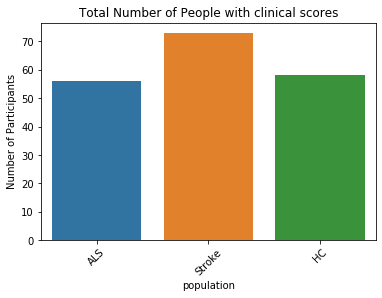

In [22]:
g = sns.countplot(x='population',data=slp_scores)
g.set_xticklabels(g.get_xticklabels(), rotation=45)

# set axes labels and title
plt.ylabel('Number of Participants')
plt.title('Total Number of People with clinical scores')
plt.show()
#plt.savefig('plot1', bbox_inches='tight')

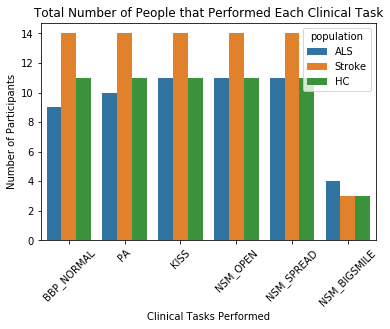

In [23]:
# TASKS 

g = sns.countplot(x='task',data=slp_scores, hue='population')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

# set axes labels and title
plt.ylabel('Number of Participants')
plt.xlabel('Clinical Tasks Performed')
plt.title('Total Number of People that Performed Each Clinical Task')
plt.savefig('plot1', bbox_inches='tight')
plt.show()


In [24]:
print(slp_scores.groupby(['task']).count()['File Name'])
print(sum(slp_scores.groupby(['task']).count()['File Name']))

task
BBP_NORMAL      34
KISS            36
NSM_BIGSMILE    10
NSM_OPEN        36
NSM_SPREAD      36
PA              35
Name: File Name, dtype: int64
187


In [25]:
#g = sns.FacetGrid(slp_scores, col="Subject ID", col_wrap=3, height=5, ylim=(0, 20))
#g.map(sns.pointplot, "File Name", "ROM_avg",color=".3", ci=None);


In [26]:
#g = sns.FacetGrid(slp_scores, col="Subject ID", col_wrap=3, height=5, ylim=(0, 20))
#g.map(sns.pointplot, "File Name", "Tot_avg",color=".3", ci=None);


In [27]:

path2 = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/ALS/VID_DATASET_Clinical information_ALS.csv'
als_df_demog = pd.read_csv(path2)

print(len(als_df_demog))
print(als_df_demog.columns)
print(als_df_demog.SubjectID.unique())
als_df_demog.head()

10
Index(['SubjectID', 'AgeSession', 'Gender', 'DisDurDiag', 'AgeDiag',
       'DisDurON', 'AgeOnset', 'SiteOnset', 'ALSFRSTot', 'ALSFRSBulb',
       'Intell (%)', 'SpeakRate (words/min)'],
      dtype='object')
['A002' 'A006' 'A008' 'A009' 'A010' 'A011' 'A012' 'A014' 'A015' 'A017']


SubjectID  AgeSession Gender  DisDurDiag  AgeDiag  DisDurON  AgeOnset  \
0      A002          62      F          19       60        31        59   
1      A006          64      F          20       62       109        55   
2      A008          55      M          15       54        28        53   
3      A009          45      F          29       42        41        41   
4      A010          68      M          10       67        26        66   

           SiteOnset  ALSFRSTot  ALSFRSBulb Intell (%) SpeakRate (words/min)  
0        Lower limbs         31          12        100                151.72  
1  Upper/Lower limbs         26          12      96.36                122.68  
2        Upper limbs         39          11      91.82                143.17  
3        Lower limbs         26           7      28.18                 63.28  
4        Upper limbs         40          12      87.27                 88.61

In [28]:
for i, s in enumerate(neuroface_subjects):
    if 'N' in s:
        s = s.replace('N0', 'NF')
        neuroface_subjects[i] = s
        
        
print(neuroface_subjects)
print(len(neuroface_subjects))

['A002' 'A006' 'A008' 'A009' 'A010' 'A011' 'A012' 'A014' 'A015' 'A016'
 'A017' 'OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007'
 'S008' 'S009' 'S011' 'S012' 'S013' 'NF01' 'NF02' 'NF03' 'NF04' 'NF07'
 'NF08' 'NF10' 'NF11' 'NF12' 'NF17' 'NF19']
36


# Fine-Tuned All Features All Common Subjects 

### Non-standardized 

In [29]:

# read stroke data 

tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
task = 0# 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE

features = ['O_MAX', 'O_MIN', 'O_MAX_VEL', 'O_MIN_VEL','W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH', 
            'R_LCRC', 'D_0','D_1', 'D_2', 'D_3', 'LL_PATH', 'A_MEAN', 'A_RANGE', 'A_ABS_DIFF','A_CCC', 'WIDTH_MAX',
            'WIDTH_MEAN', 'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN','HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX', 
            'HEIGHT_VEL_MIN','R_SYMM', 'E_MEAN', 'E_RANGE']
print(len(features))


stroke_df = pd.DataFrame()

for task in range(len(tasks)):
    
    stroke_file = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/results/stroke/metric_output_"+tasks[task]+".csv"    
    df = pd.read_csv(stroke_file)
    df = df.drop('Unnamed: 0', axis=1)
    stroke_df = pd.concat([stroke_df, df], ignore_index=True)
        
print(stroke_df.shape)


# read als
als_df = pd.DataFrame()

for task in range(len(tasks)):

    als_file = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/results/als/metric_output_"+tasks[task]+".csv"
    df = pd.read_csv(als_file)
    df = df.drop('Unnamed: 0', axis=1)
    als_df = pd.concat([als_df, df], ignore_index=True)

print(als_df.shape)

# merge the two feature dfs into one feature df
feature_df = pd.concat([stroke_df, als_df], ignore_index=True)
print(feature_df.shape)
feature_df.head()

30
(1034, 34)
(269, 34)
(1303, 34)


subject_id        task  type  rep     O_MAX     O_MIN  O_MAX_VEL  O_MIN_VEL  \
0       NF11  BBP_NORMAL     0    1  2.286921  1.022002   0.594900  -0.544603   
1       NF11  BBP_NORMAL     0    2  2.188607  0.996711   0.820745  -0.436266   
2       NF11  BBP_NORMAL     0    3  2.058023  1.047133   0.769061  -0.903222   
3       NF11  BBP_NORMAL     0    4  2.075979  1.042164   1.059445  -0.647830   
4       NF11  BBP_NORMAL     0    5  1.981968  1.005337   0.676766  -0.322046   

      W_MAX     W_MIN  ...  WIDTH_MEAN  WIDTH_VEL_MAX  WIDTH_VEL_MIN  \
0  1.077094  0.876171  ...    0.876171       0.119329      -0.104292   
1  1.044838  0.870372  ...    0.870372       0.095685      -0.054182   
2  1.022509  0.865620  ...    0.865620       0.047249      -0.049228   
3  1.027606  0.885372  ...    0.885372       0.059202      -0.064426   
4  1.134544  0.922301  ...    0.922301       0.114083      -0.139226   

   HEIGHT_MAX  HEIGHT_MIN  HEIGHT_VEL_MAX  HEIGHT_VEL_MIN    R_SYMM    E_MEAN  \
0    2.286921    1.022002        0.594900       -0.544603  0.215262  0.883412   
1    2.188607    0.996711        0.820745       -0.436266  0.091104  0.883224   
2    2.058023    1.047133        0.769061       -0.903222  0.367979  0.880140   
3    2.075979    1.042164        1.059445       -0.647830  0.170831  0.878176   
4    1.981968    1.005337        0.676766       -0.322046  0.445453  0.905869   

    E_RANGE  
0  0.173549  
1  0.161749  
2  0.149042  
3  0.144935  
4  0.126557  

[5 rows x 34 columns]

### Standardized 

In [30]:
# read stroke data 

tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
task = 0# 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE

features = ['O_MAX', 'O_MIN', 'O_MAX_VEL', 'O_MIN_VEL','W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH', 
            'R_LCRC', 'D_0','D_1', 'D_2', 'D_3', 'LL_PATH', 'A_MEAN', 'A_RANGE', 'A_ABS_DIFF','A_CCC', 'WIDTH_MAX',
            'WIDTH_MEAN', 'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN','HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX', 
            'HEIGHT_VEL_MIN','R_SYMM', 'E_MEAN', 'E_RANGE']
print(len(features))


stroke_df = pd.DataFrame()

for task in range(len(tasks)):
    
    stroke_file = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/results/stroke/metric_output_"+tasks[task]+"_standardized.csv"    
    df = pd.read_csv(stroke_file)
    df = df.drop('Unnamed: 0', axis=1)
    stroke_df = pd.concat([stroke_df, df], ignore_index=True)
        
print(stroke_df.shape)


# read als
als_df = pd.DataFrame()

for task in range(len(tasks)):

    als_file = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/results/als/metric_output_"+tasks[task]+"_standardized.csv"
    df = pd.read_csv(als_file)
    df = df.drop('Unnamed: 0', axis=1)
    als_df = pd.concat([als_df, df], ignore_index=True)

print(als_df.shape)

# merge the two feature dfs into one feature df
feature_df = pd.concat([stroke_df, als_df], ignore_index=True)
print(feature_df.shape)
feature_df.head()

30
(1034, 34)
(269, 34)
(1303, 34)


subject_id        task  type  rep     O_MAX     O_MIN  O_MAX_VEL  O_MIN_VEL  \
0       NF11  BBP_NORMAL     0    1 -0.107137  0.093444  -0.087284   0.096988   
1       NF11  BBP_NORMAL     0    2 -0.119677 -0.020186  -0.066962   0.106815   
2       NF11  BBP_NORMAL     0    3 -0.136333  0.206355  -0.071613   0.064457   
3       NF11  BBP_NORMAL     0    4 -0.134042  0.184029  -0.045484   0.087624   
4       NF11  BBP_NORMAL     0    5 -0.146033  0.018567  -0.079917   0.117176   

      W_MAX     W_MIN  ...  WIDTH_MEAN  WIDTH_VEL_MAX  WIDTH_VEL_MIN  \
0 -0.095390 -0.222826  ...   -0.222826      -0.086891       0.081209   
1 -0.112454 -0.281094  ...   -0.281094      -0.098951       0.098288   
2 -0.124266 -0.328850  ...   -0.328850      -0.123657       0.099976   
3 -0.121569 -0.130368  ...   -0.130368      -0.117560       0.094797   
4 -0.064999  0.240711  ...    0.240711      -0.089567       0.069302   

   HEIGHT_MAX  HEIGHT_MIN  HEIGHT_VEL_MAX  HEIGHT_VEL_MIN    R_SYMM    E_MEAN  \
0   -0.107137    0.093444       -0.087284        0.096988 -0.776337 -0.385785   
1   -0.119677   -0.020186       -0.066962        0.106815 -1.209984 -0.390416   
2   -0.136333    0.206355       -0.071613        0.064457 -0.242942 -0.466591   
3   -0.134042    0.184029       -0.045484        0.087624 -0.931521 -0.515096   
4   -0.146033    0.018567       -0.079917        0.117176  0.027650  0.168873   

    E_RANGE  
0 -0.244174  
1 -0.339131  
2 -0.441387  
3 -0.474437  
4 -0.622324  

[5 rows x 34 columns]

In [31]:
# what is the common ids betweeen neuroface and this dataset
print(np.intersect1d(feature_df.subject_id.unique(),neuroface_subjects))
print(len(np.intersect1d(feature_df.subject_id.unique(),neuroface_subjects)))

# merge the feature df with neuroface clinical scores

sub_neuro_df = feature_df.merge(slp_scores, how= 'inner', left_on=['subject_id', 'task'], right_on=['Subject ID', 'task'])

print(len(sub_neuro_df.subject_id.unique()))
print(len(feature_df.subject_id.unique()))
print(sub_neuro_df.task.unique())
print()
print(slp_scores.shape)
print(feature_df.shape)
print(sub_neuro_df.shape)
print(sub_neuro_df.columns)
sub_neuro_df = sub_neuro_df.drop(['type','File Name',
       'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)', 'Speed (SLP1)',
       'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)', 'Symmetry (SLP2)',
       'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)', 'Fatigue (SLP2)',
       'Tot (SLP2)' ], axis=1)

print(sub_neuro_df.columns)
print(len(sub_neuro_df.columns))
print(sub_neuro_df.shape)

# filtering out the outliers 

z_scores = stats.zscore(sub_neuro_df[features])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
sub_neuro_df = sub_neuro_df[filtered_entries]

print(sub_neuro_df.shape)

['A008' 'A009' 'A010' 'A011' 'A014' 'A016' 'A017' 'NF01' 'NF02' 'NF03'
 'NF04' 'NF07' 'NF08' 'NF10' 'NF11' 'NF12' 'NF17' 'NF19' 'OP01' 'OP02'
 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007' 'S008' 'S009' 'S013']
30
30
59
['BBP_NORMAL' 'NSM_OPEN' 'NSM_SPREAD' 'NSM_BIGSMILE']

(187, 22)
(1303, 34)
(643, 55)
Index(['subject_id', 'task', 'type', 'rep', 'O_MAX', 'O_MIN', 'O_MAX_VEL',
       'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH',
       'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3', 'LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE', 'File Name',
       'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)', 'Speed (SLP1)',
       'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)', 'Symmetry (SLP2)',
       'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)', 'Fatigue (SLP2)',
       'Tot (SLP2)', 'To

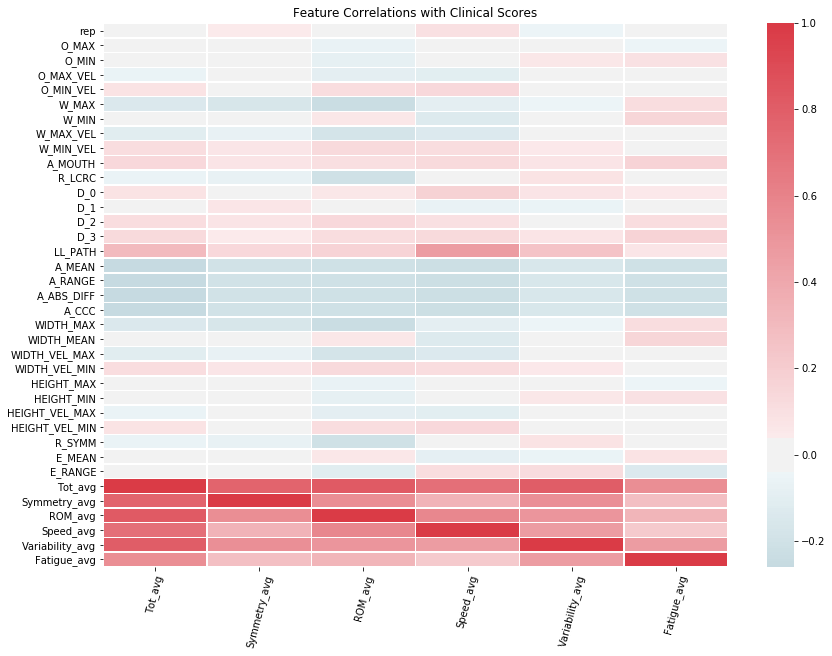

In [32]:

# run features vs scores corrolation analysis and scatter plots 
corr = sub_neuro_df.corr()
ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), 
               cmap=sns.diverging_palette(220, 10, as_cmap=True),center=0.00, linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.title('Feature Correlations with Clinical Scores')
plt.show()



Spearmans correlation between O_MAX and Tot_avg: -0.023
Spearmans correlation between O_MIN and Tot_avg: -0.001
Spearmans correlation between O_MAX_VEL and Tot_avg: -0.075
Spearmans correlation between O_MIN_VEL and Tot_avg: 0.064
Spearmans correlation between W_MAX and Tot_avg: -0.131
Spearmans correlation between W_MIN and Tot_avg: -0.034
Spearmans correlation between W_MAX_VEL and Tot_avg: -0.155
Spearmans correlation between W_MIN_VEL and Tot_avg: 0.085
Spearmans correlation between A_MOUTH and Tot_avg: 0.150
Spearmans correlation between R_LCRC and Tot_avg: -0.051
Spearmans correlation between D_0 and Tot_avg: 0.106
Spearmans correlation between D_1 and Tot_avg: 0.042
Spearmans correlation between D_2 and Tot_avg: 0.151
Spearmans correlation between D_3 and Tot_avg: 0.146
Spearmans correlation between LL_PATH and Tot_avg: 0.220
Spearmans correlation between A_MEAN and Tot_avg: -0.134
Spearmans correlation between A_RANGE and Tot_avg: -0.134
Spearmans correlation between A_ABS_DIFF

//anaconda3/envs/csc2541/lib/python3.8/site-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Spearmans correlation between WIDTH_MEAN and Tot_avg: -0.034
Spearmans correlation between WIDTH_VEL_MAX and Tot_avg: -0.155
Spearmans correlation between WIDTH_VEL_MIN and Tot_avg: 0.085
Spearmans correlation between HEIGHT_MAX and Tot_avg: -0.023
Spearmans correlation between HEIGHT_MIN and Tot_avg: -0.001
Spearmans correlation between HEIGHT_VEL_MAX and Tot_avg: -0.075
Spearmans correlation between HEIGHT_VEL_MIN and Tot_avg: 0.064
Spearmans correlation between R_SYMM and Tot_avg: -0.051
Spearmans correlation between E_MEAN and Tot_avg: 0.103
Spearmans correlation between E_RANGE and Tot_avg: -0.058
Spearmans correlation between O_MAX and Symmetry_avg: 0.066
Spearmans correlation between O_MIN and Symmetry_avg: 0.002
Spearmans correlation between O_MAX_VEL and Symmetry_avg: -0.113
Spearmans correlation between O_MIN_VEL and Symmetry_avg: 0.046
Spearmans correlation between W_MAX and Symmetry_avg: -0.146
Spearmans correlation between W_MIN and Symmetry_avg: -0.022
Spearmans correlati

Spearmans correlation between O_MIN_VEL and Fatigue_avg: 0.028
Spearmans correlation between W_MAX and Fatigue_avg: 0.047
Spearmans correlation between W_MIN and Fatigue_avg: 0.127
Spearmans correlation between W_MAX_VEL and Fatigue_avg: -0.042
Spearmans correlation between W_MIN_VEL and Fatigue_avg: 0.002
Spearmans correlation between A_MOUTH and Fatigue_avg: 0.145
Spearmans correlation between R_LCRC and Fatigue_avg: -0.060
Spearmans correlation between D_0 and Fatigue_avg: 0.068
Spearmans correlation between D_1 and Fatigue_avg: -0.016
Spearmans correlation between D_2 and Fatigue_avg: 0.079
Spearmans correlation between D_3 and Fatigue_avg: 0.196
Spearmans correlation between LL_PATH and Fatigue_avg: -0.030
Spearmans correlation between A_MEAN and Fatigue_avg: -0.077
Spearmans correlation between A_RANGE and Fatigue_avg: -0.077
Spearmans correlation between A_ABS_DIFF and Fatigue_avg: -0.077
Spearmans correlation between A_CCC and Fatigue_avg: -0.077
Spearmans correlation between W

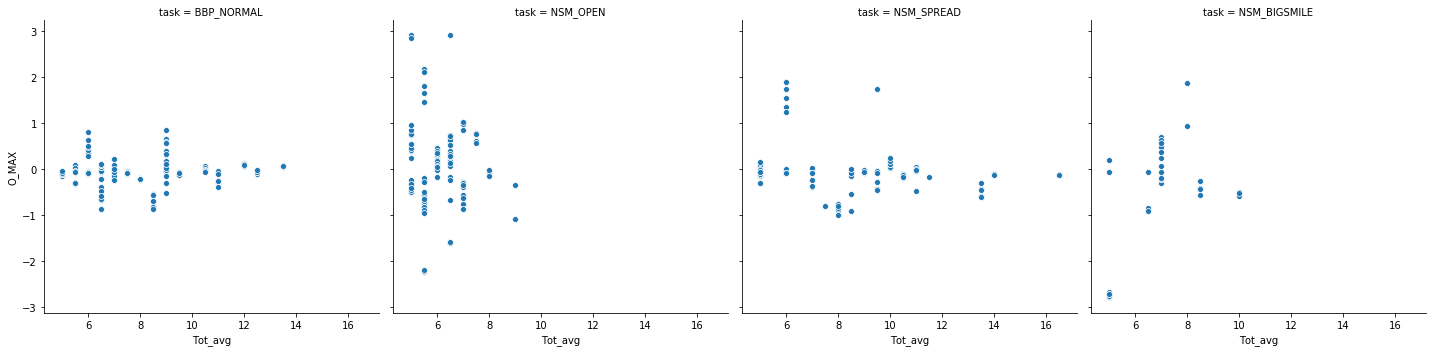

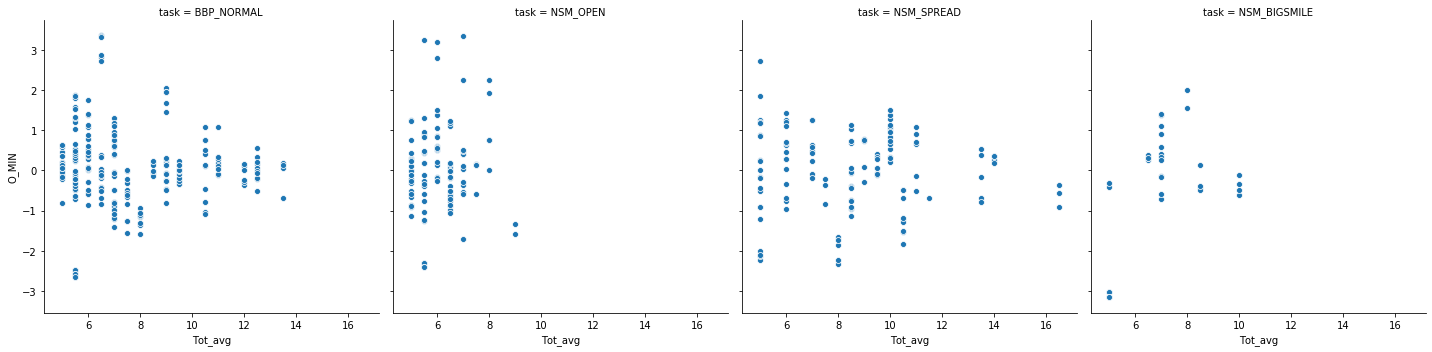

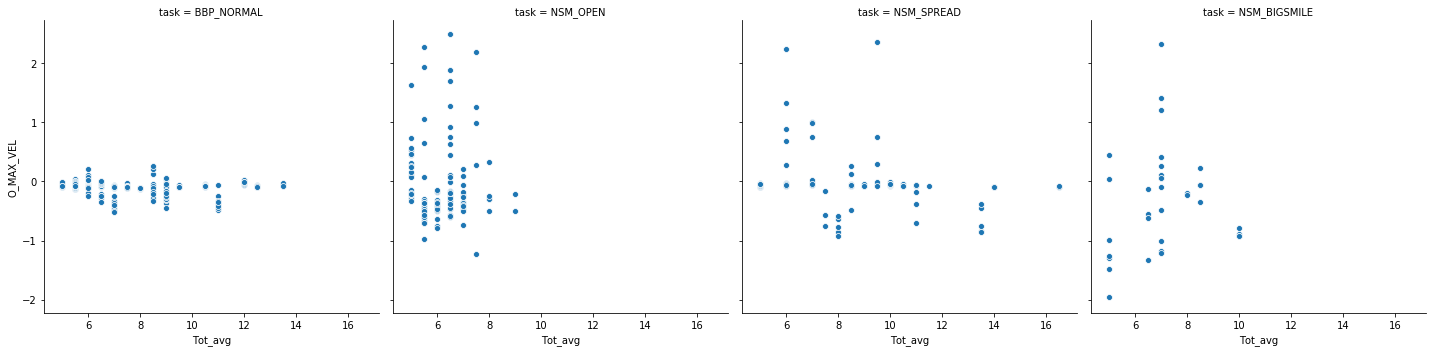

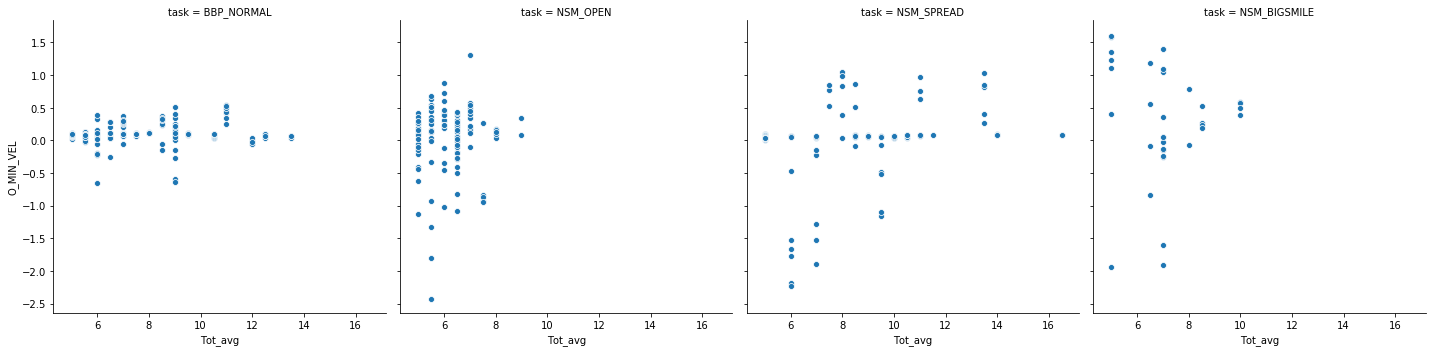

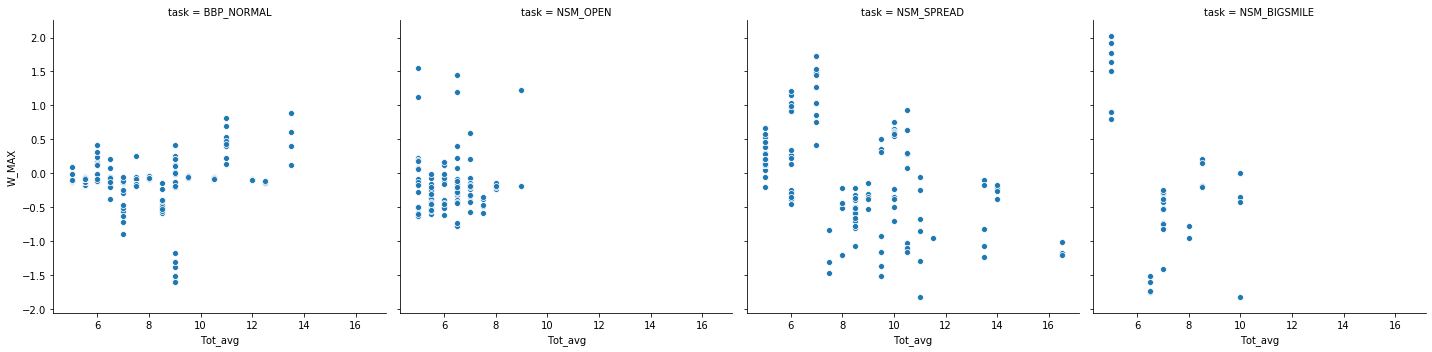

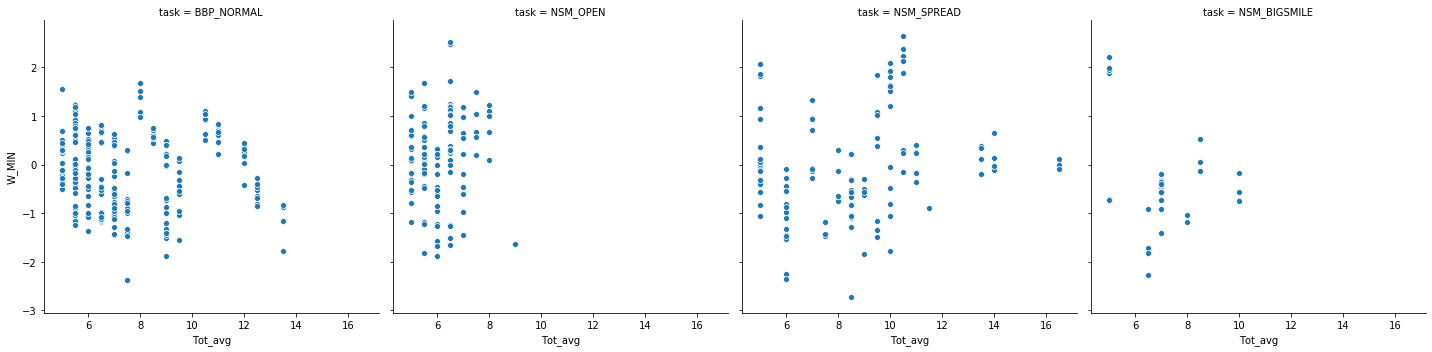

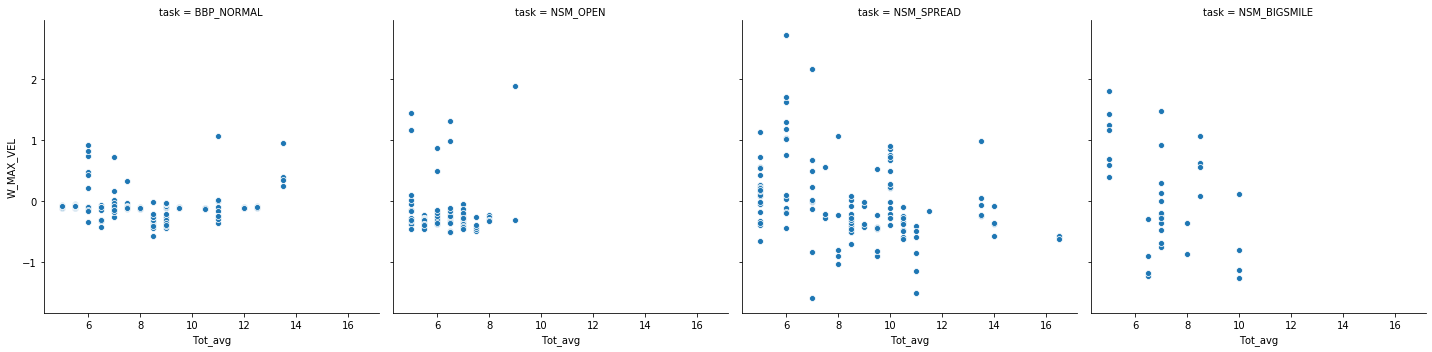

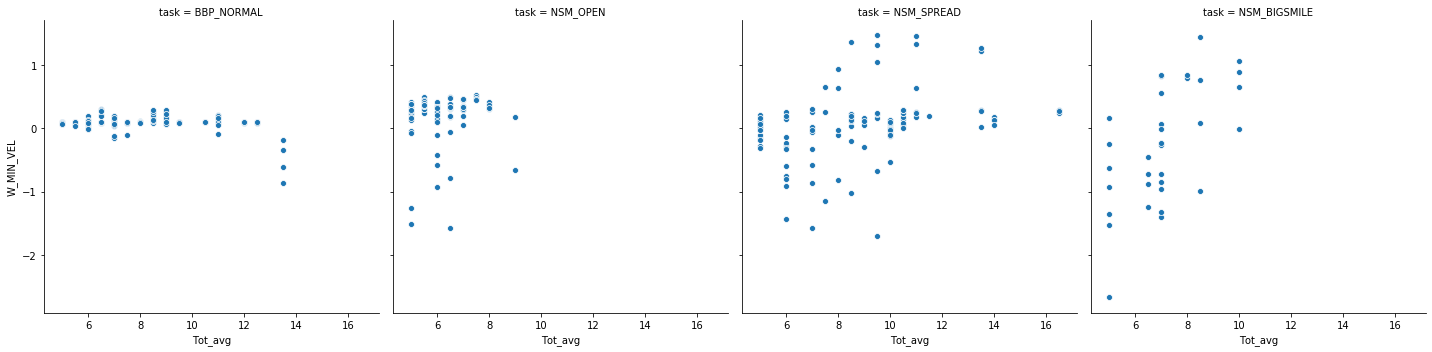

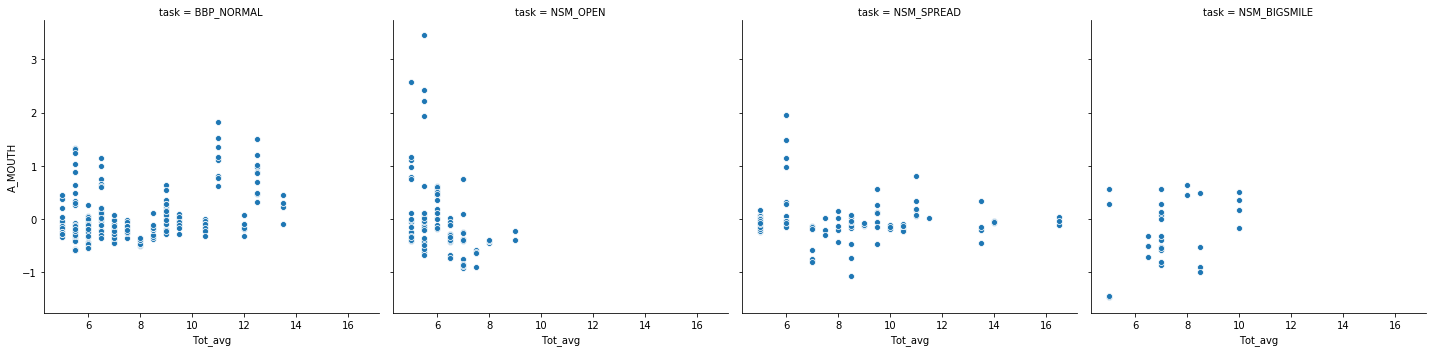

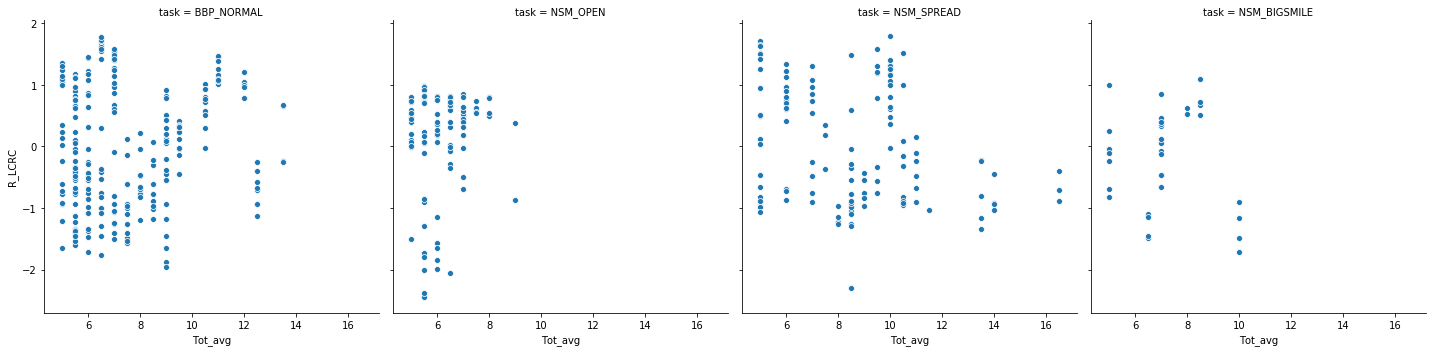

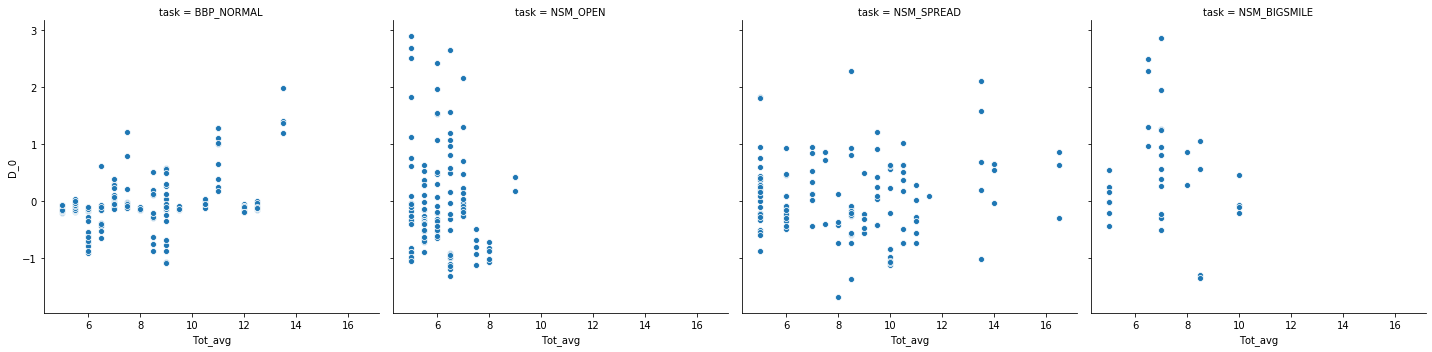

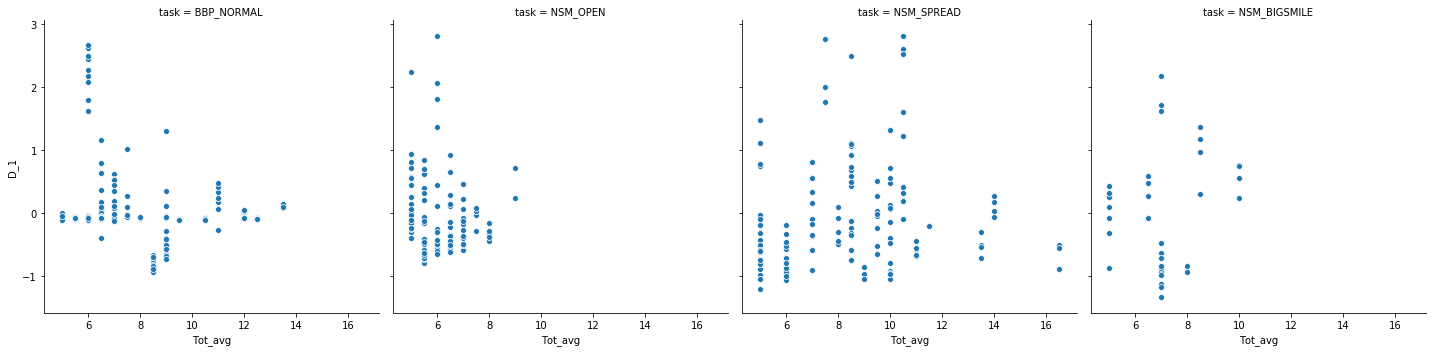

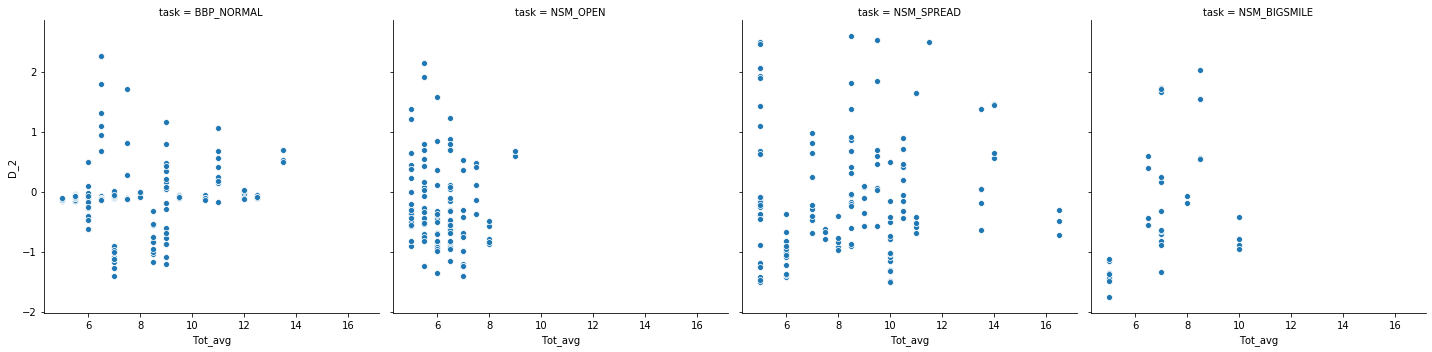

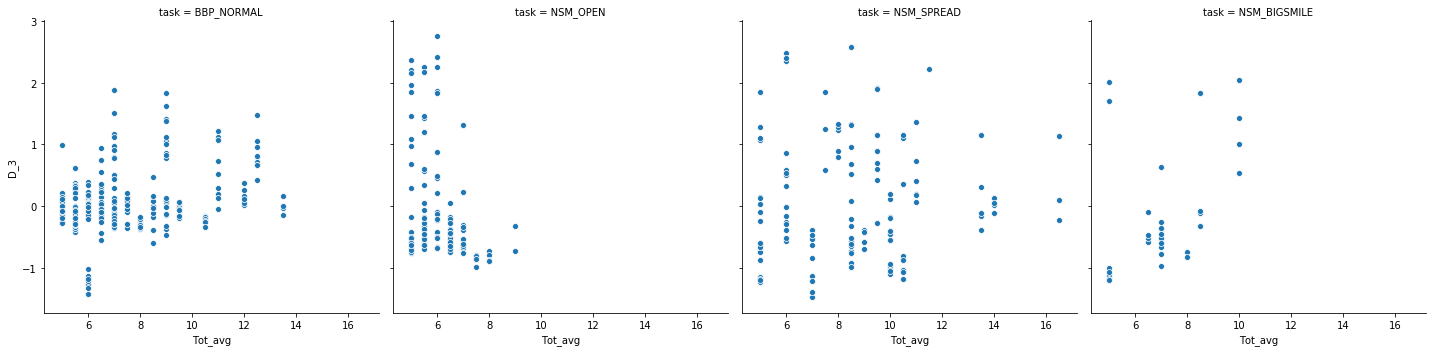

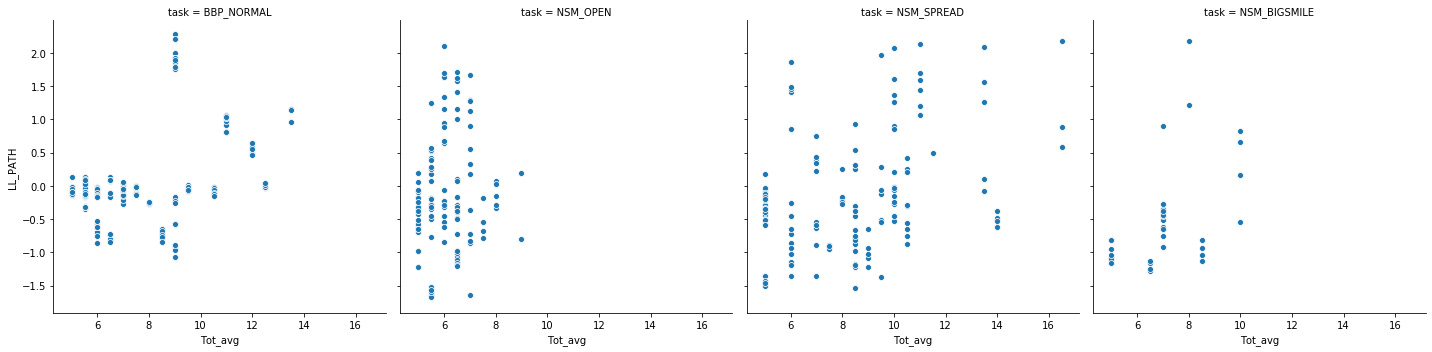

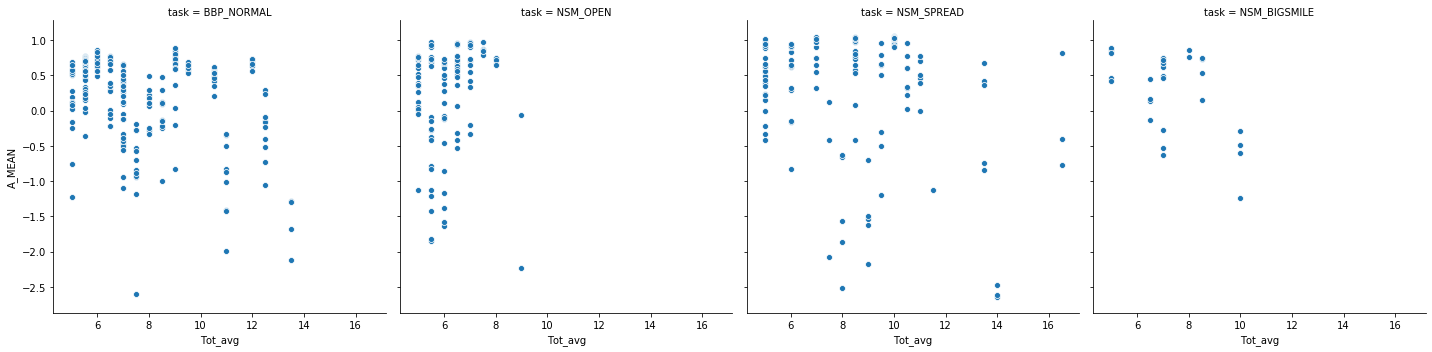

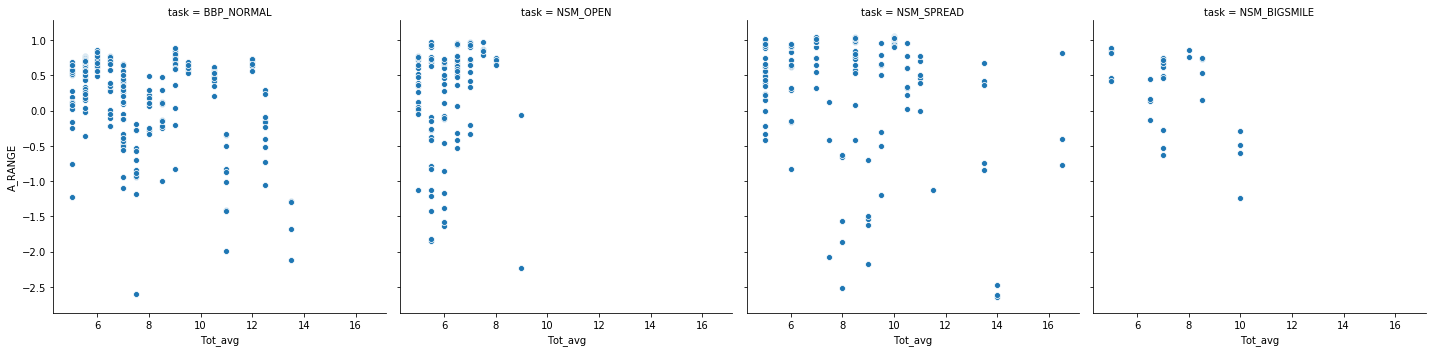

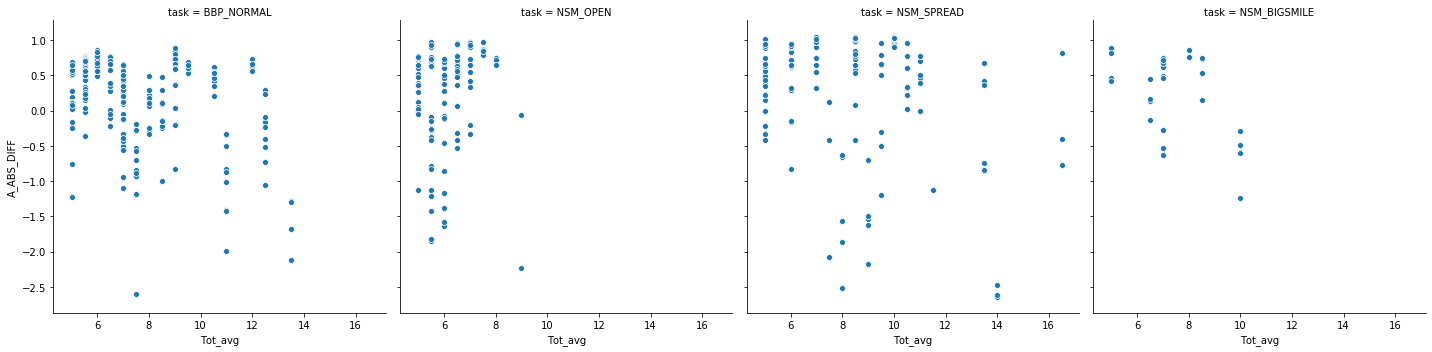

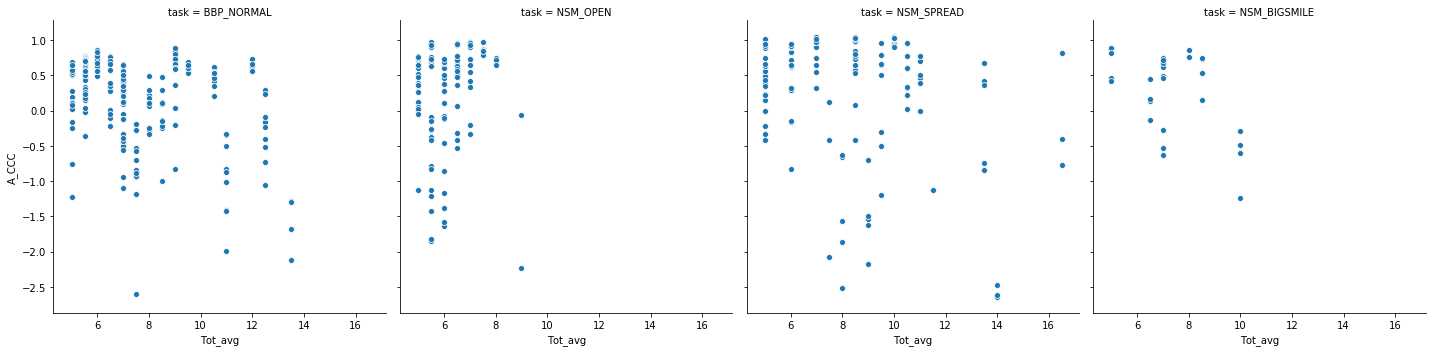

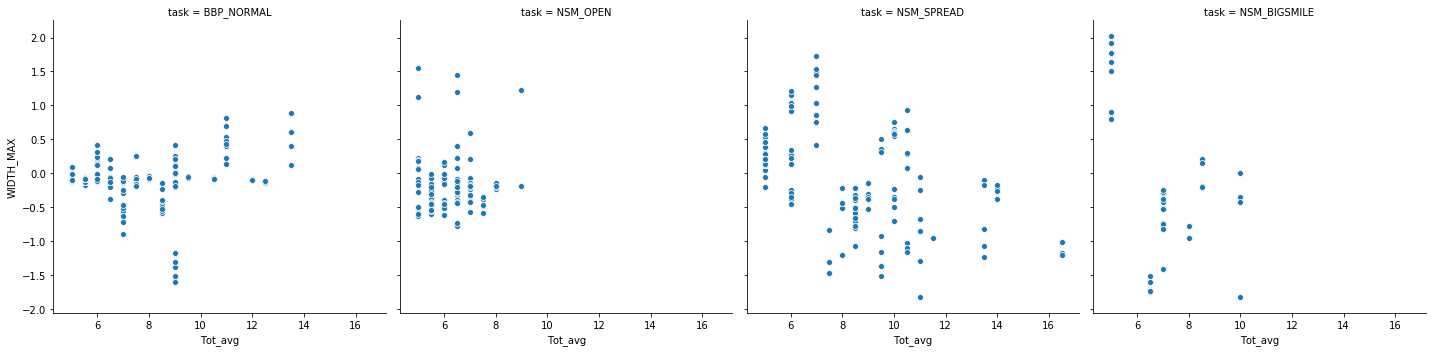

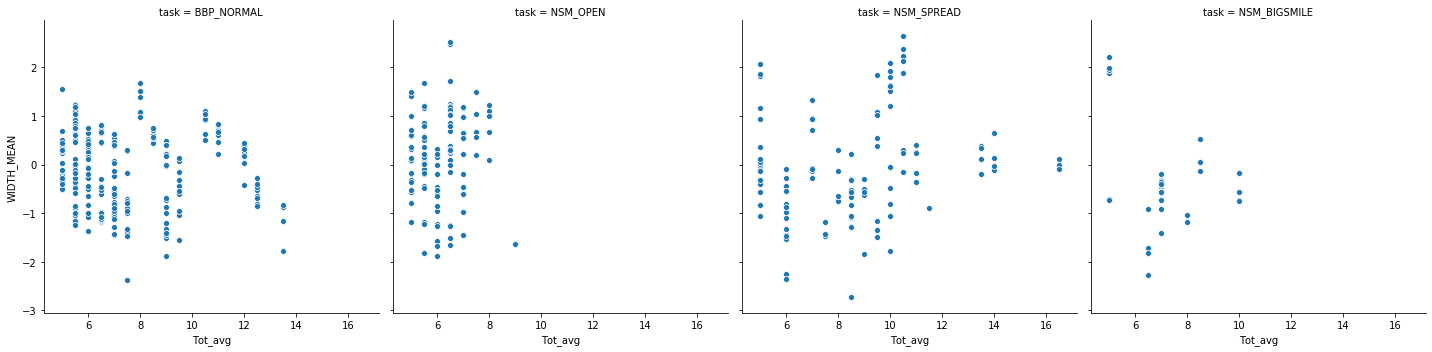

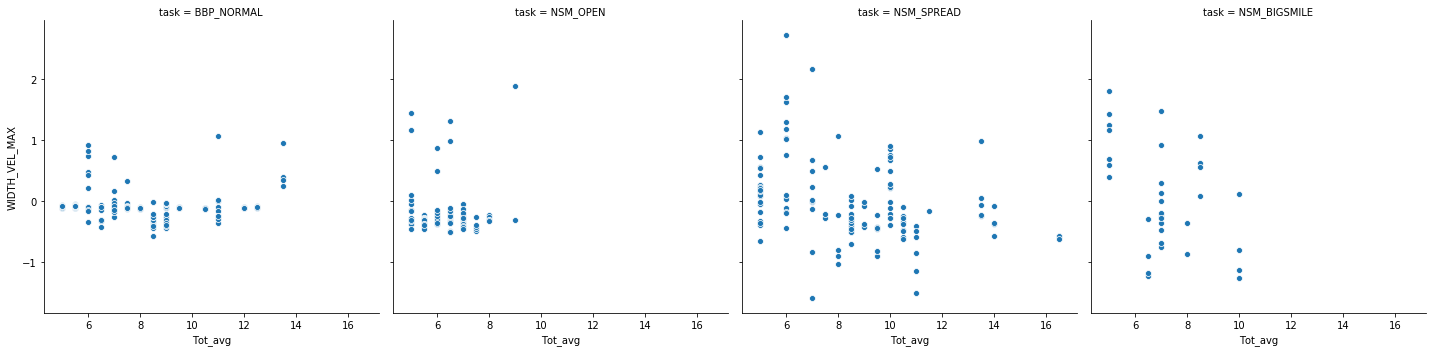

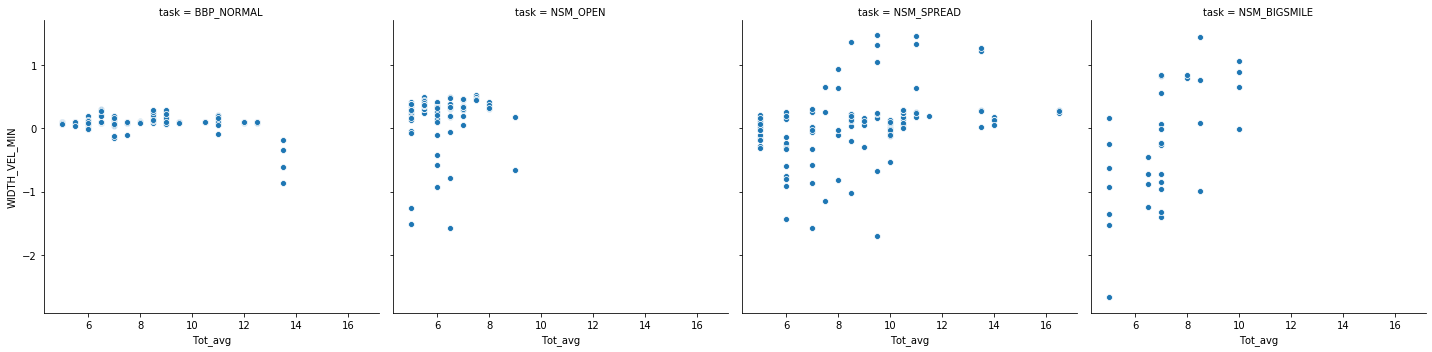

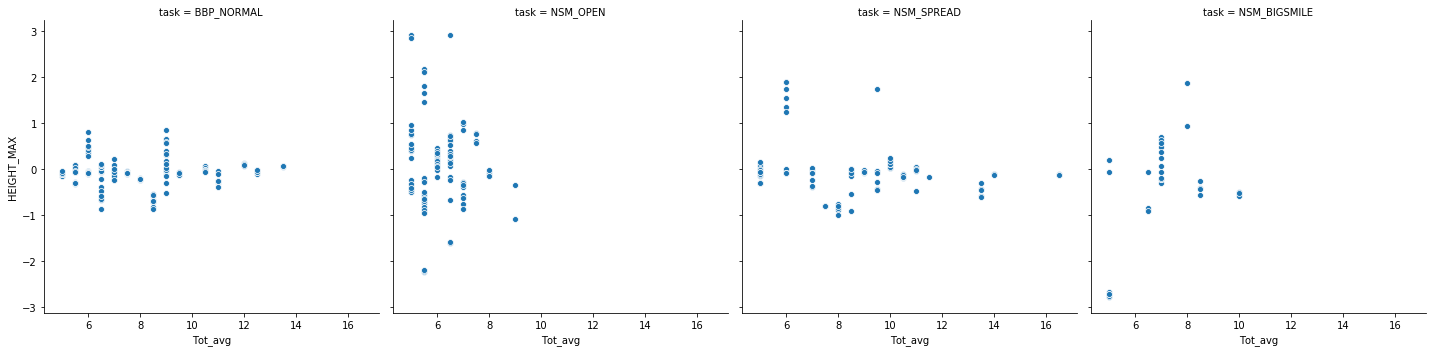

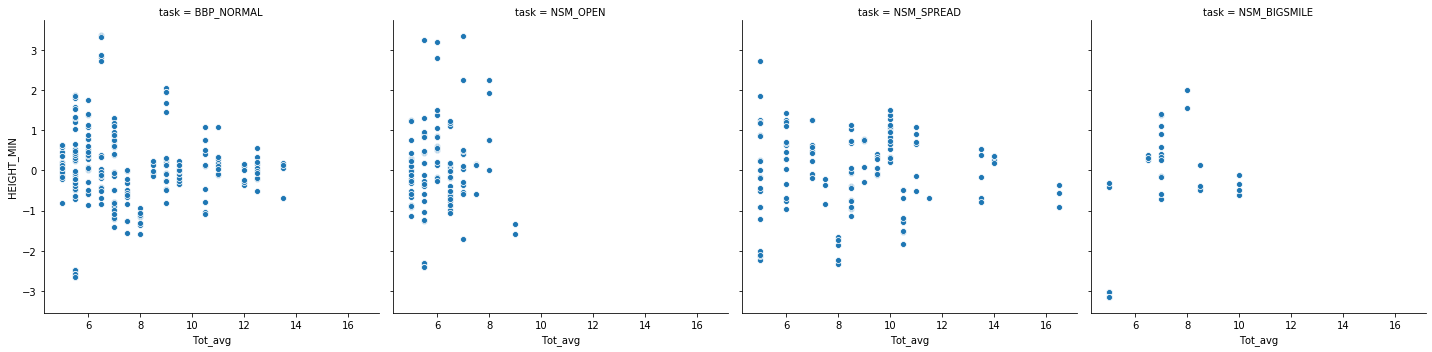

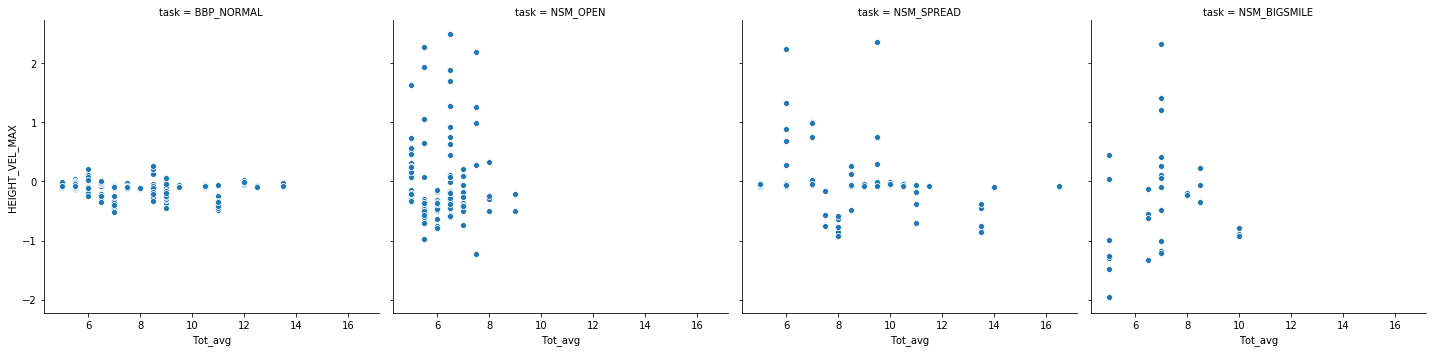

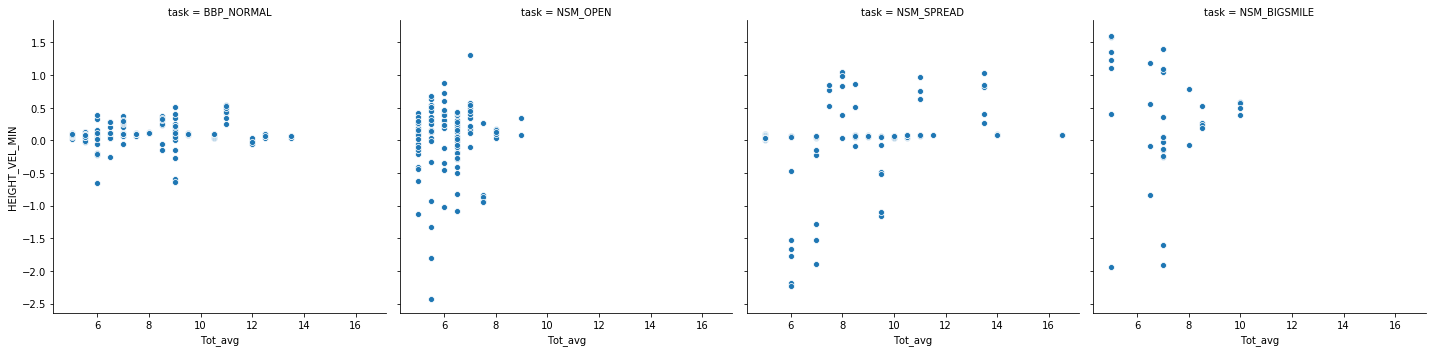

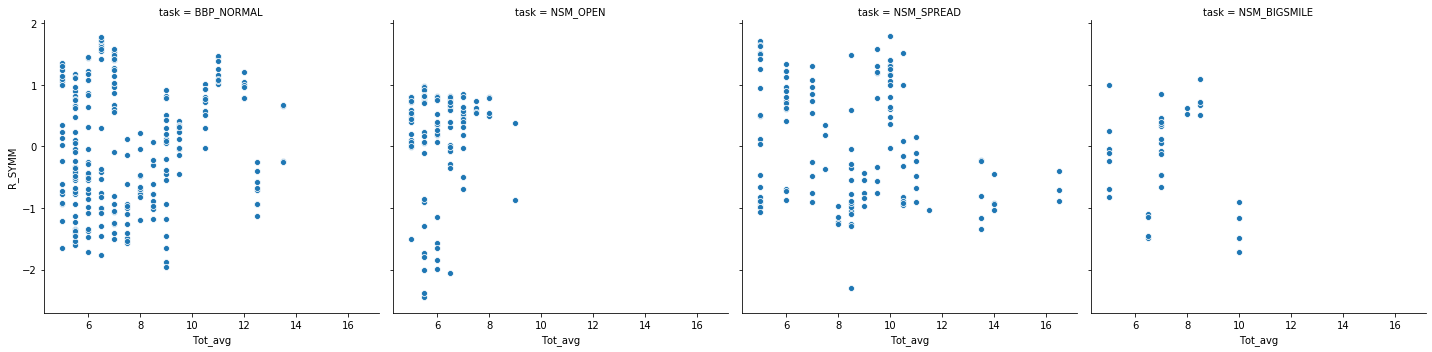

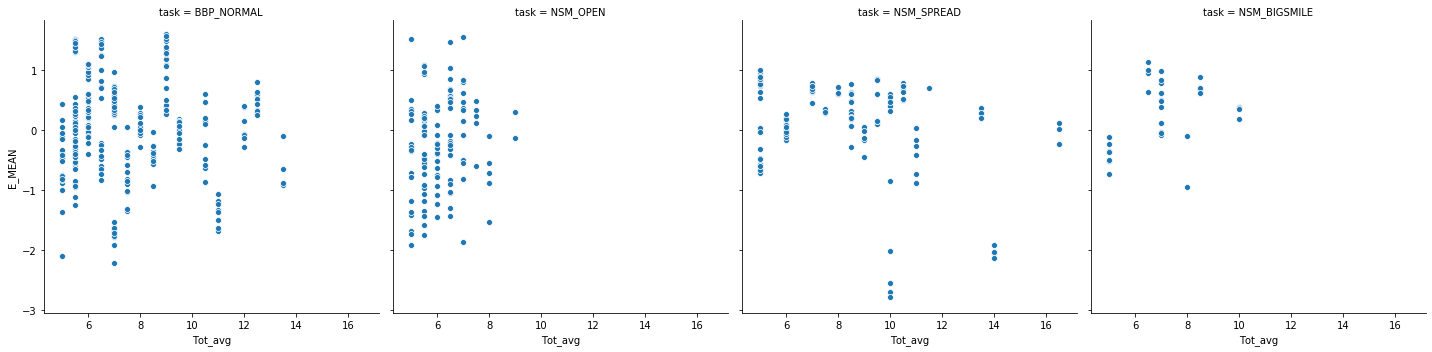

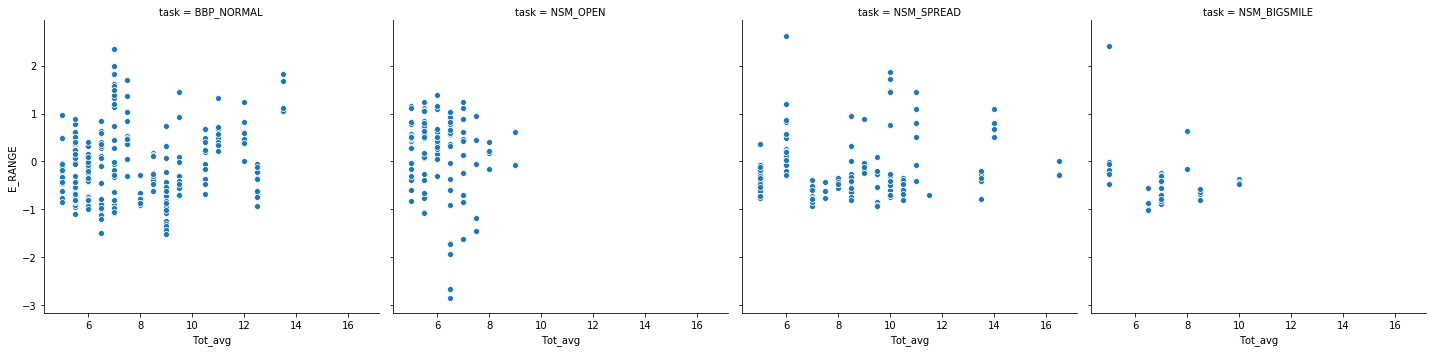

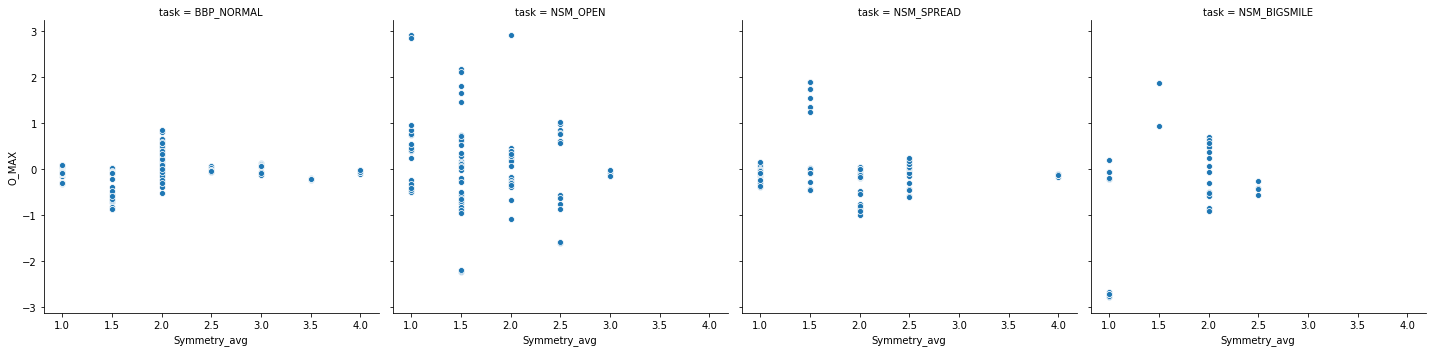

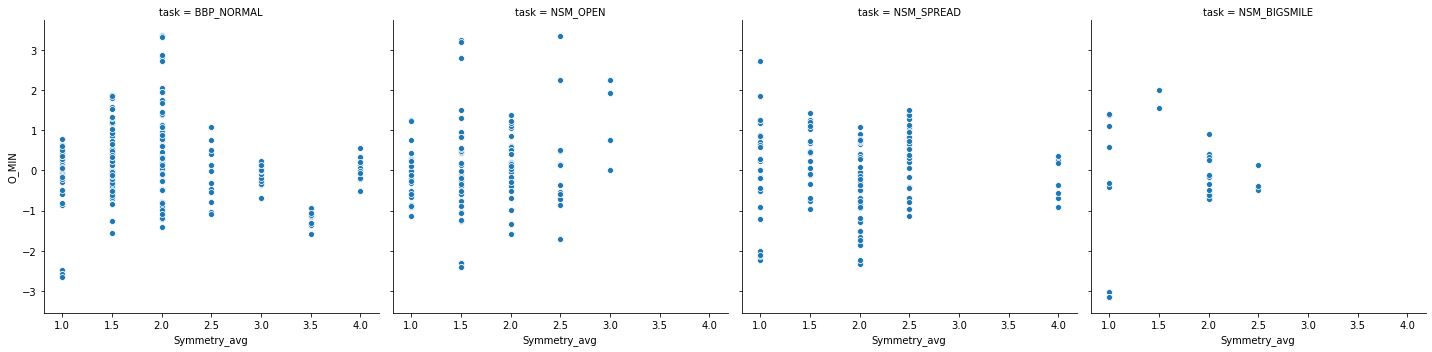

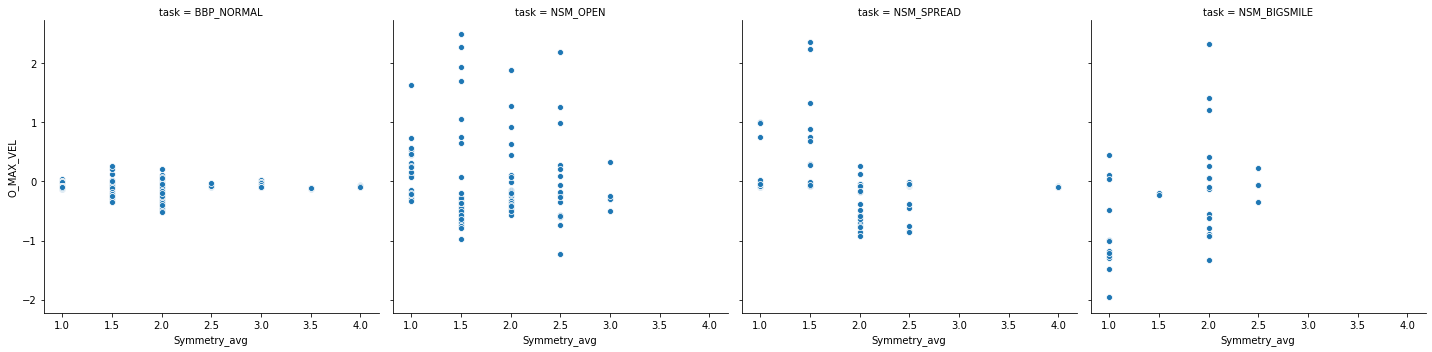

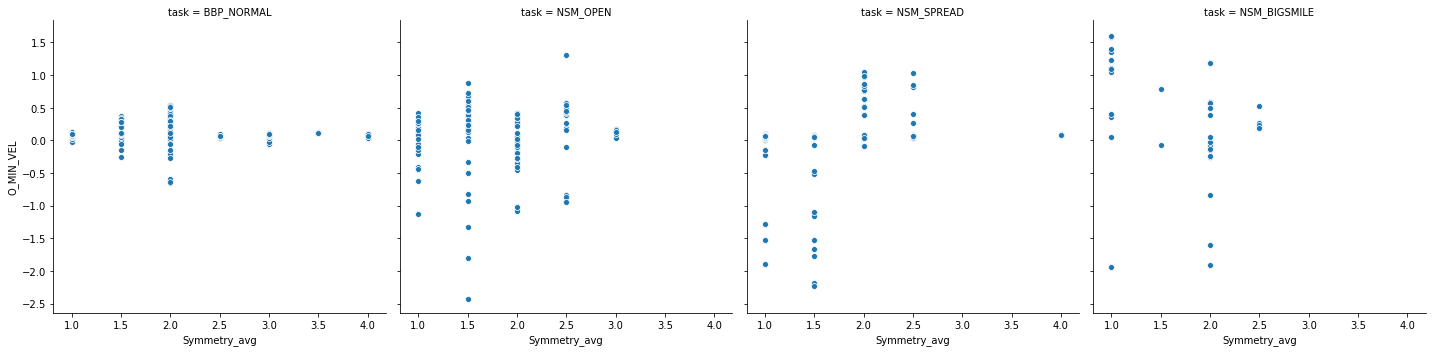

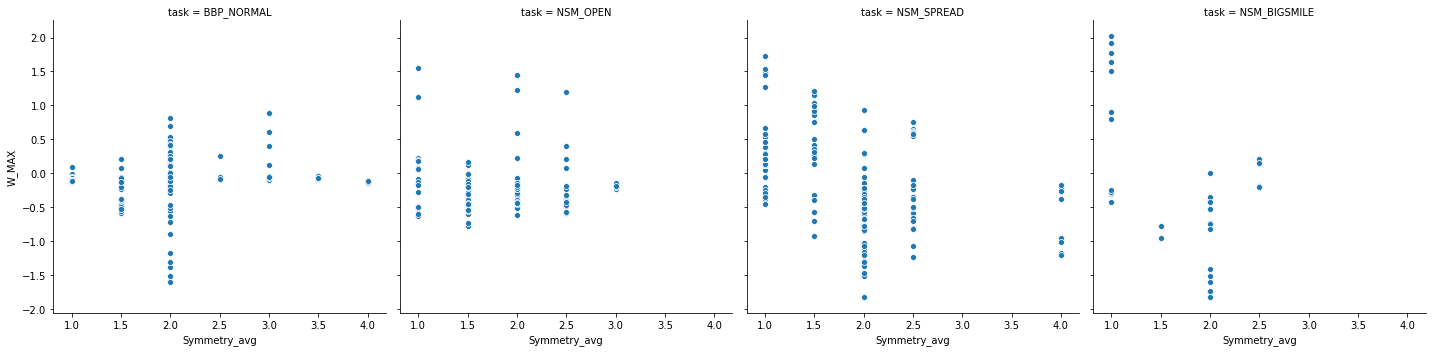

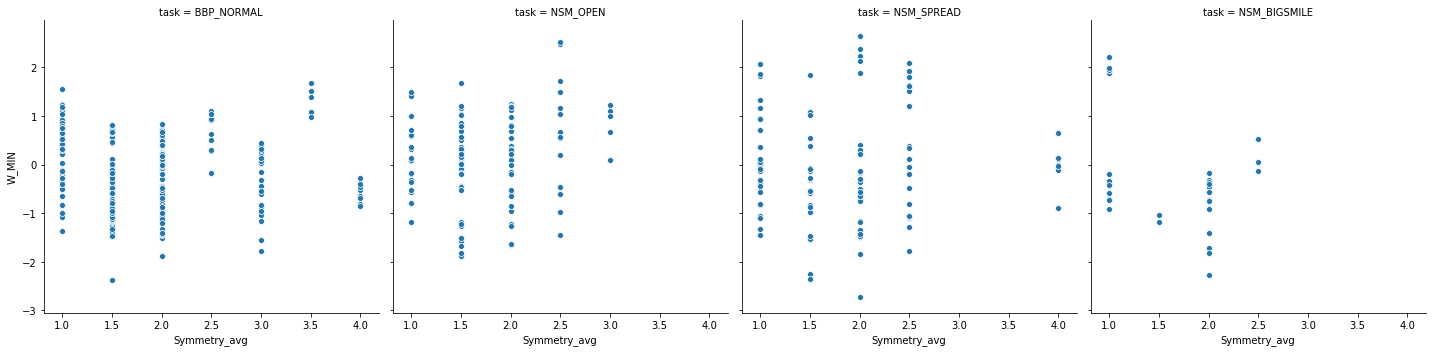

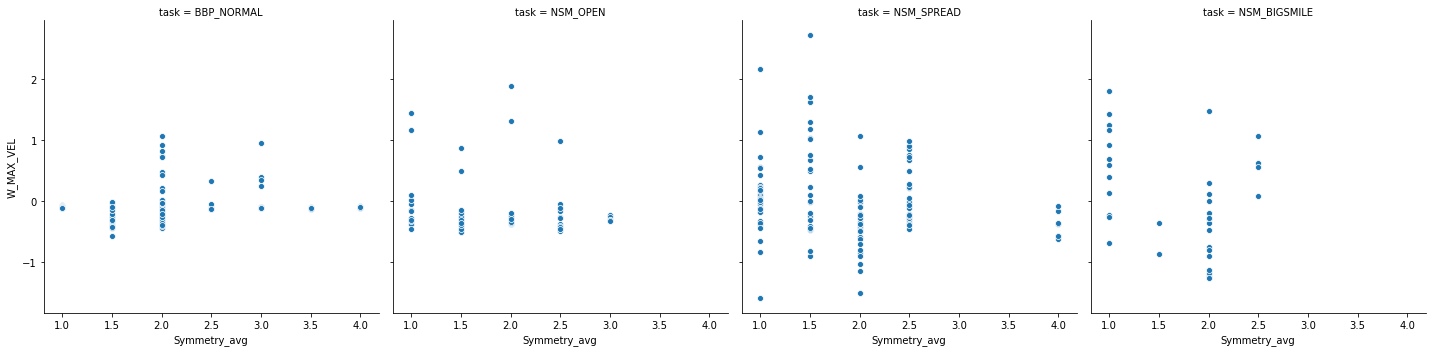

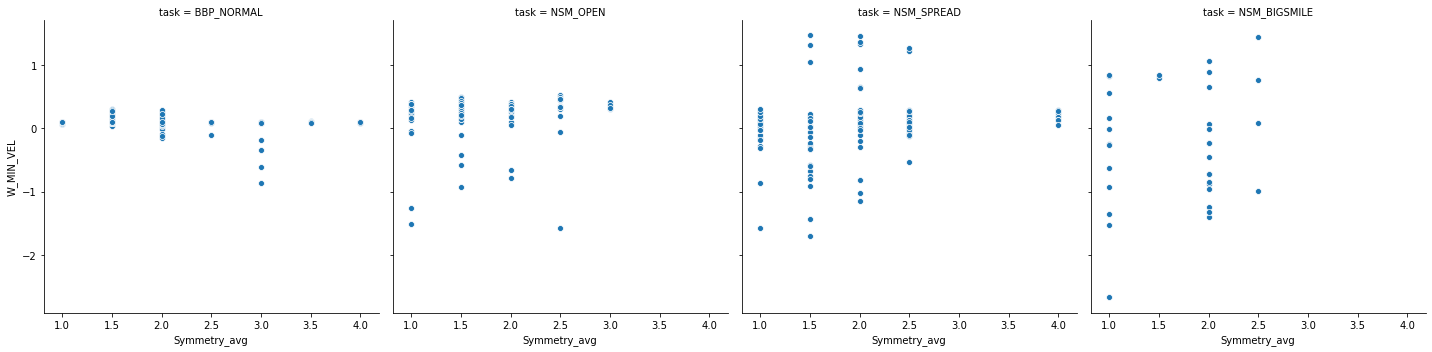

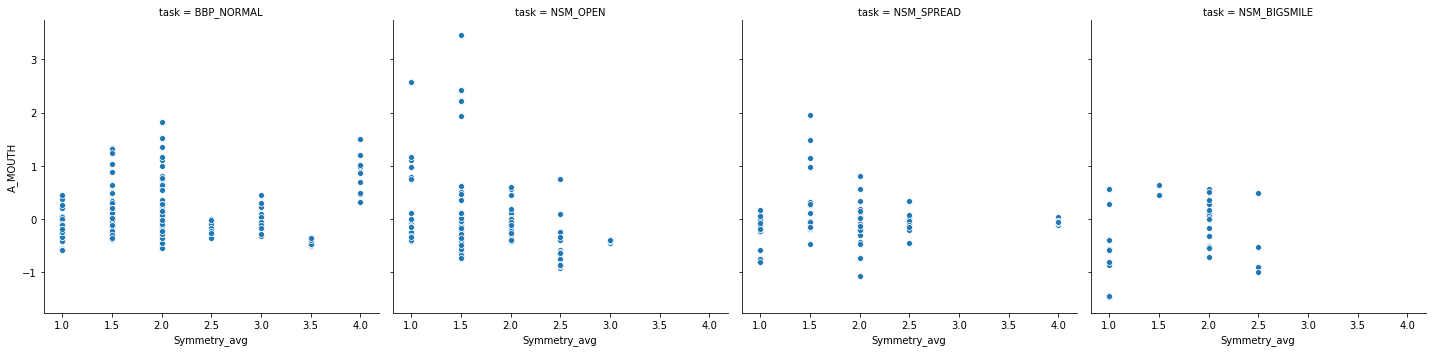

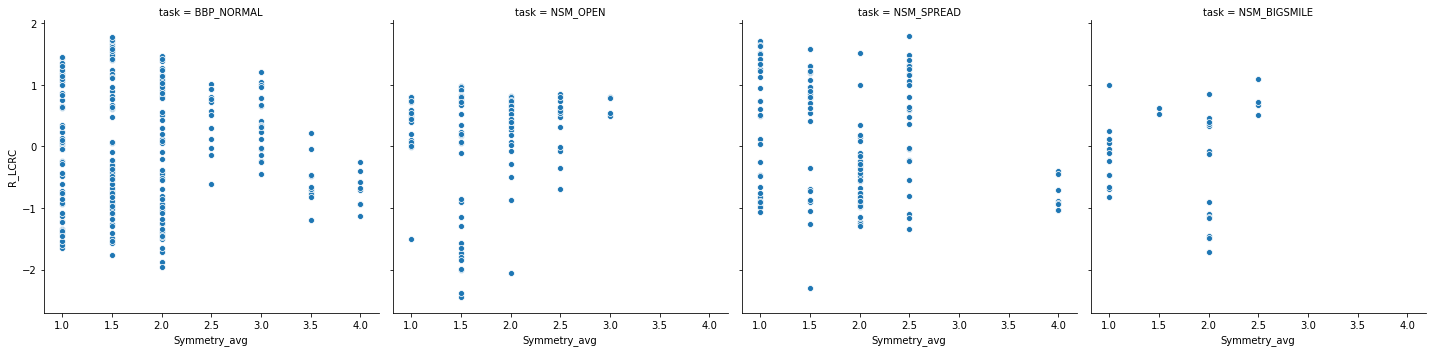

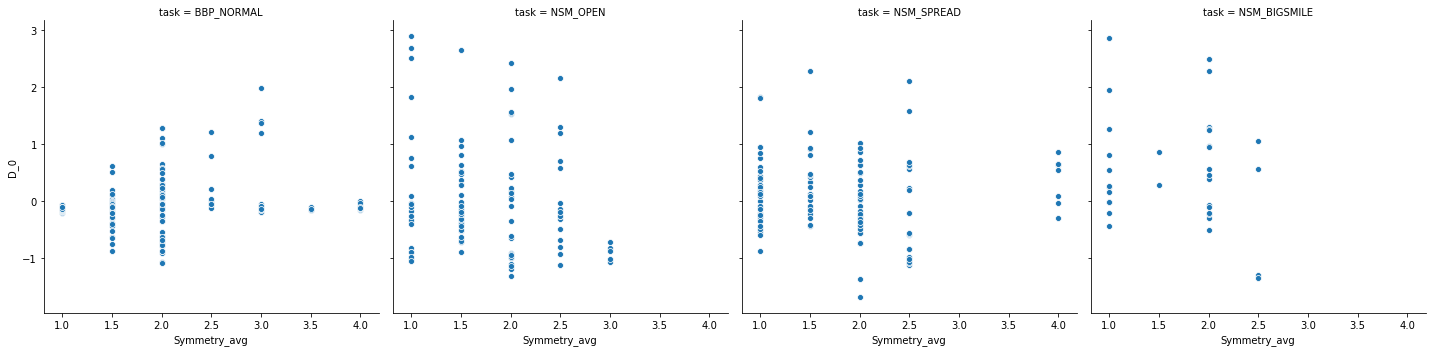

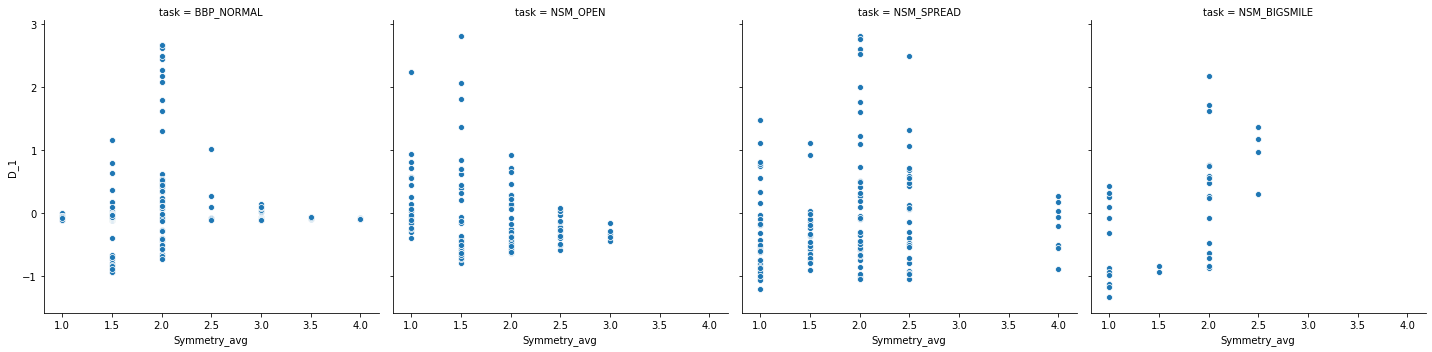

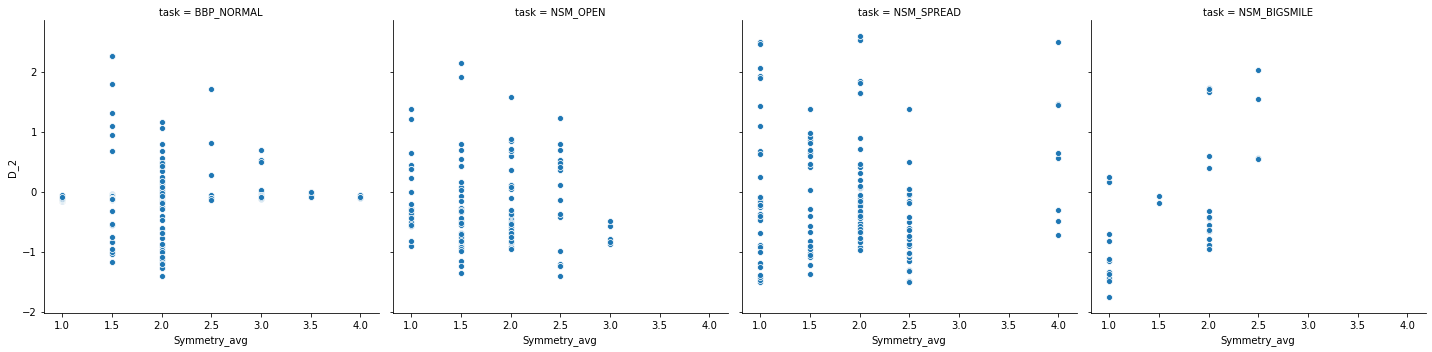

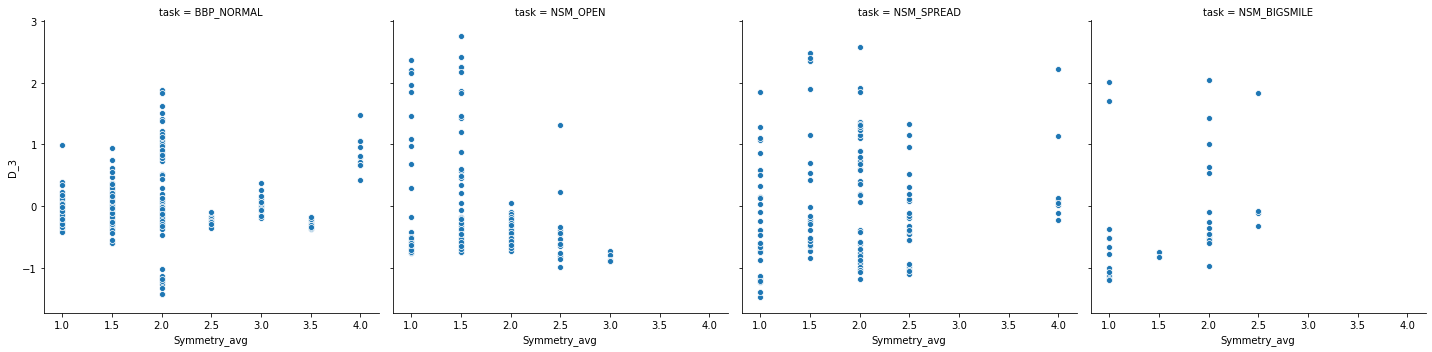

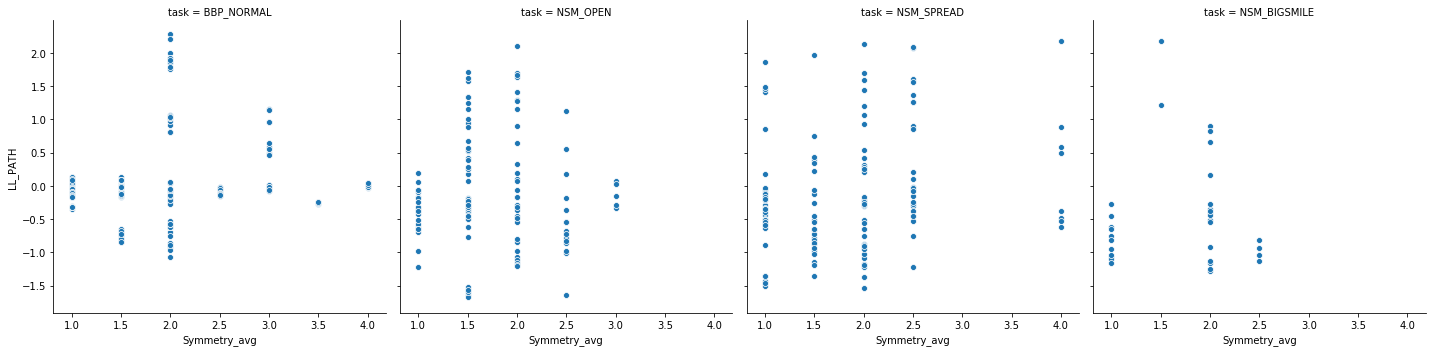

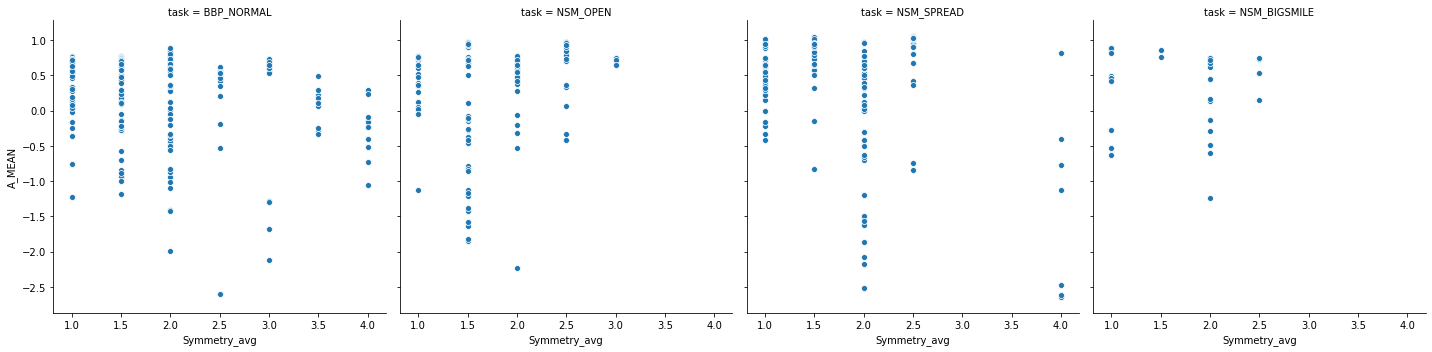

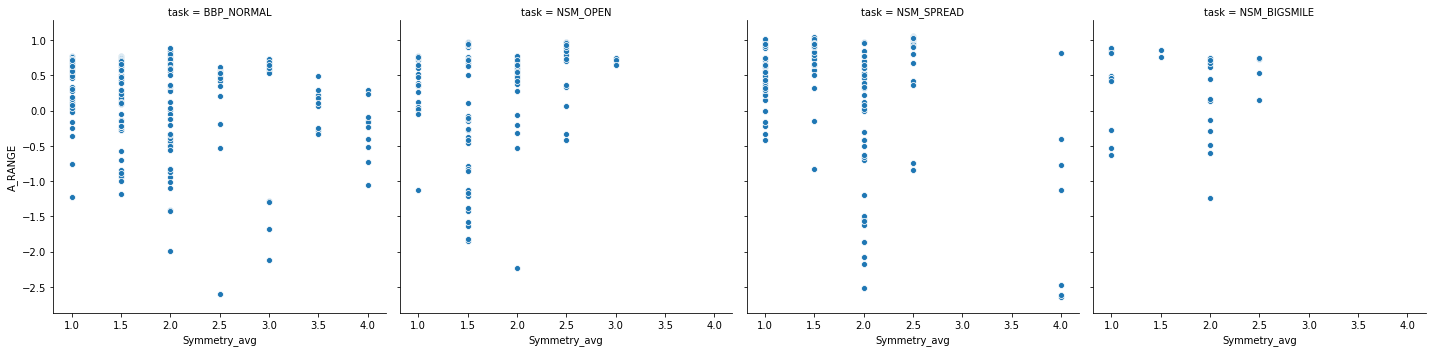

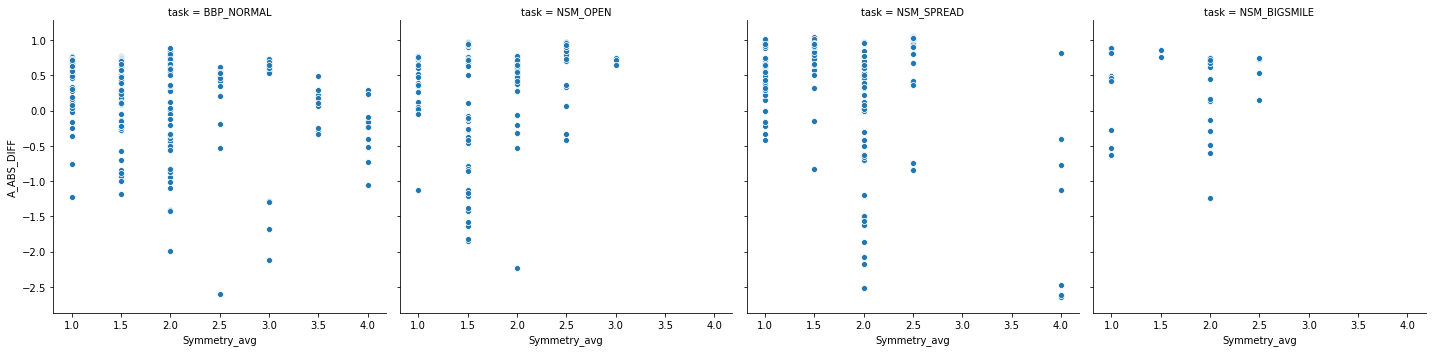

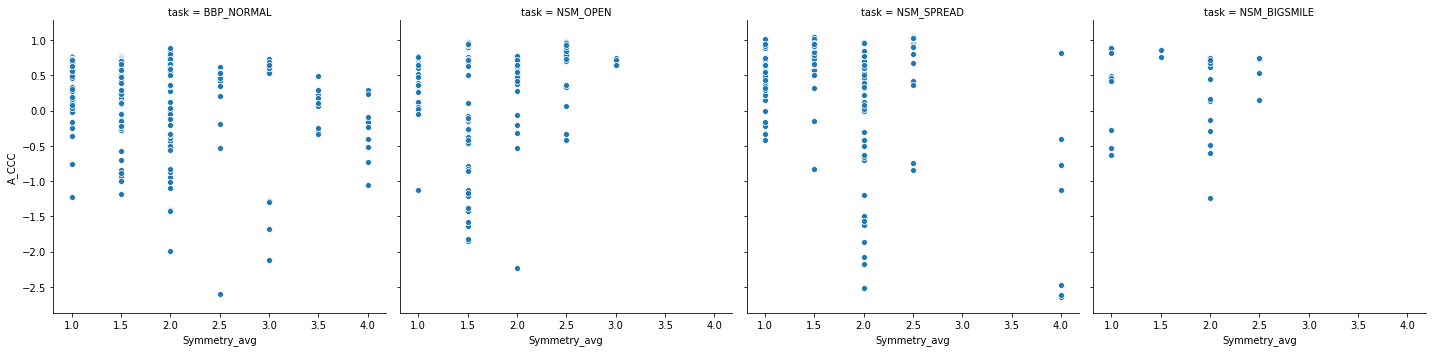

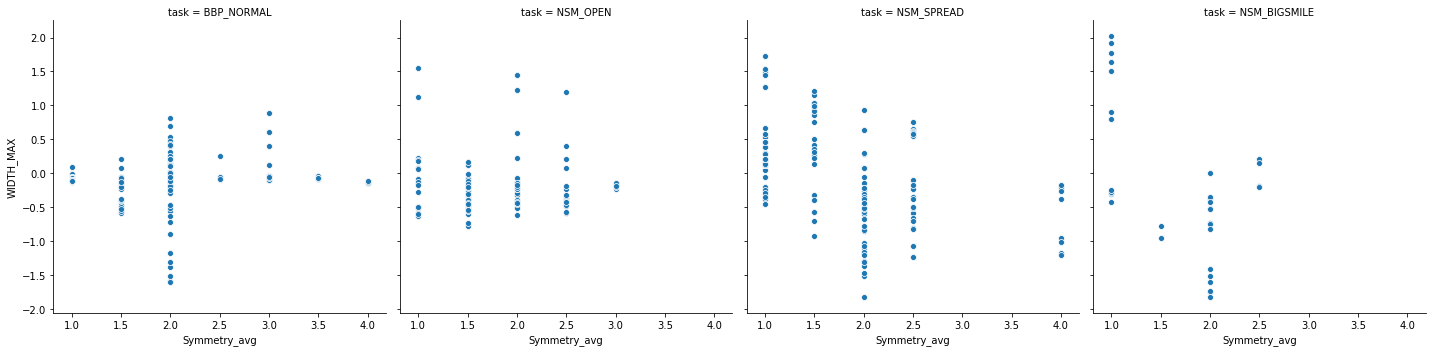

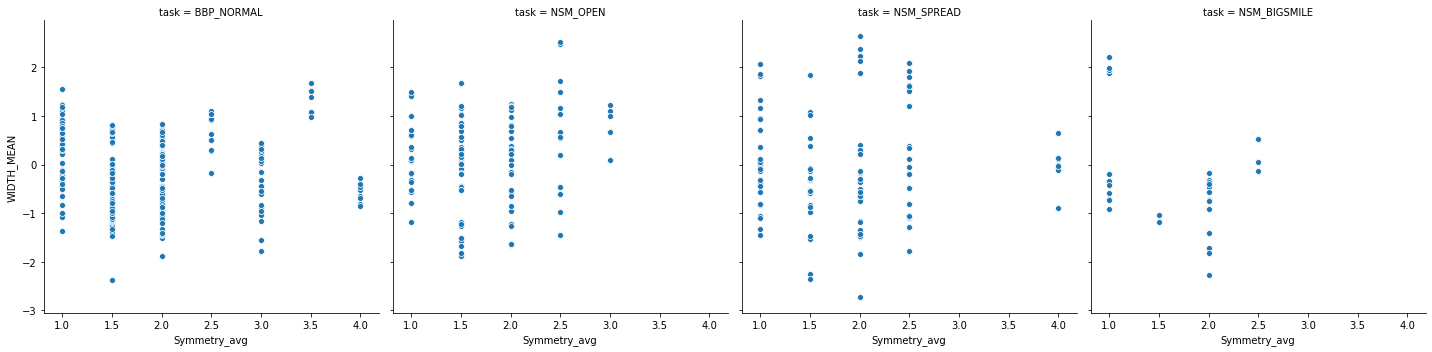

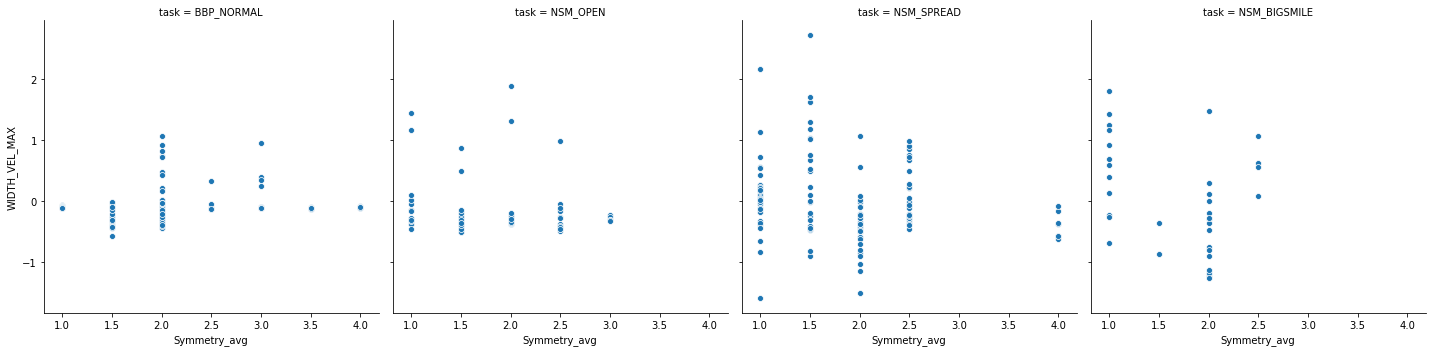

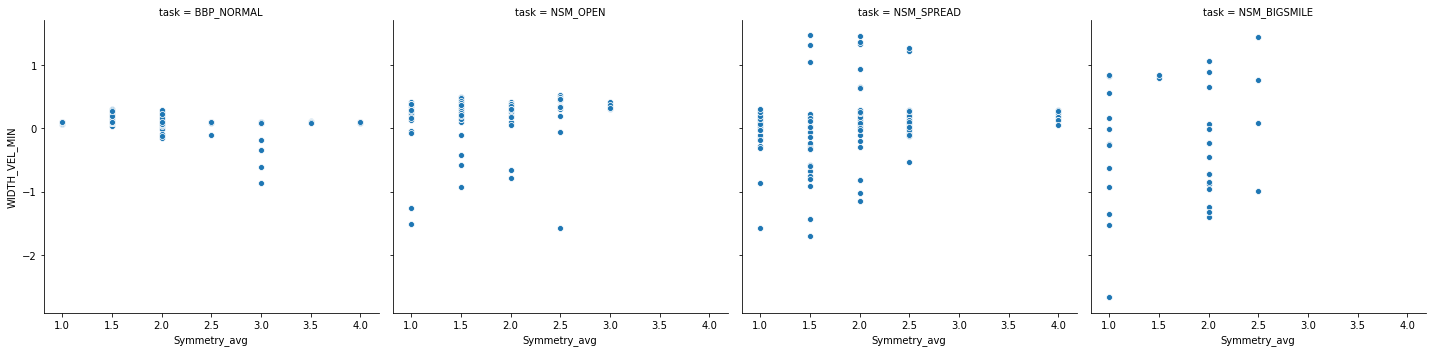

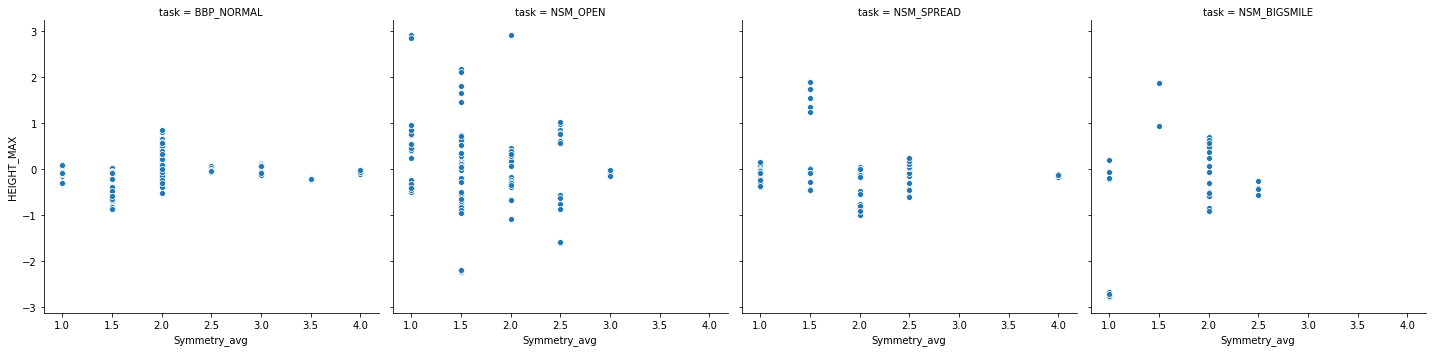

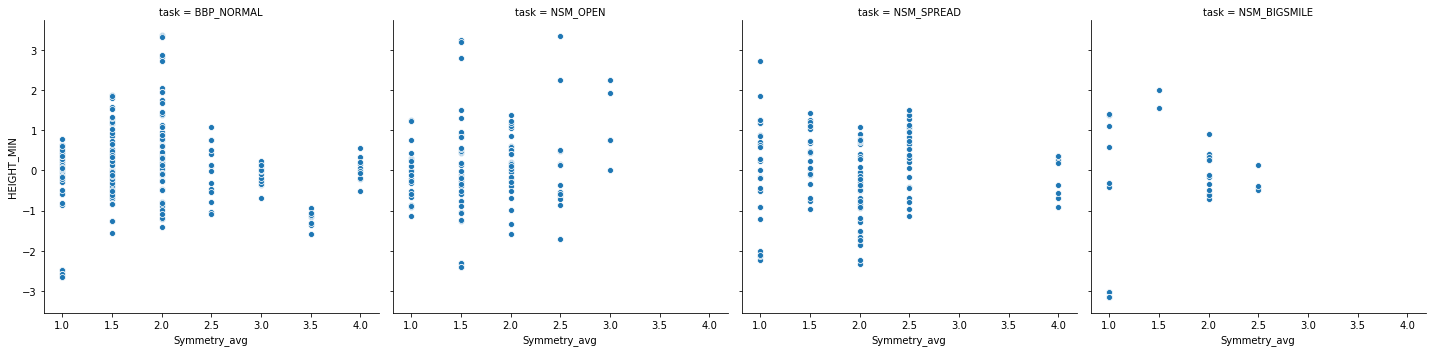

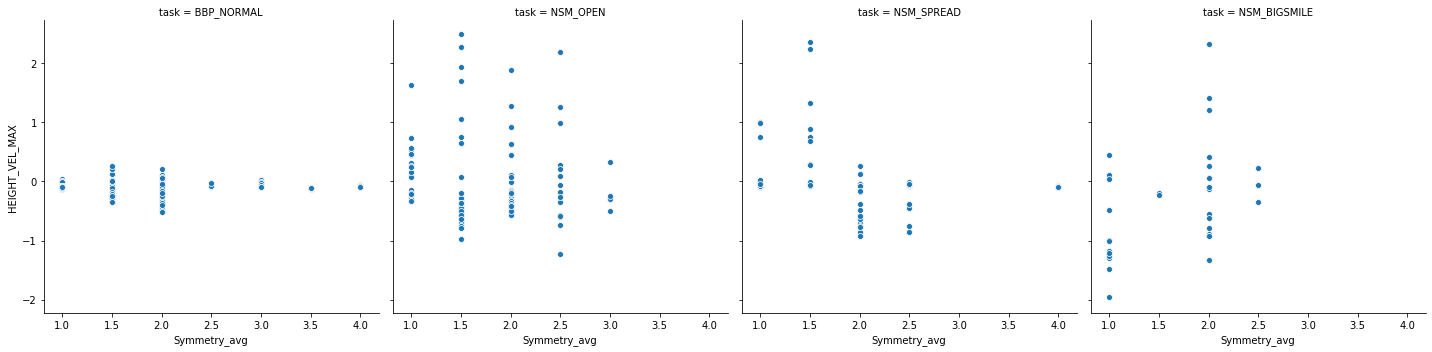

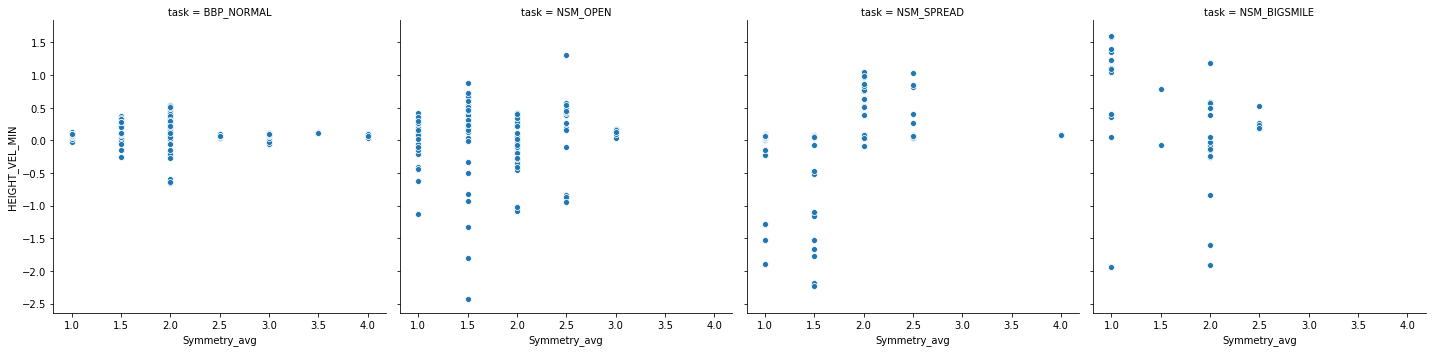

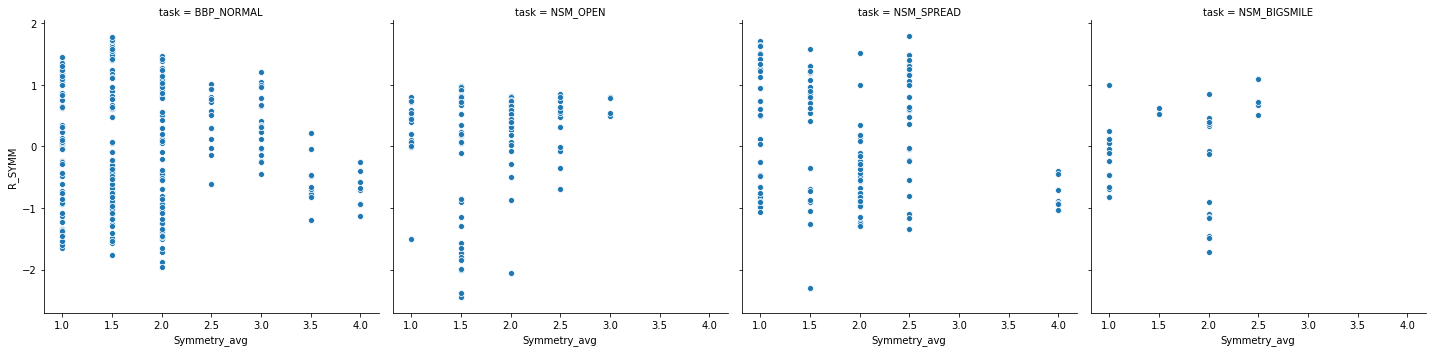

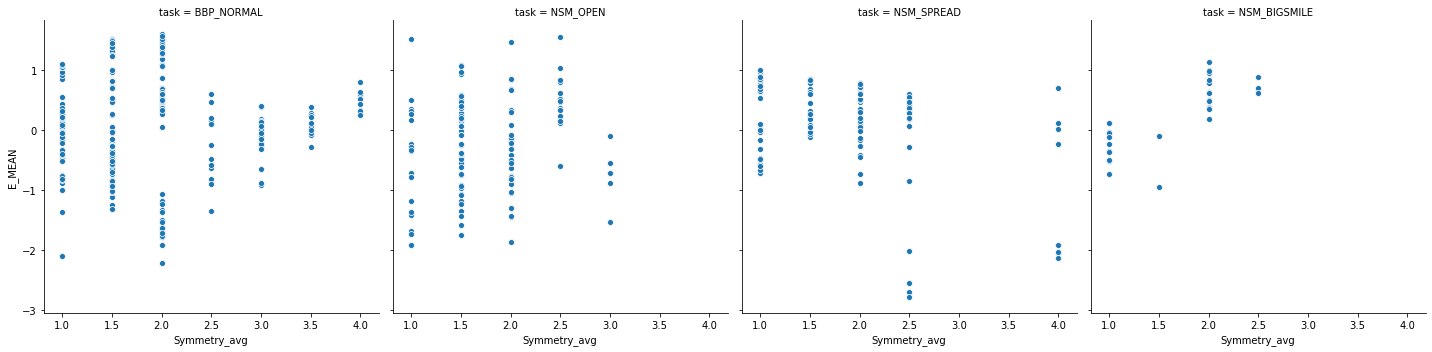

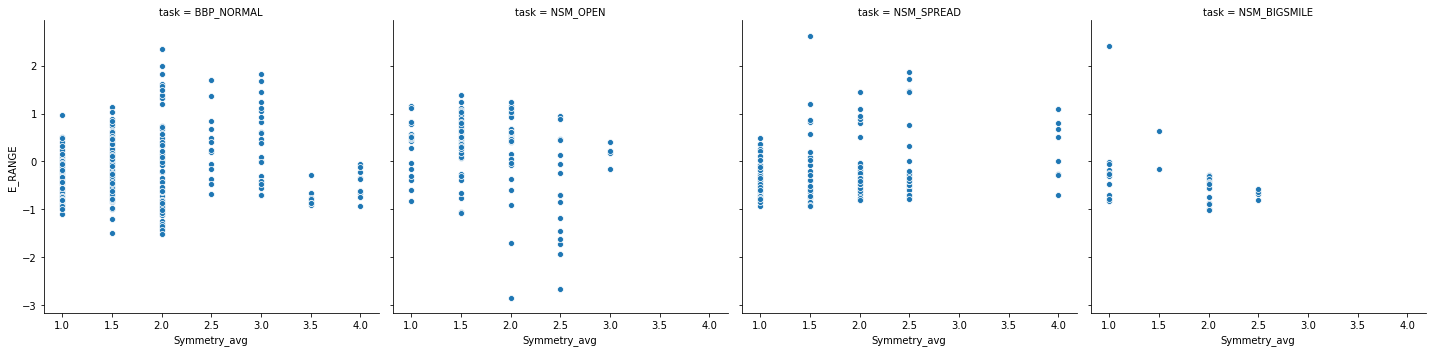

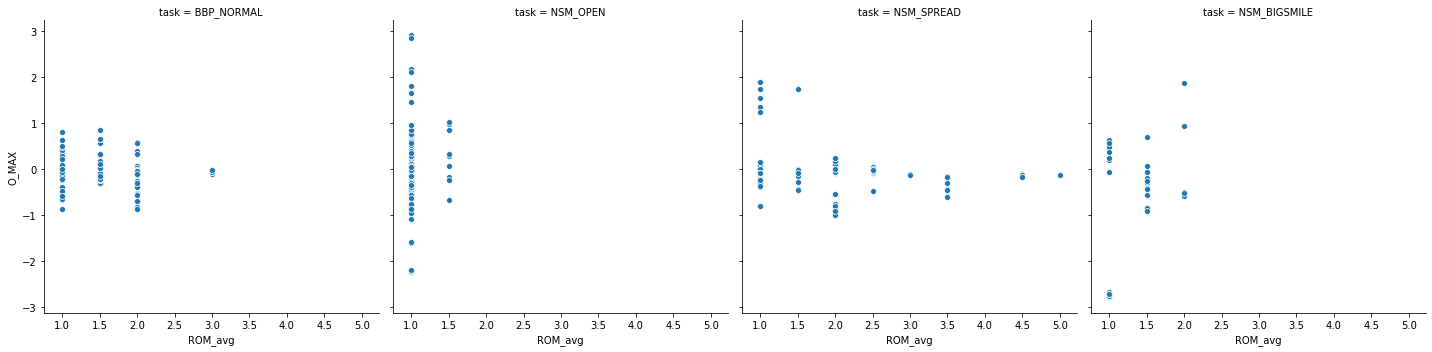

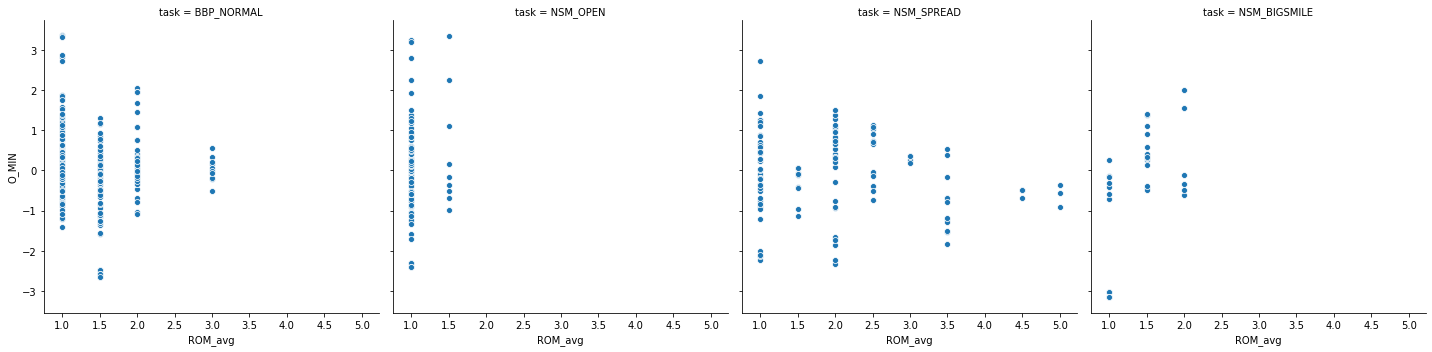

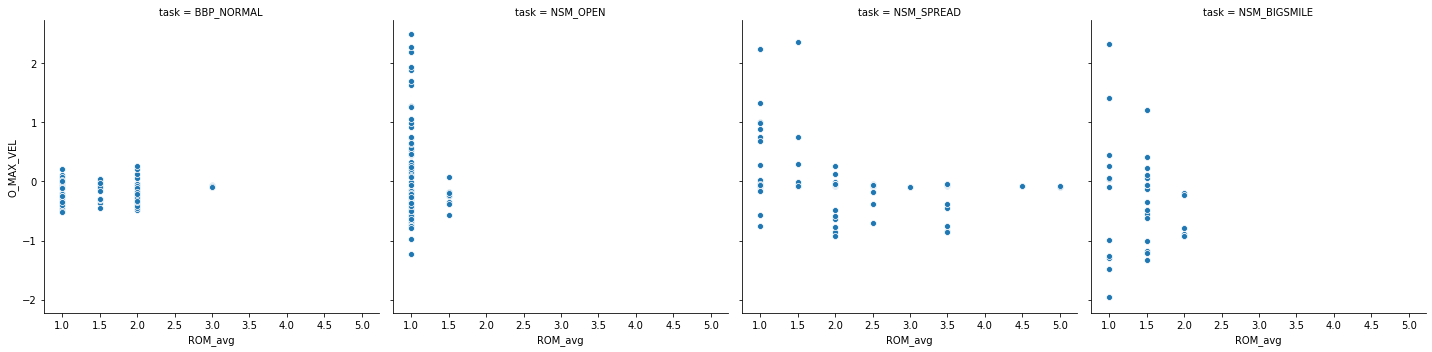

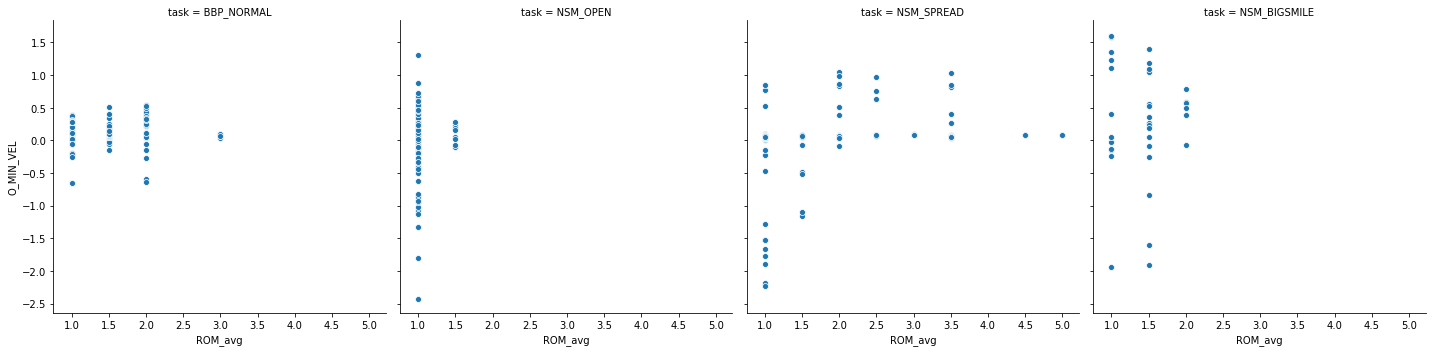

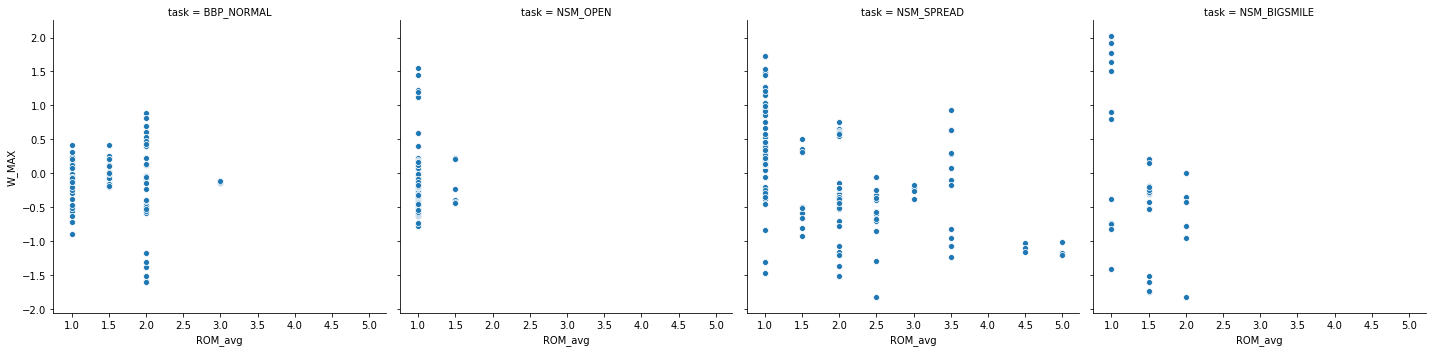

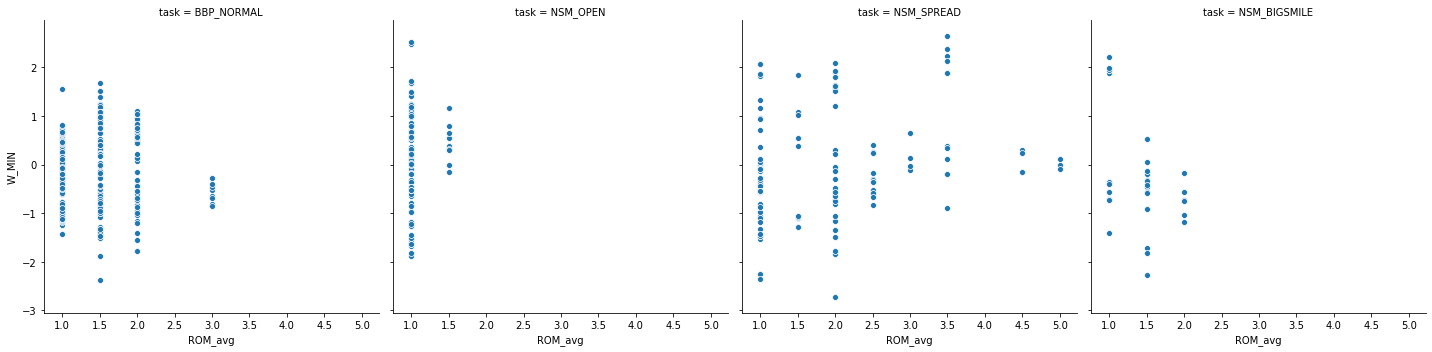

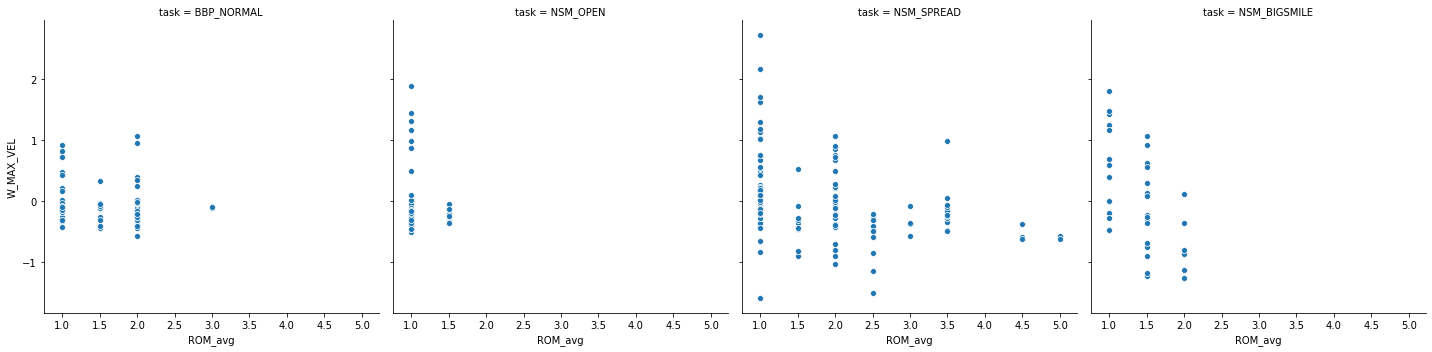

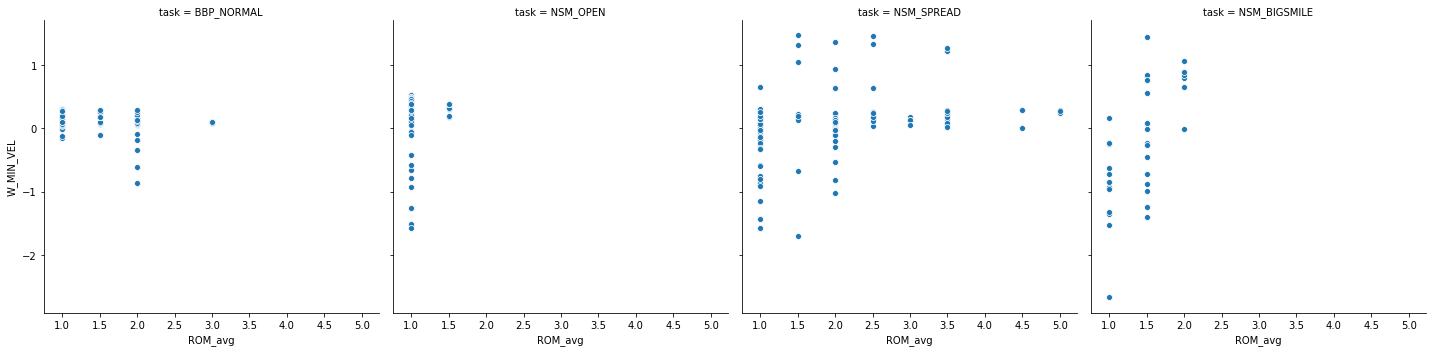

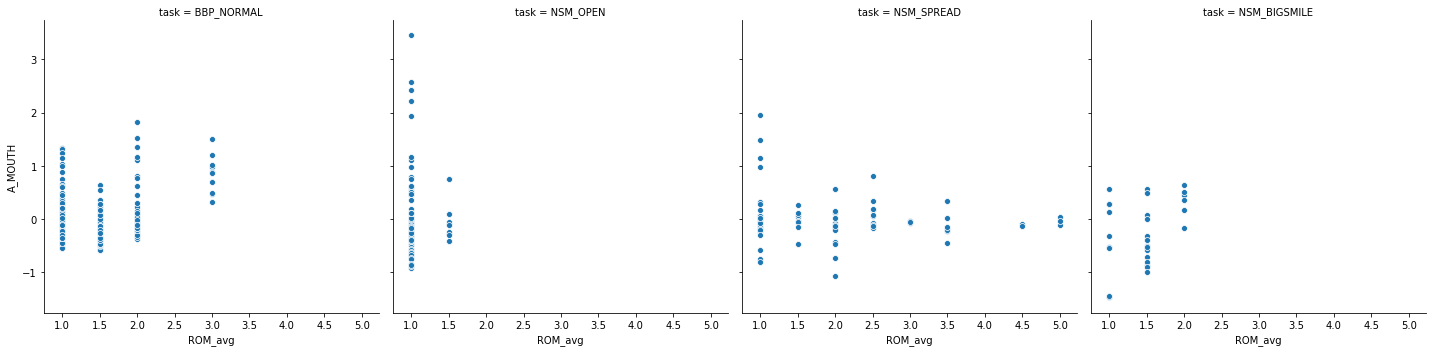

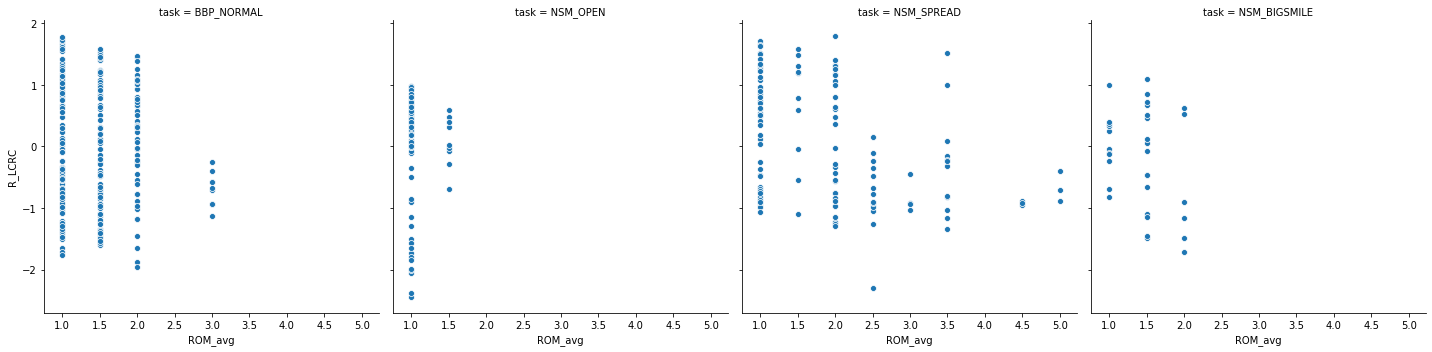

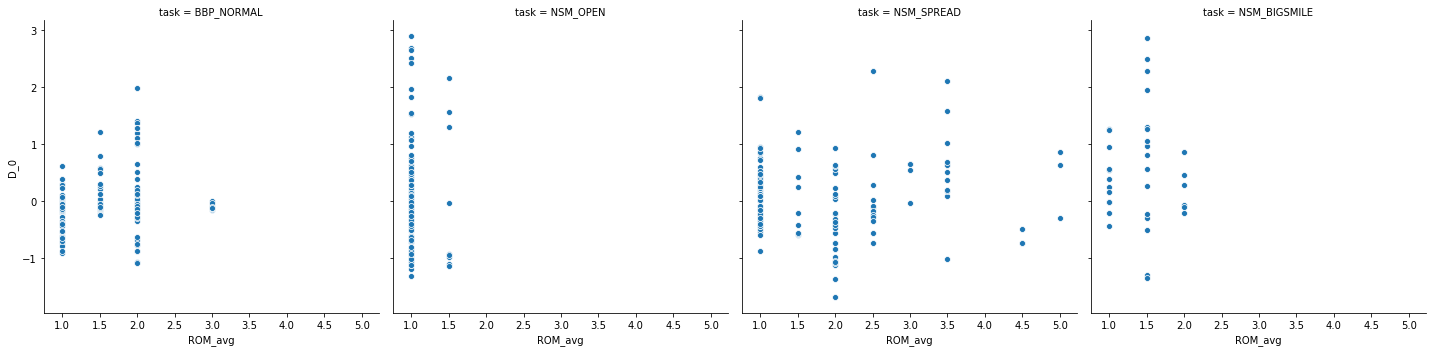

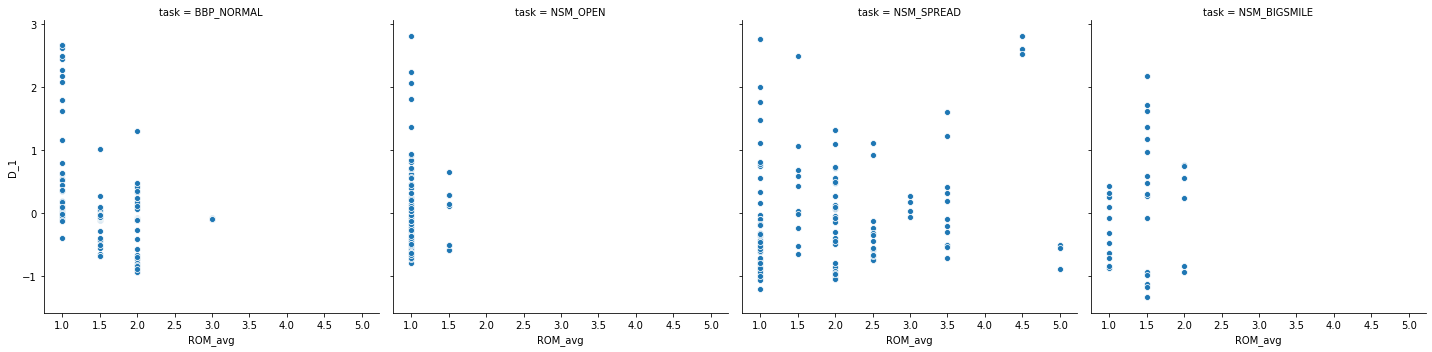

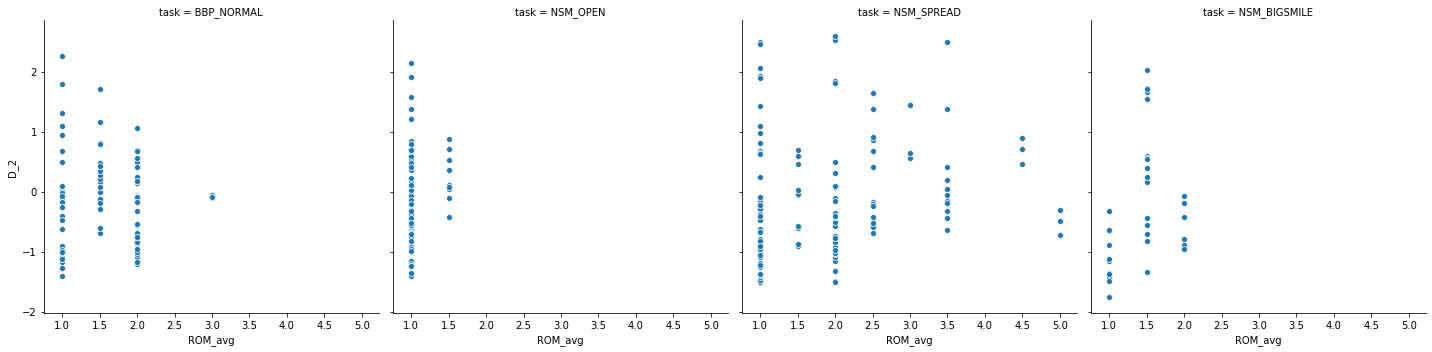

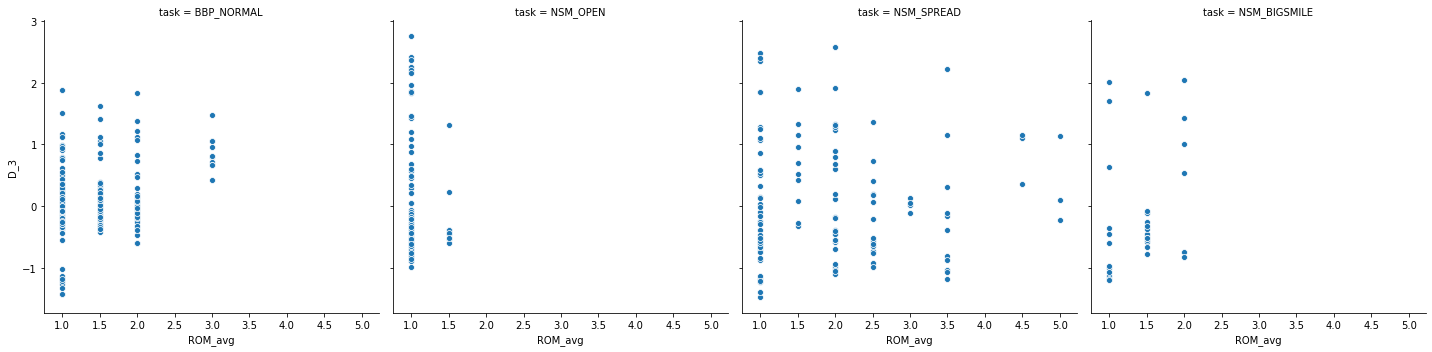

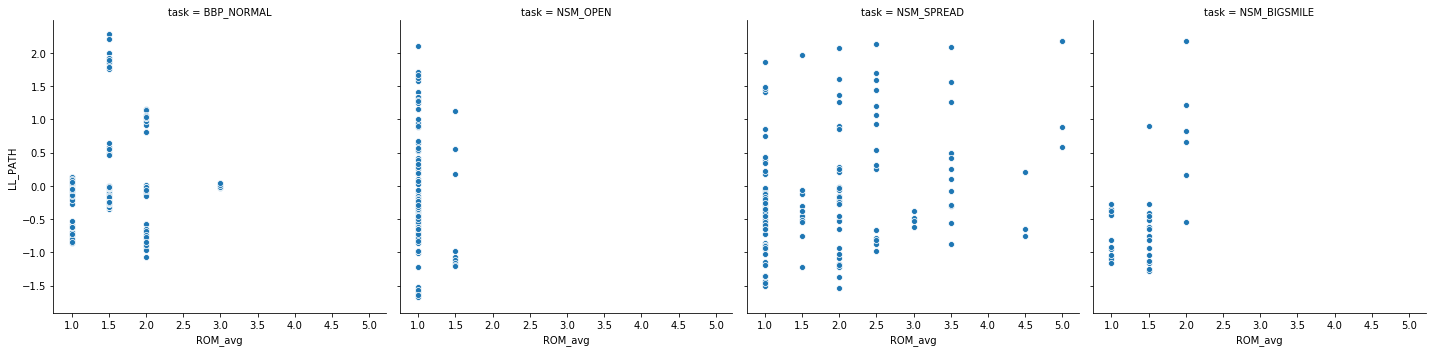

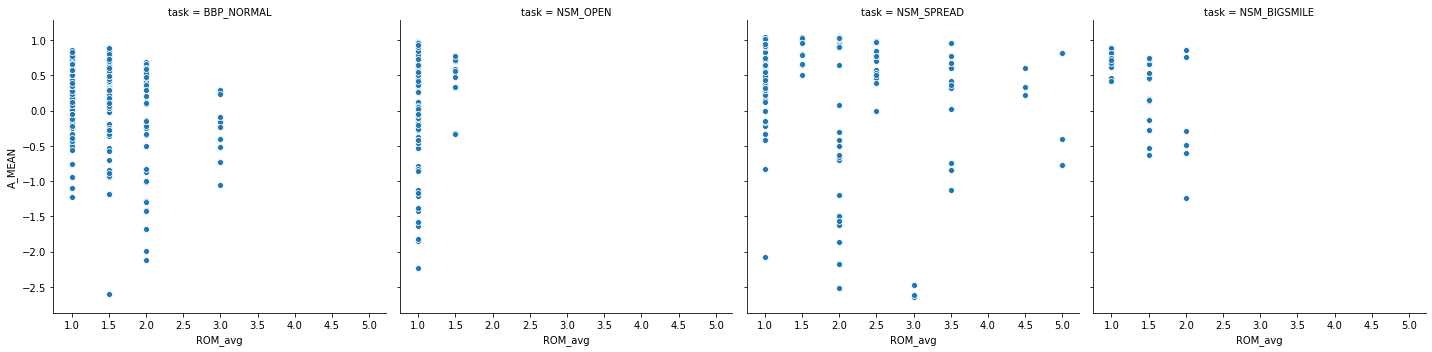

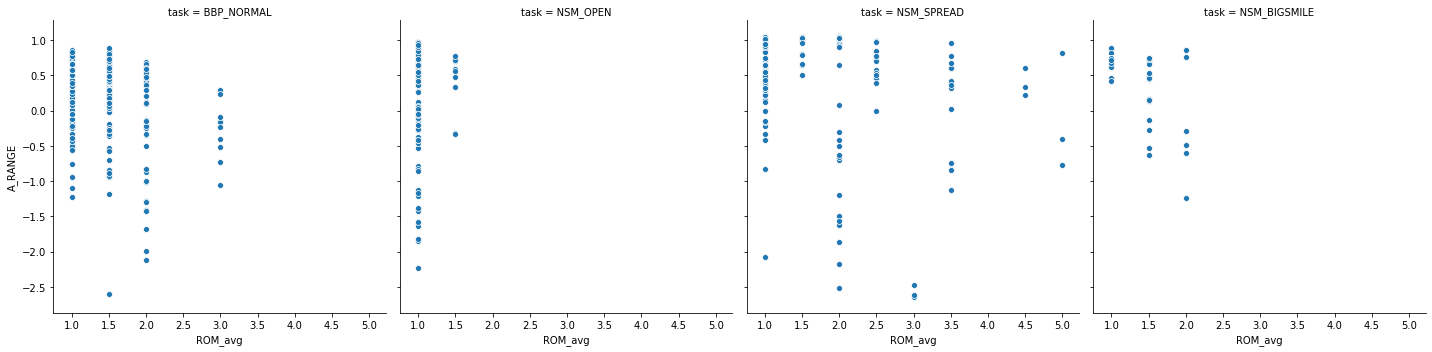

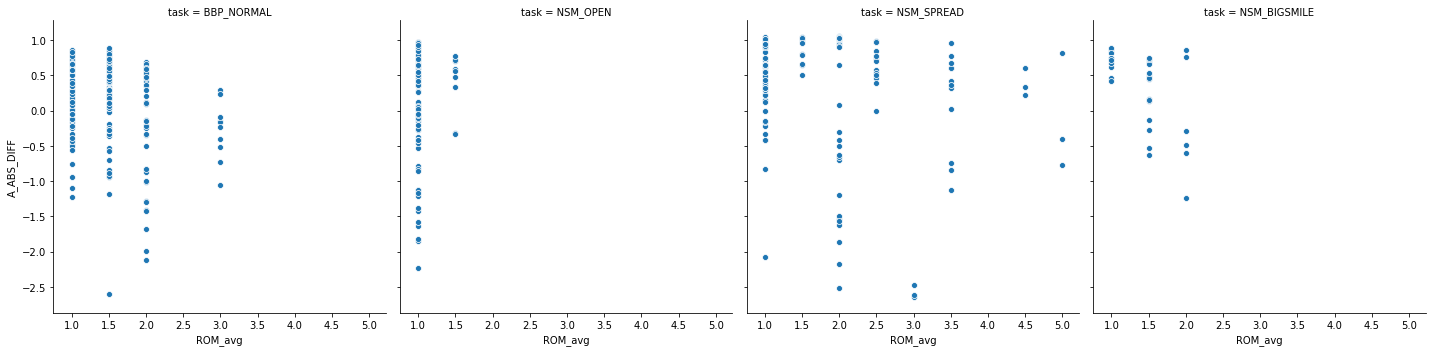

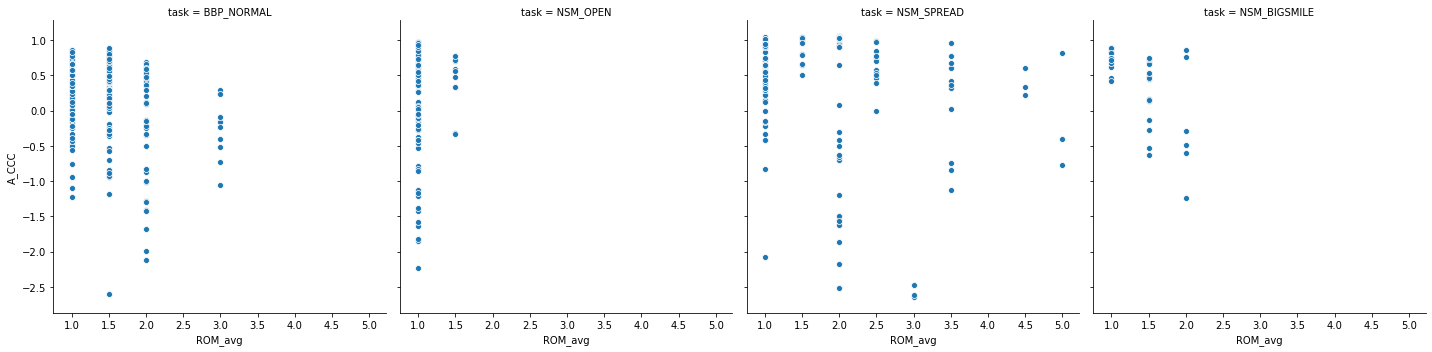

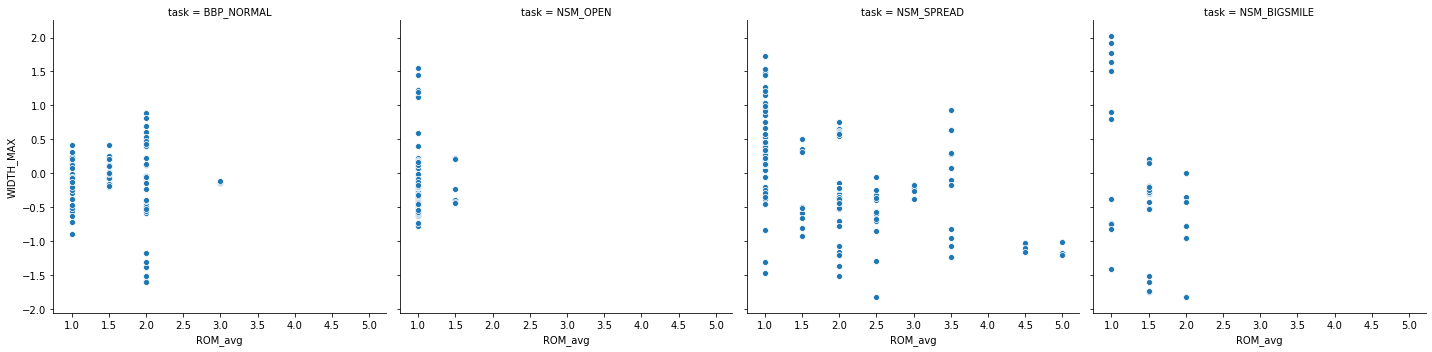

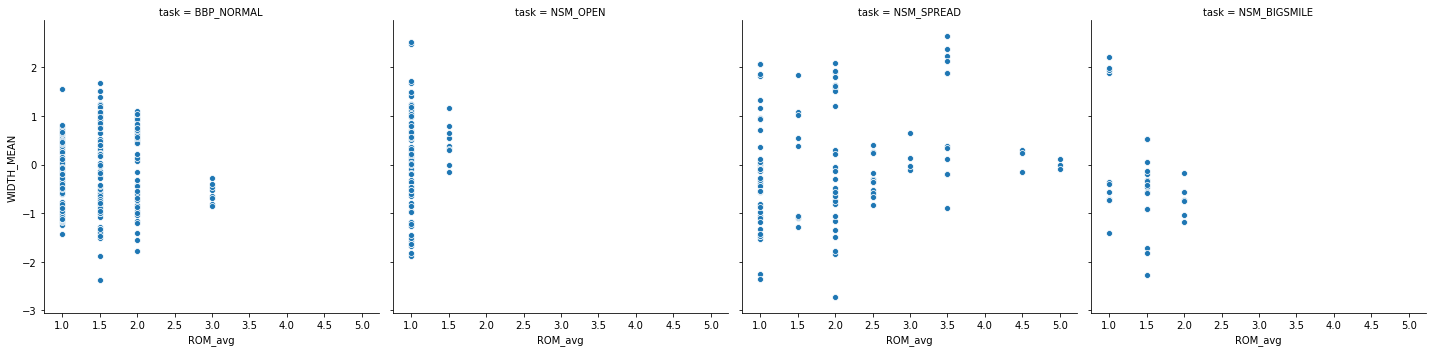

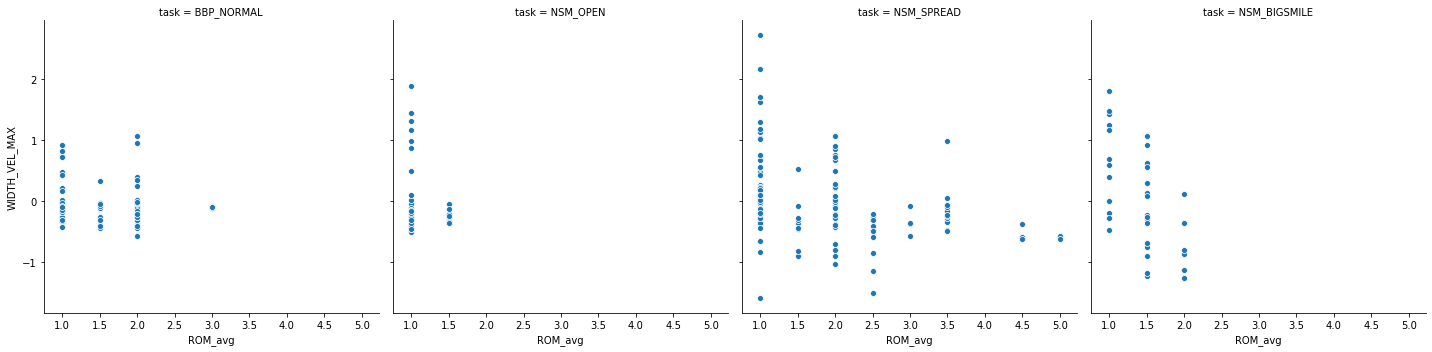

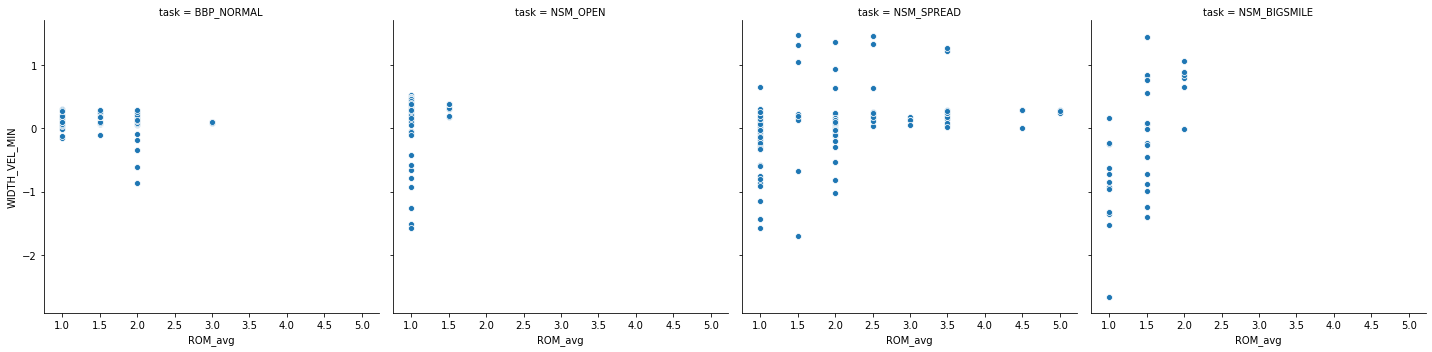

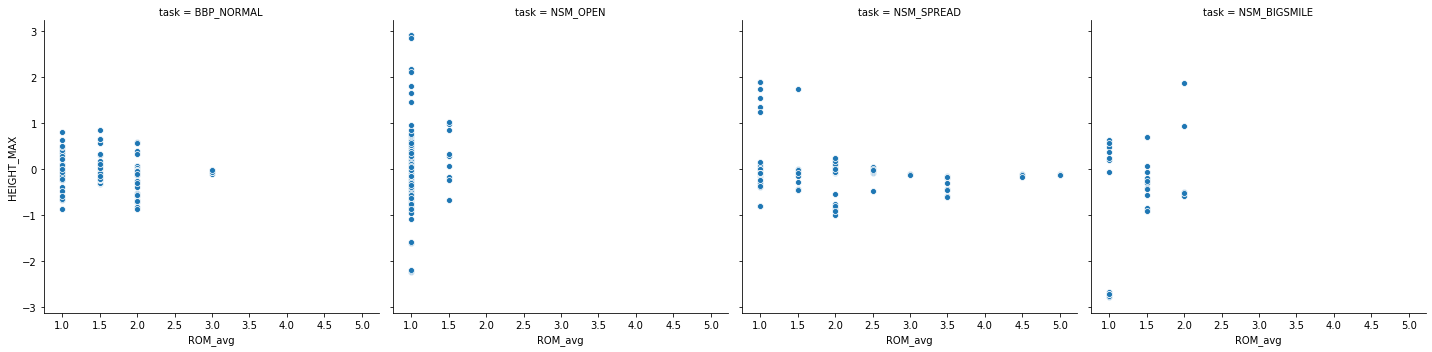

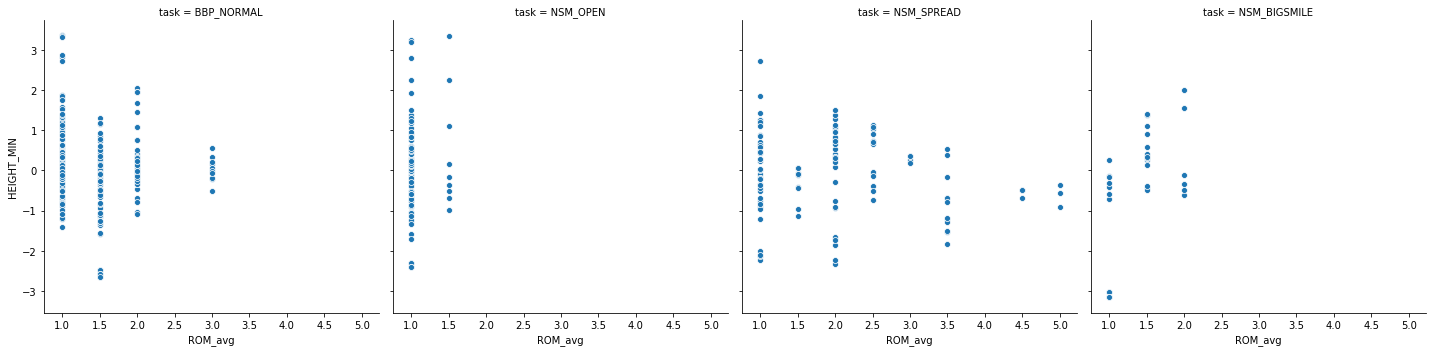

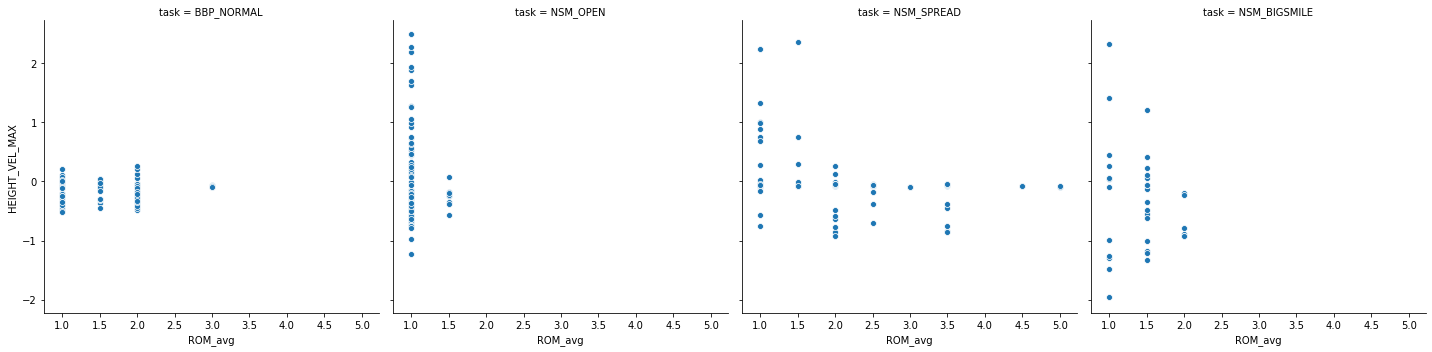

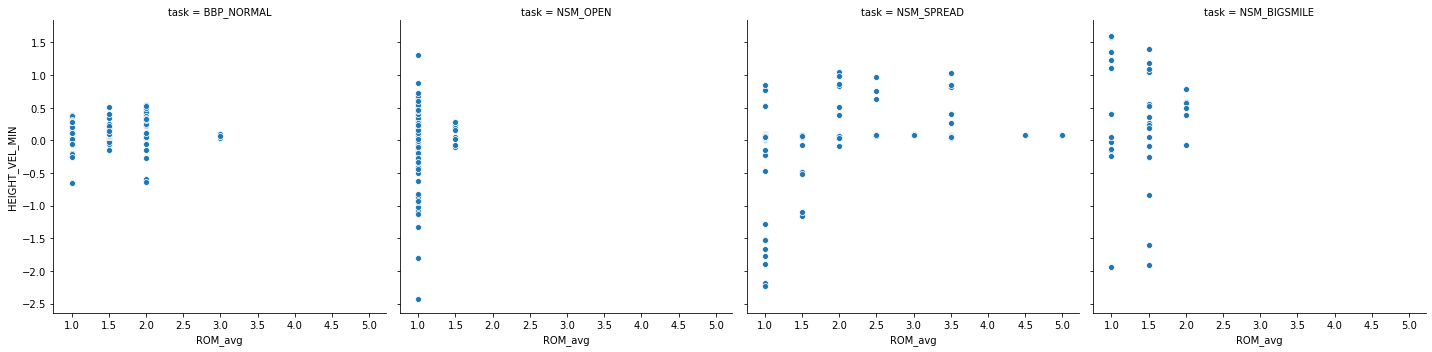

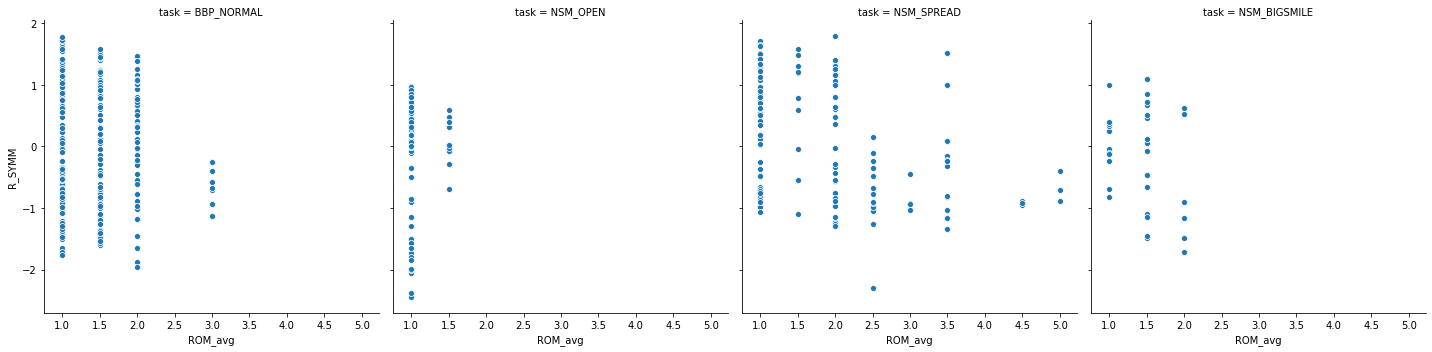

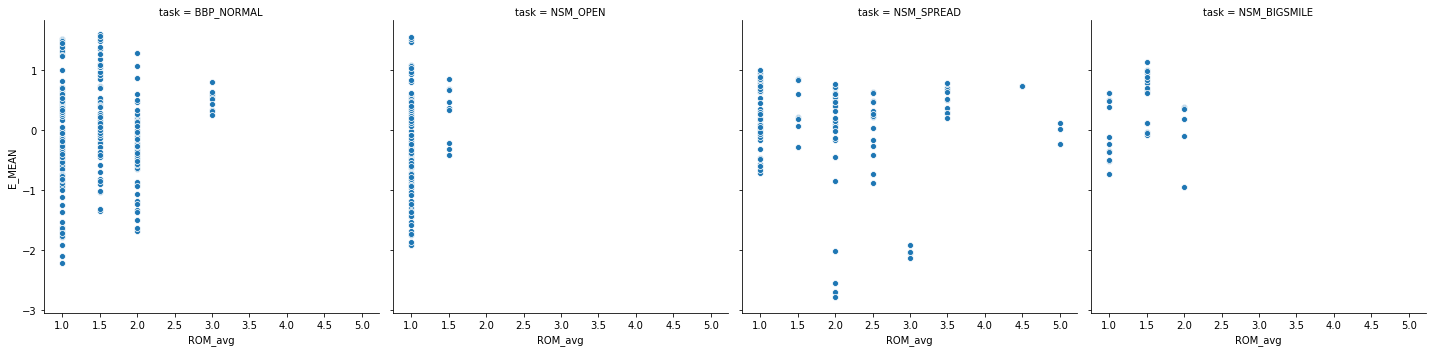

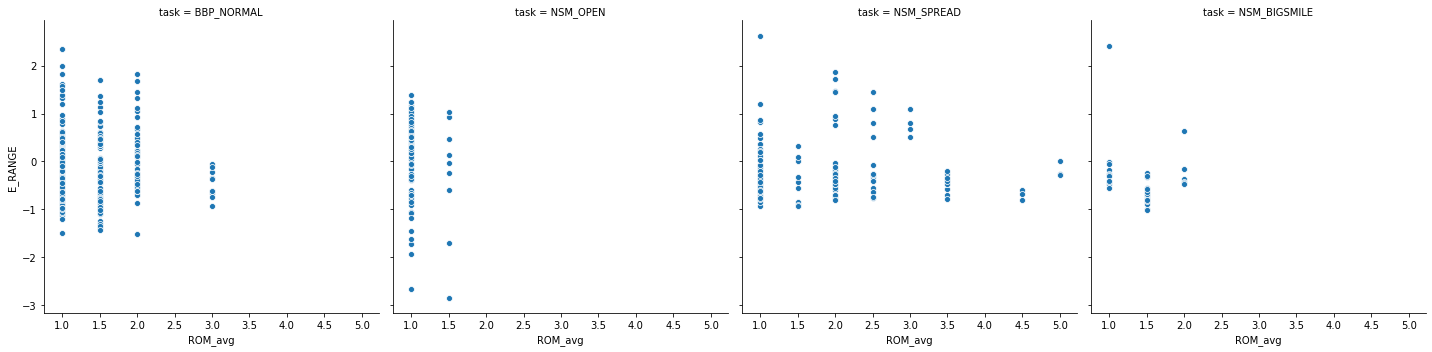

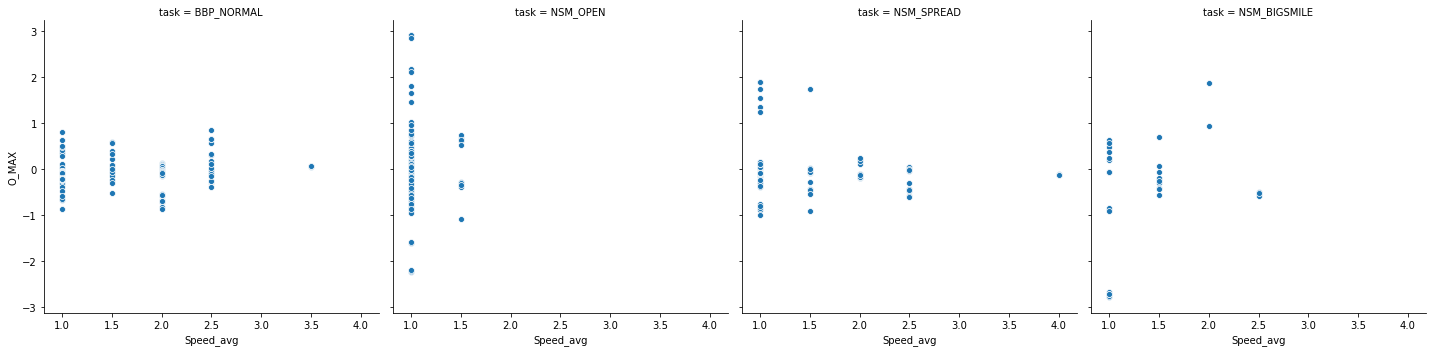

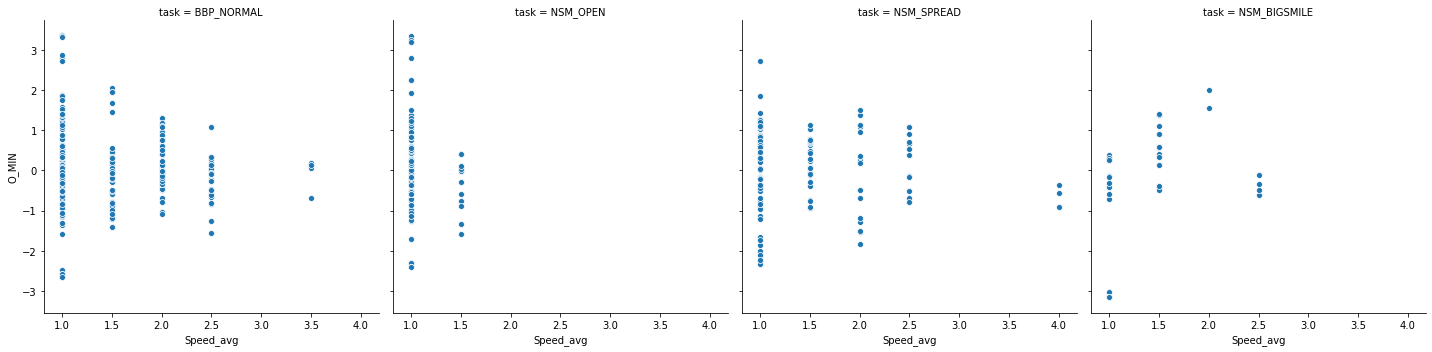

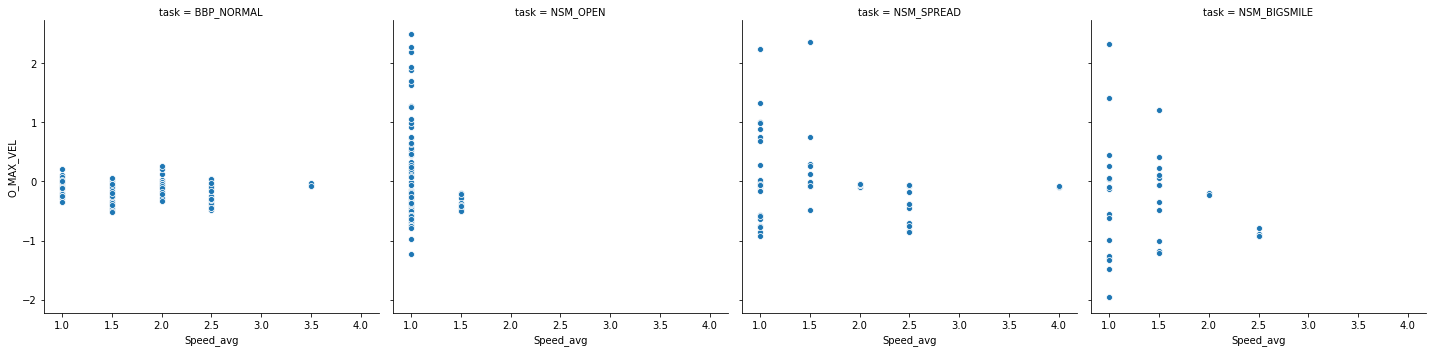

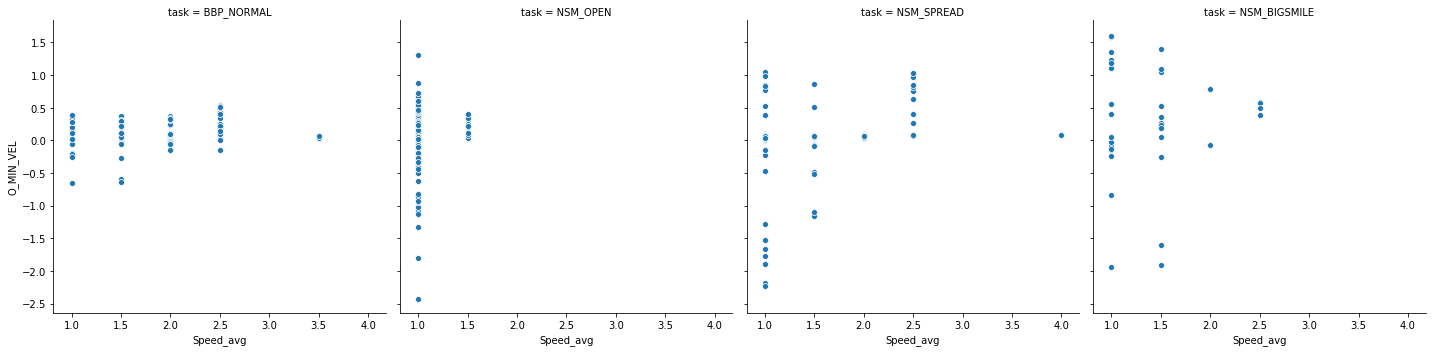

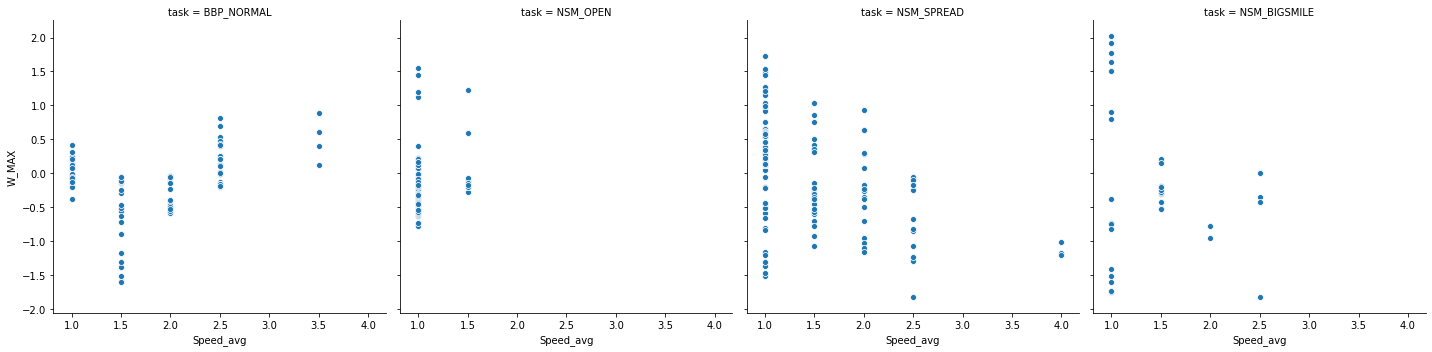

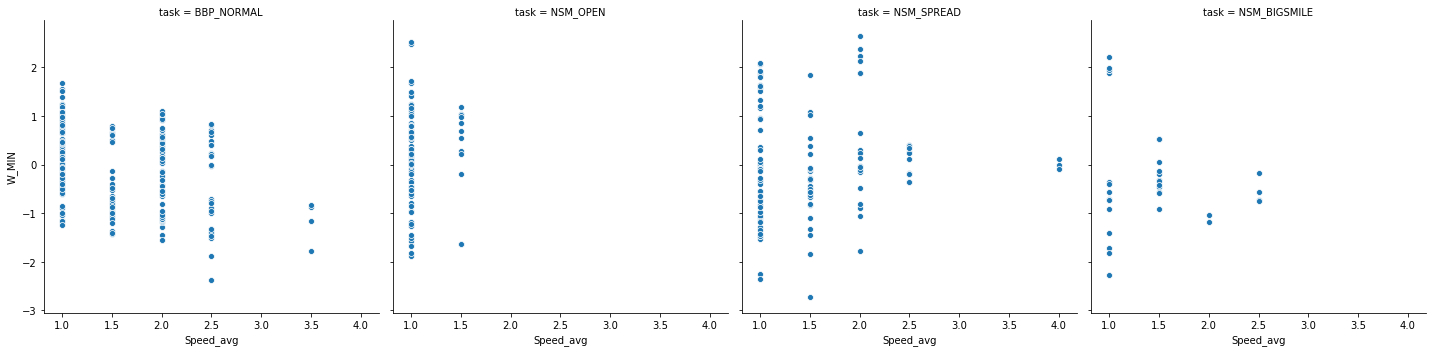

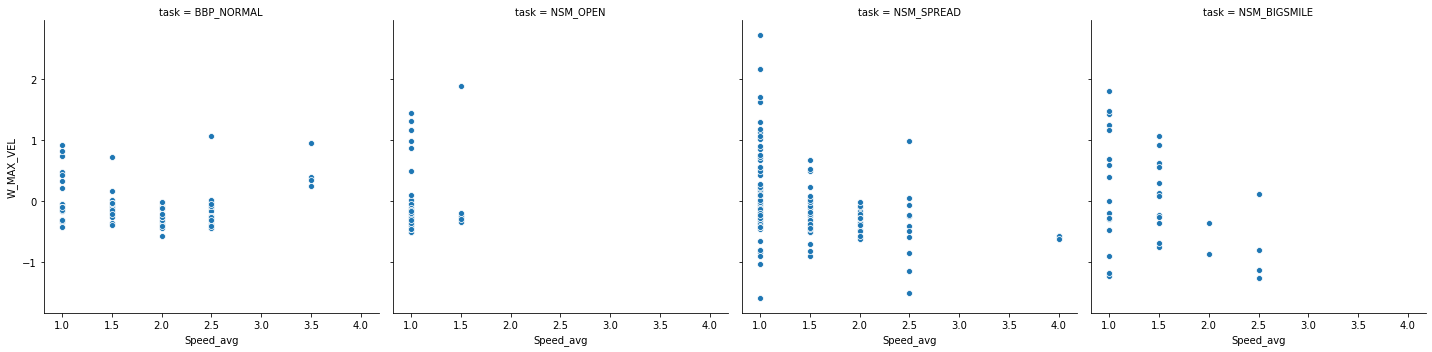

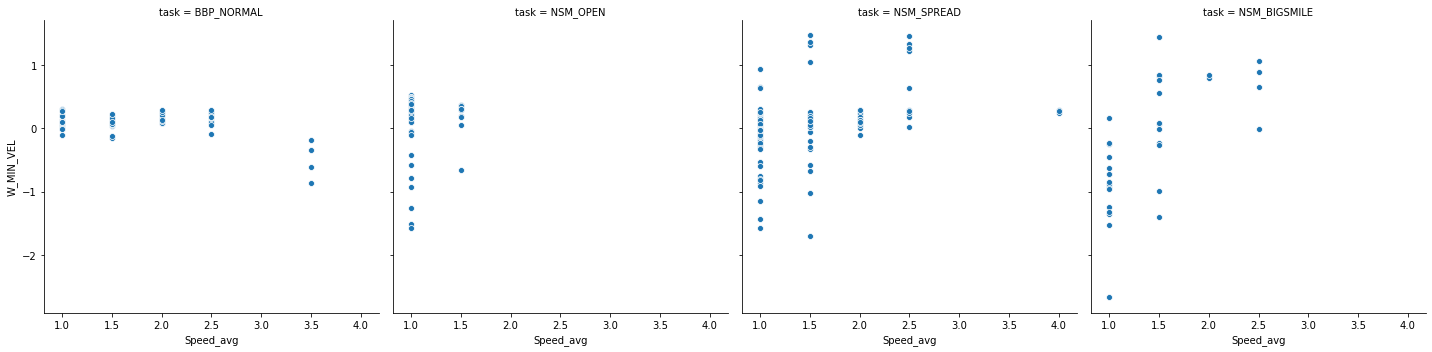

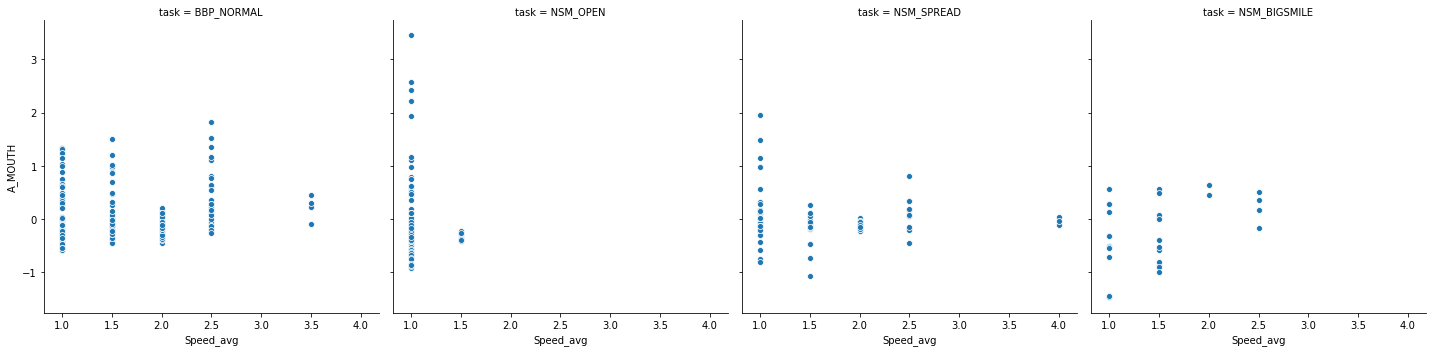

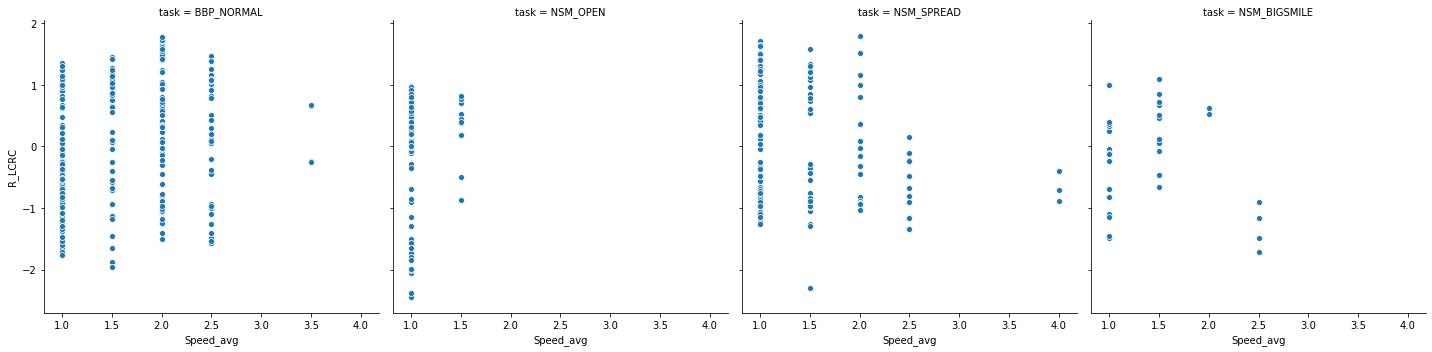

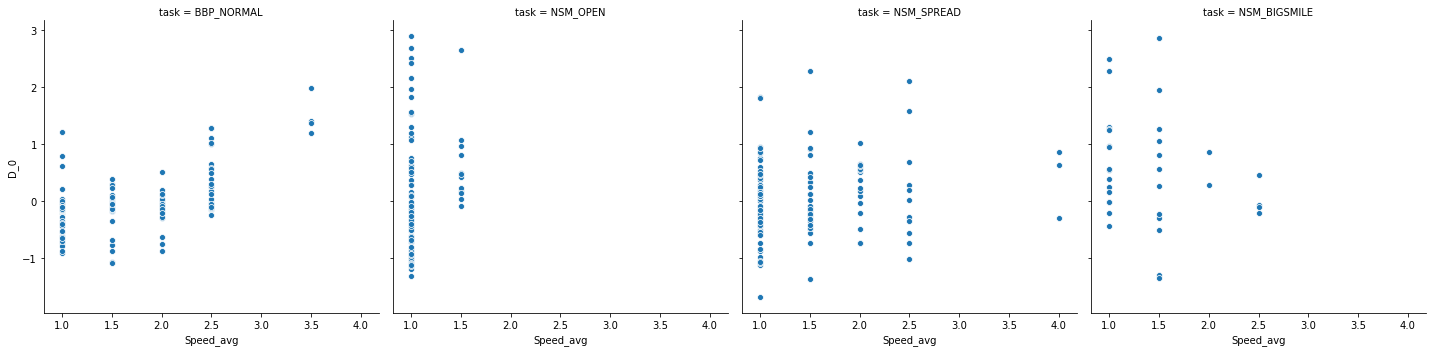

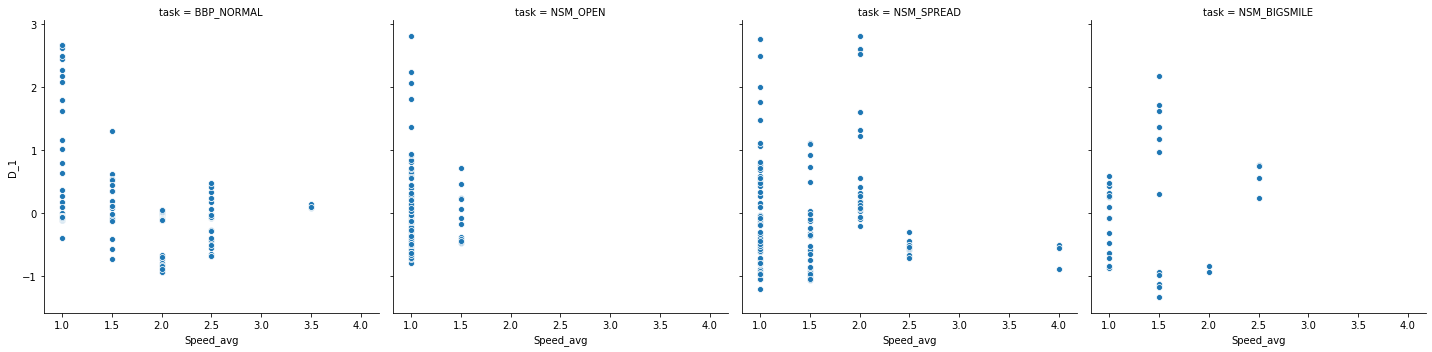

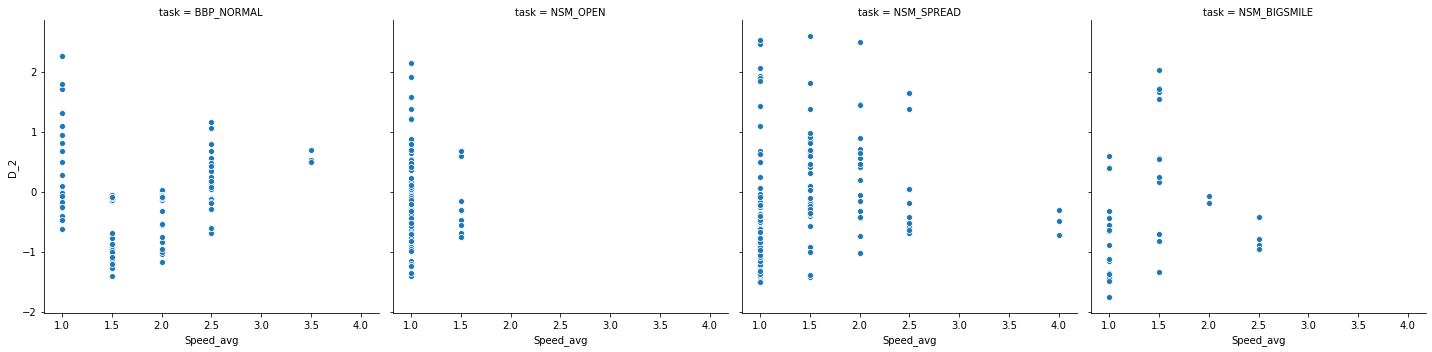

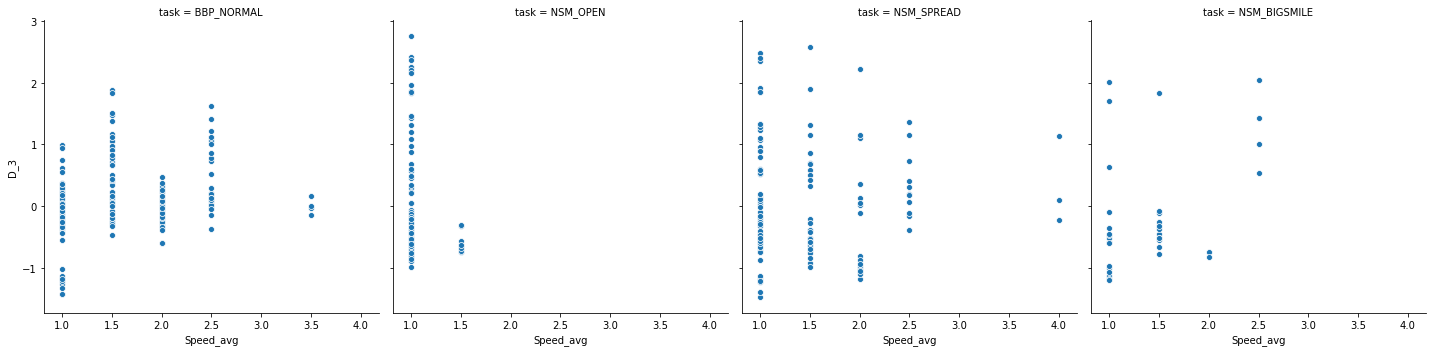

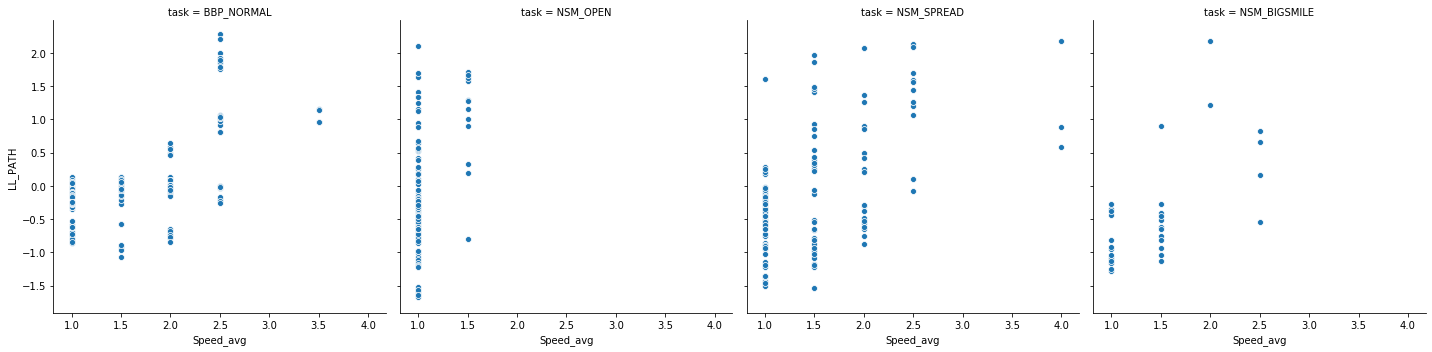

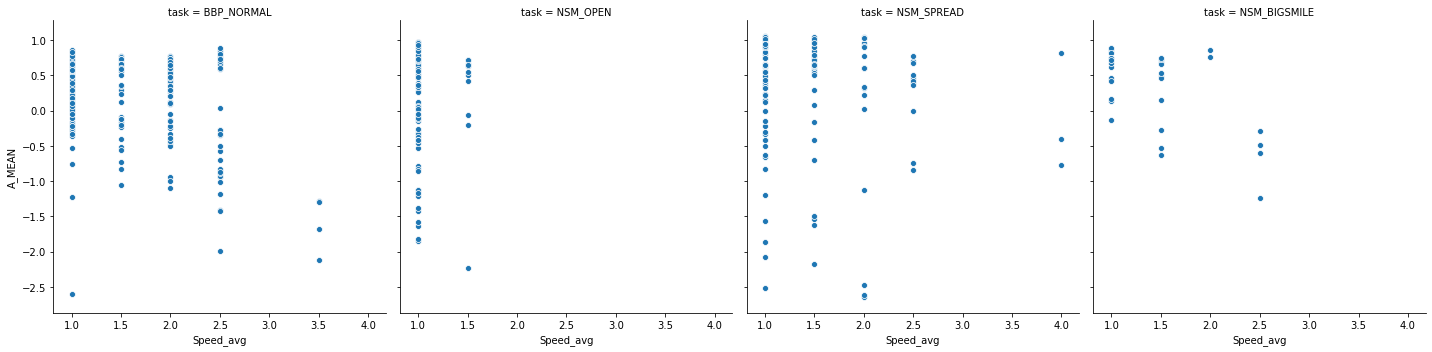

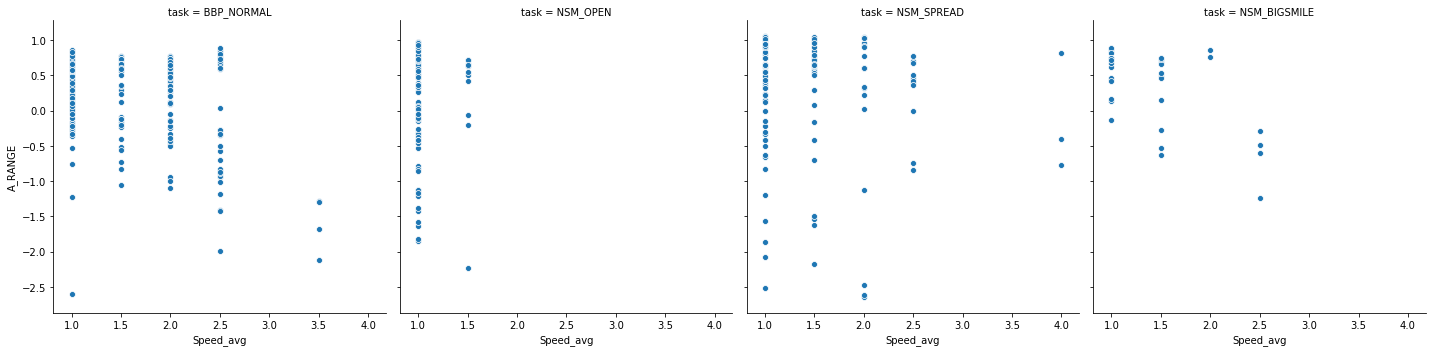

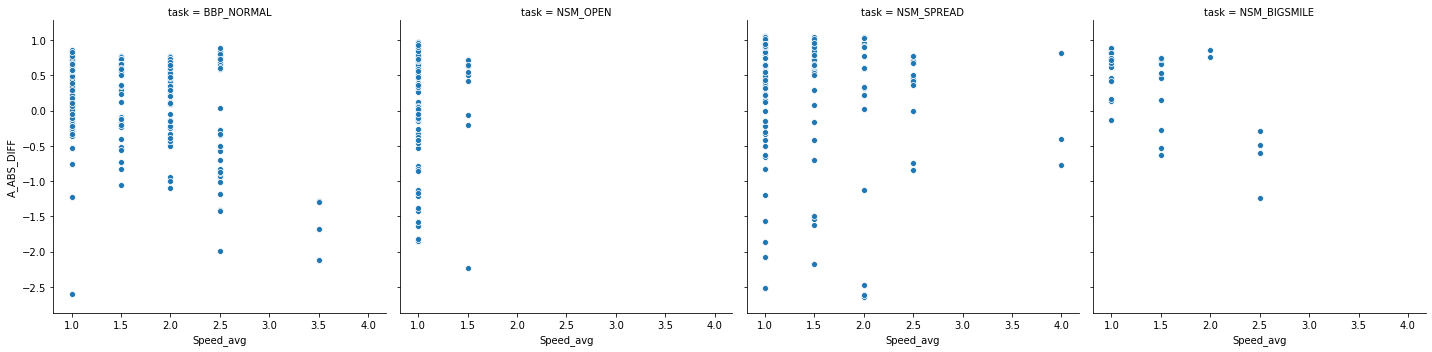

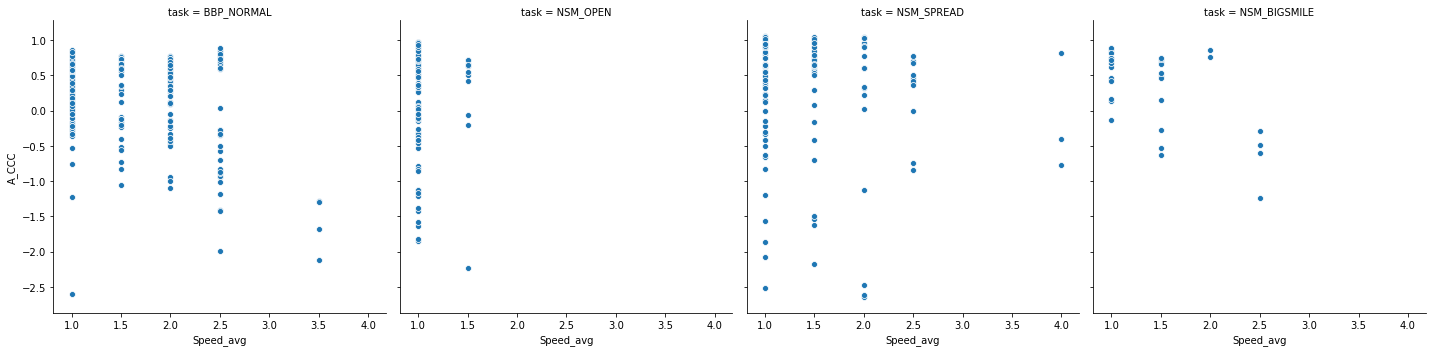

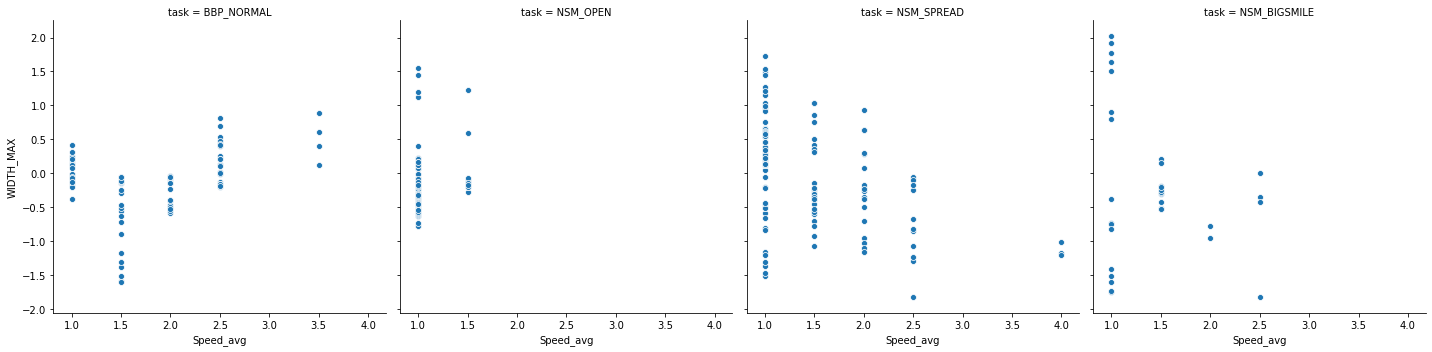

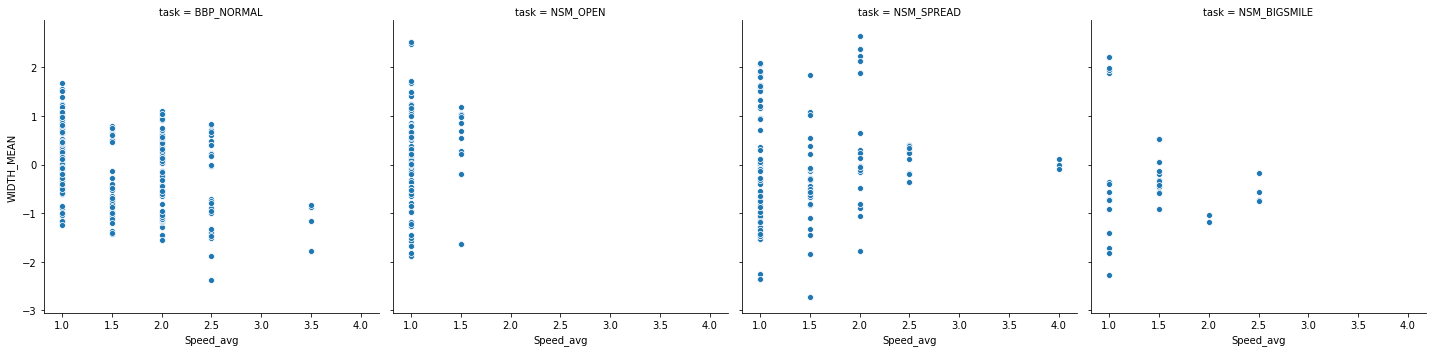

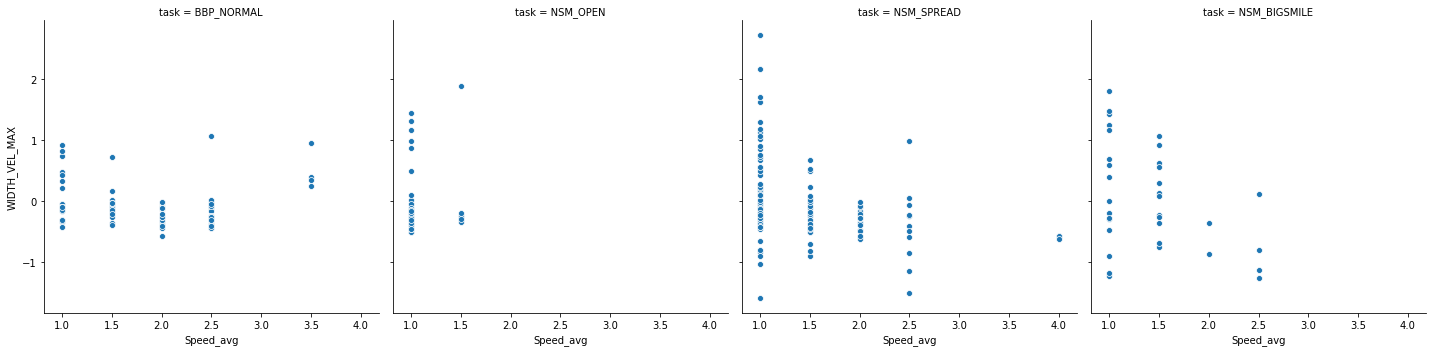

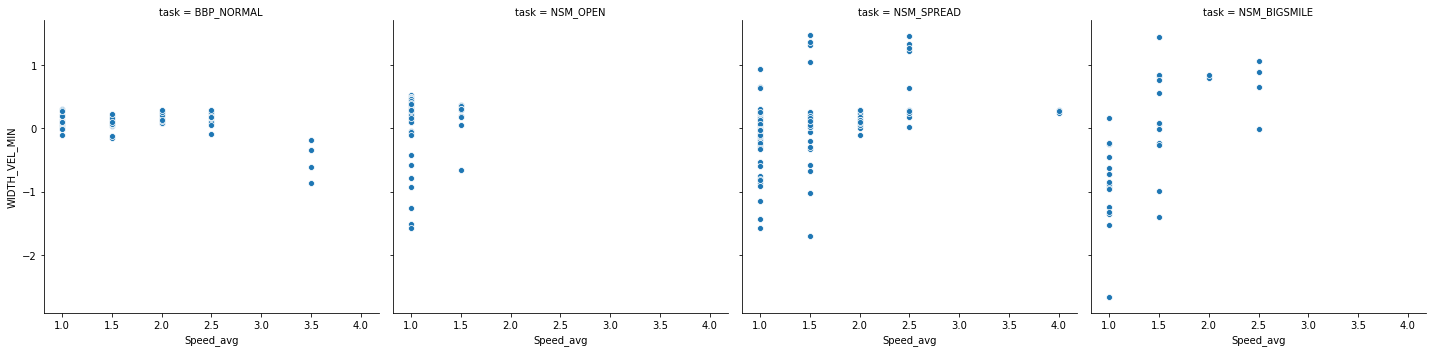

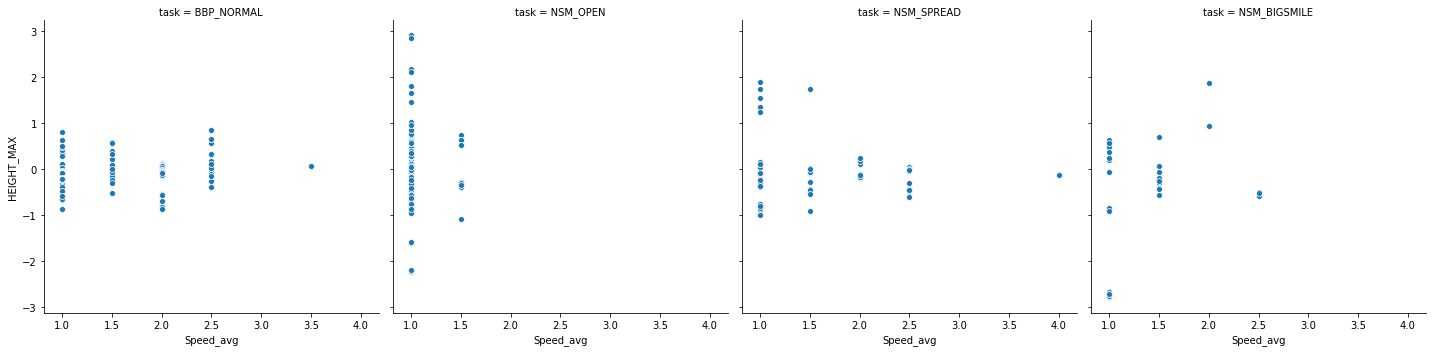

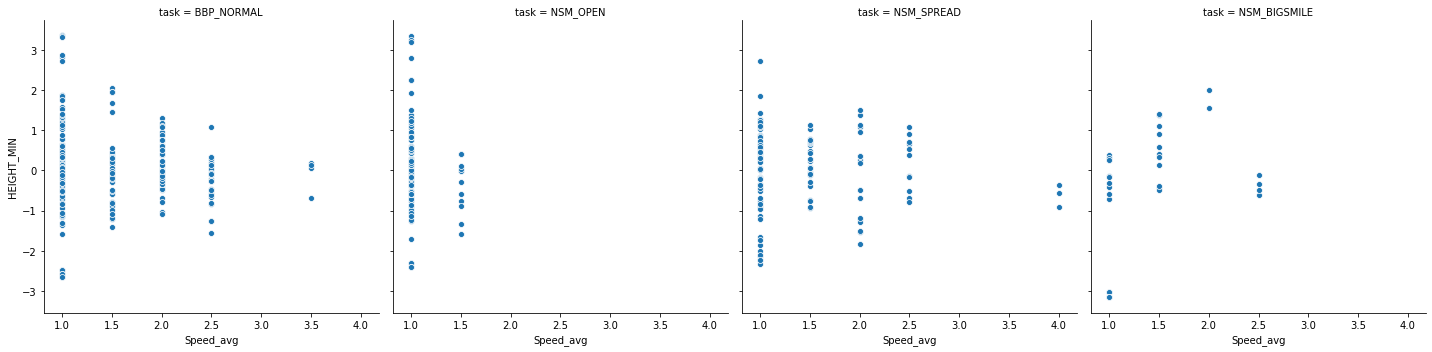

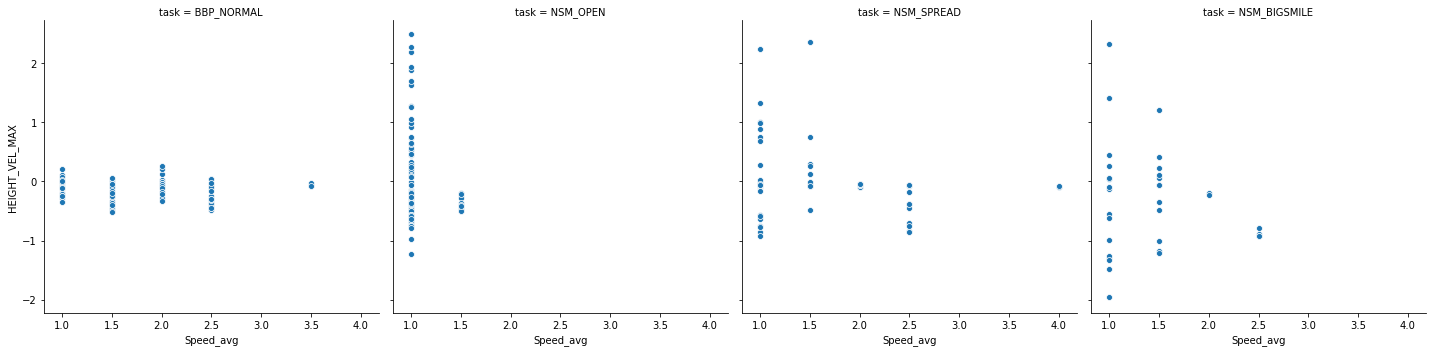

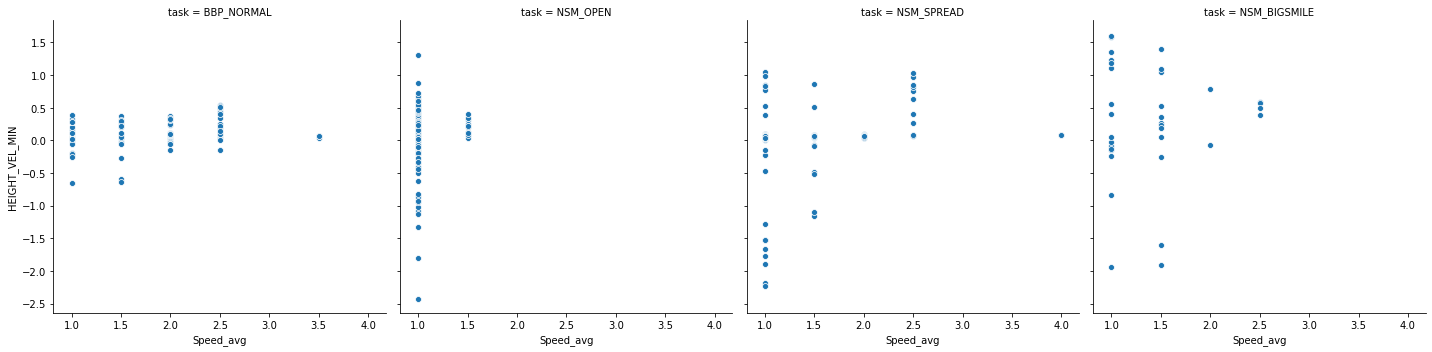

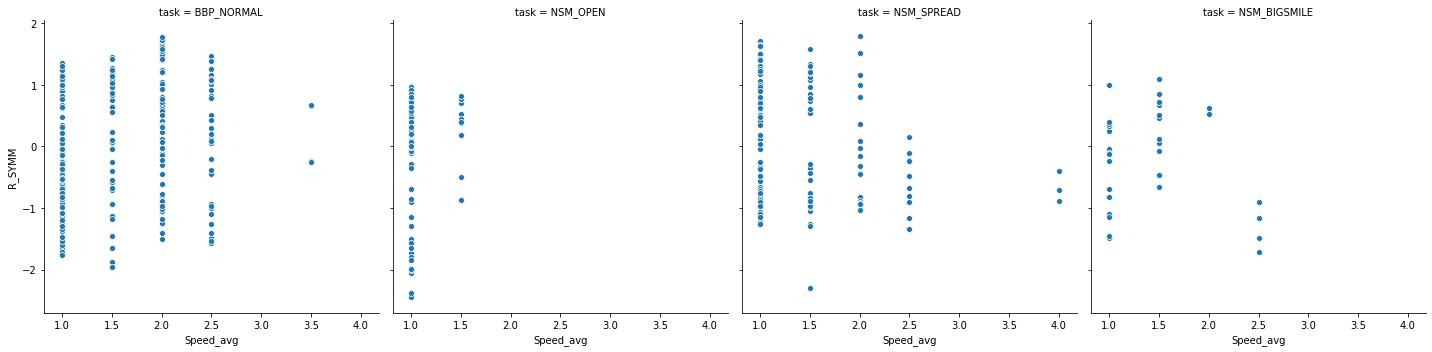

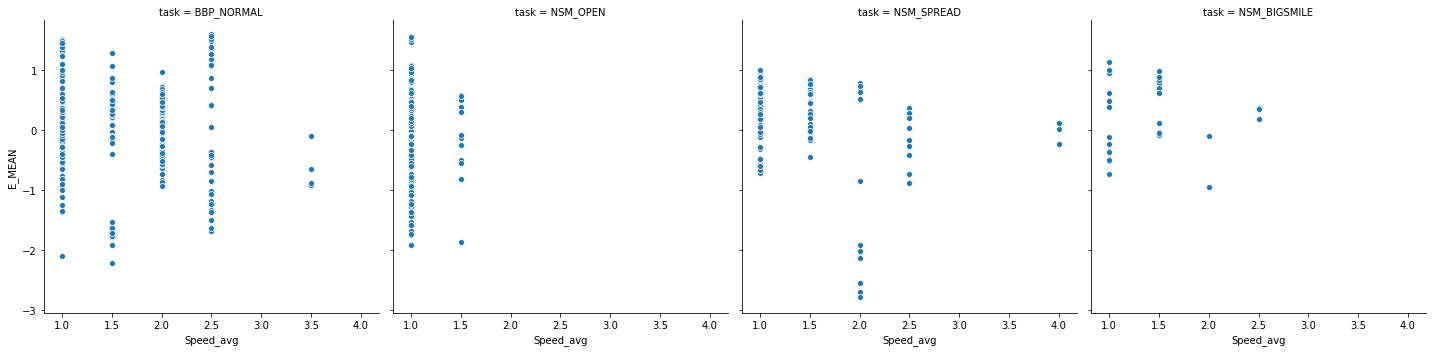

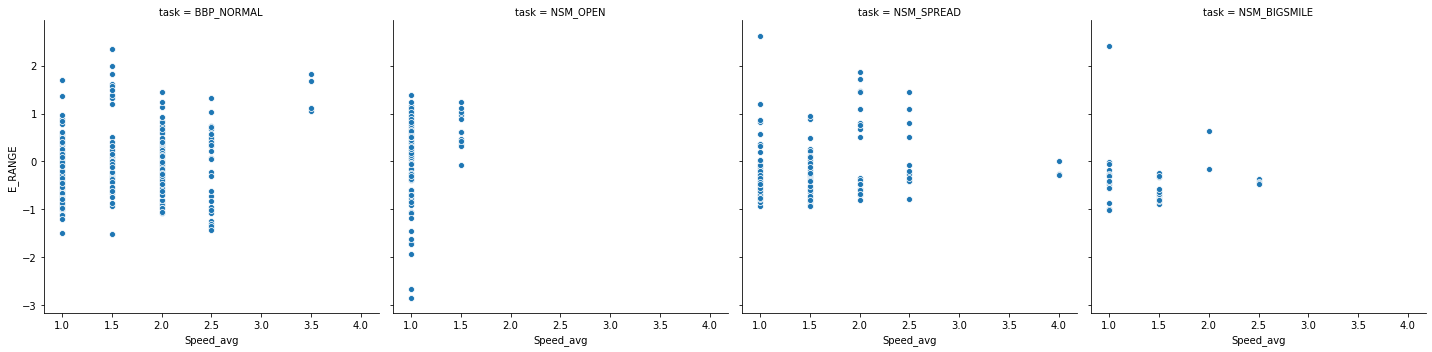

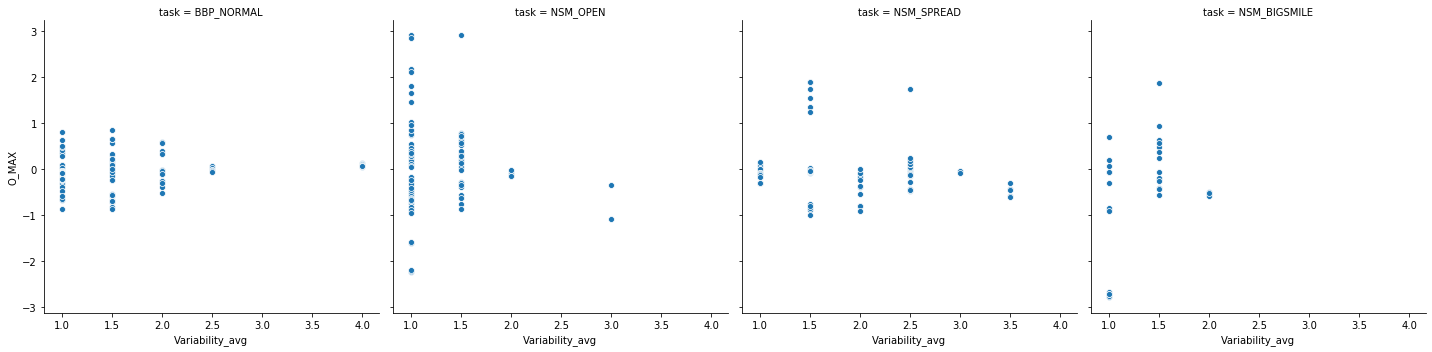

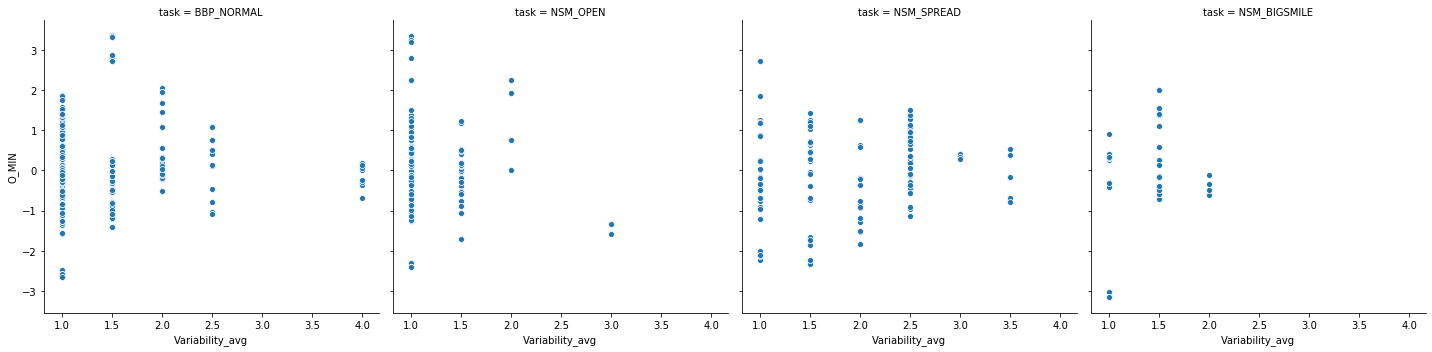

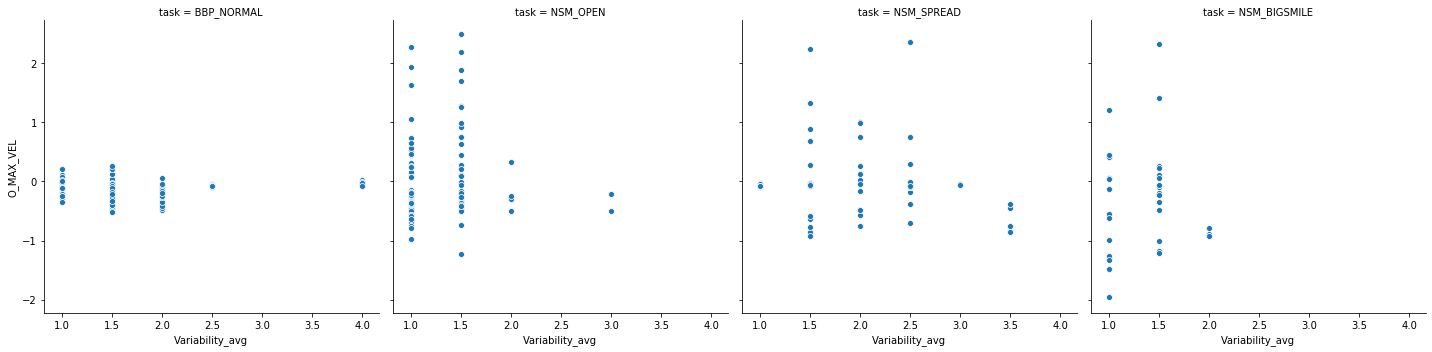

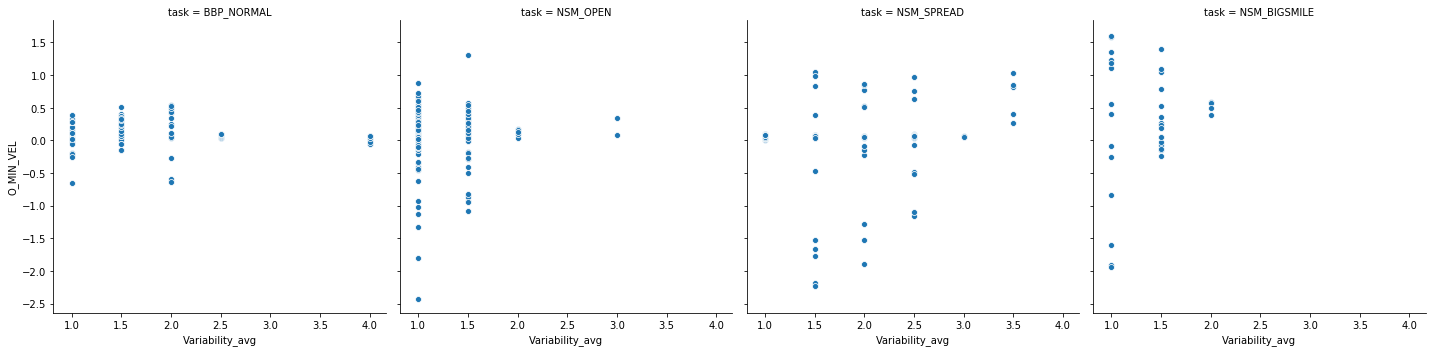

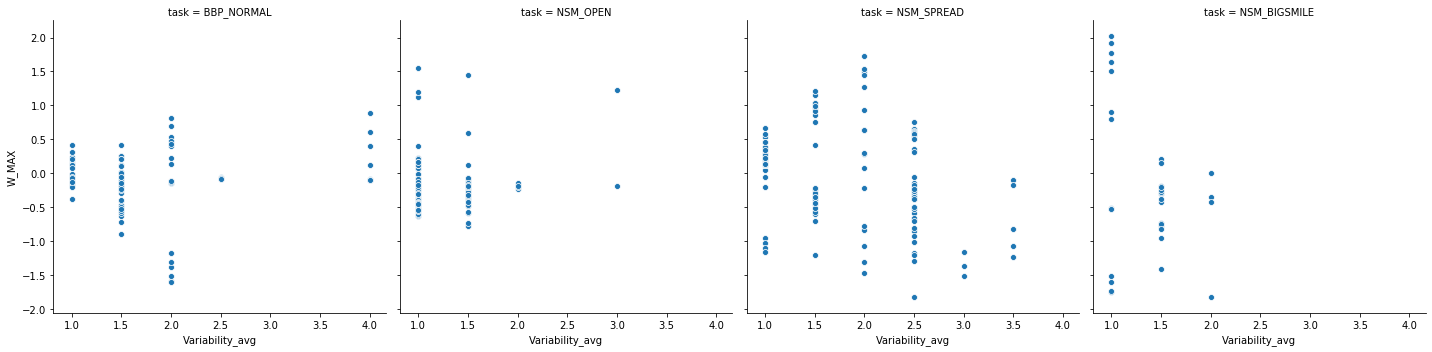

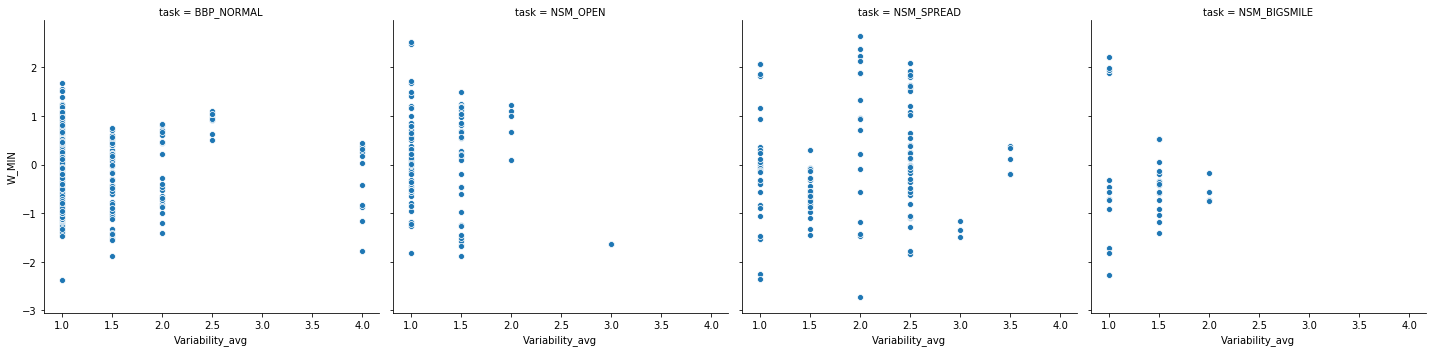

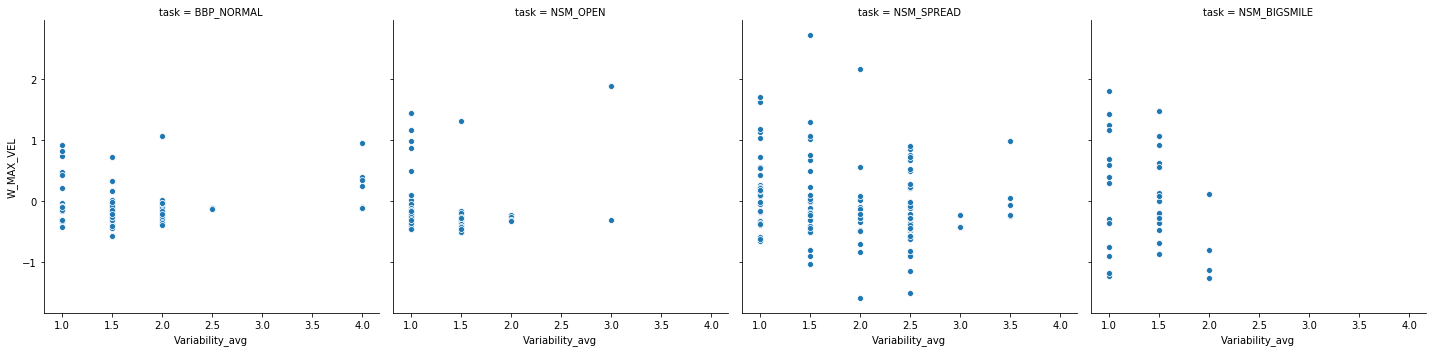

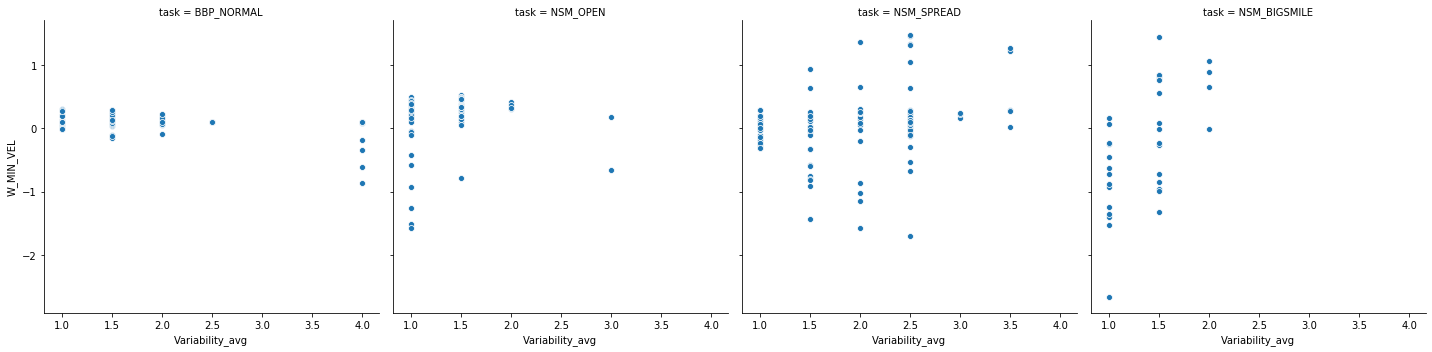

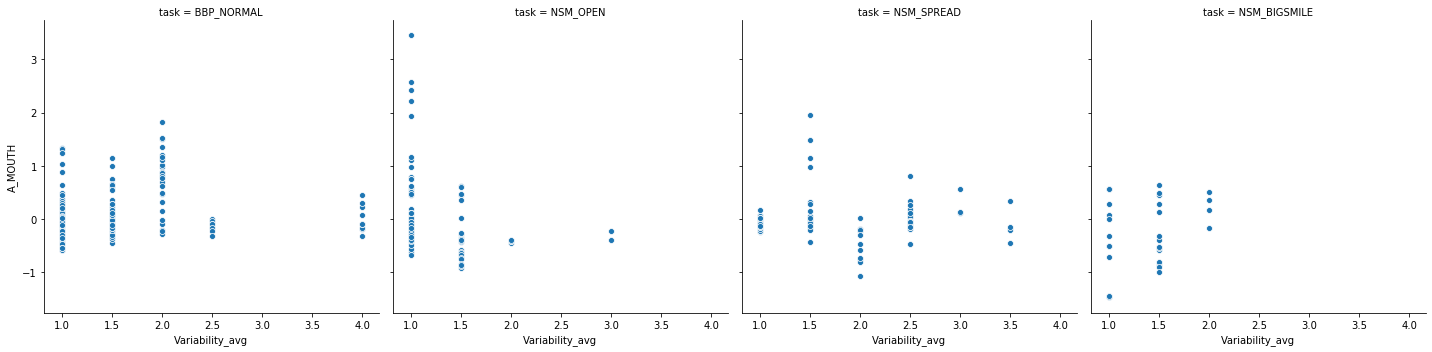

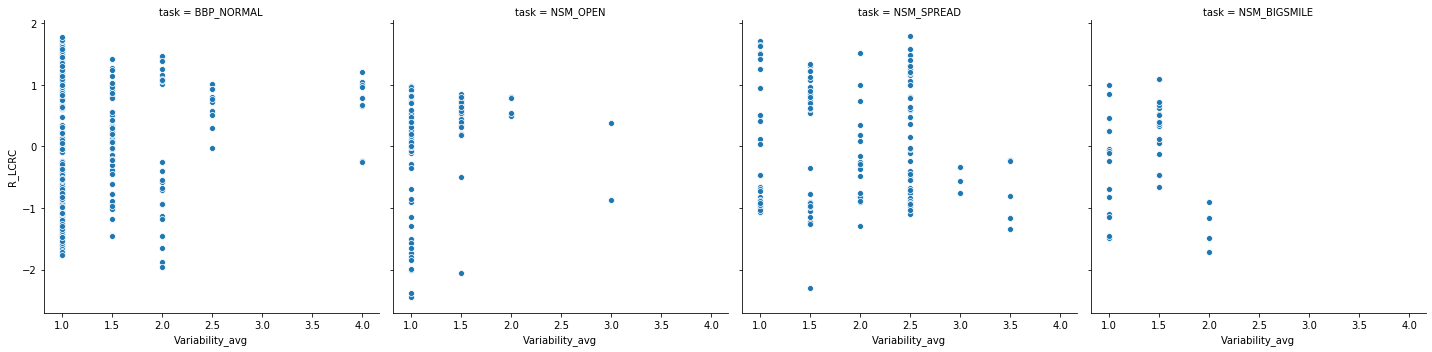

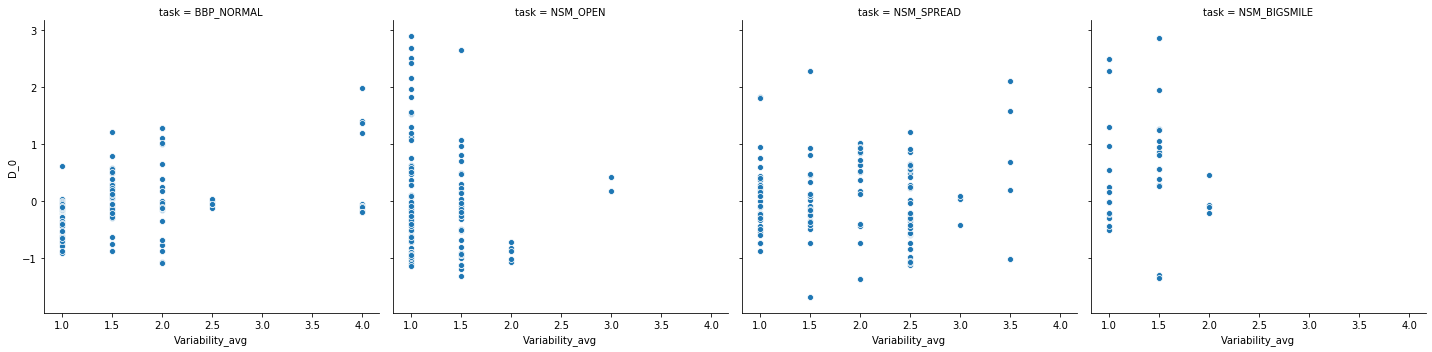

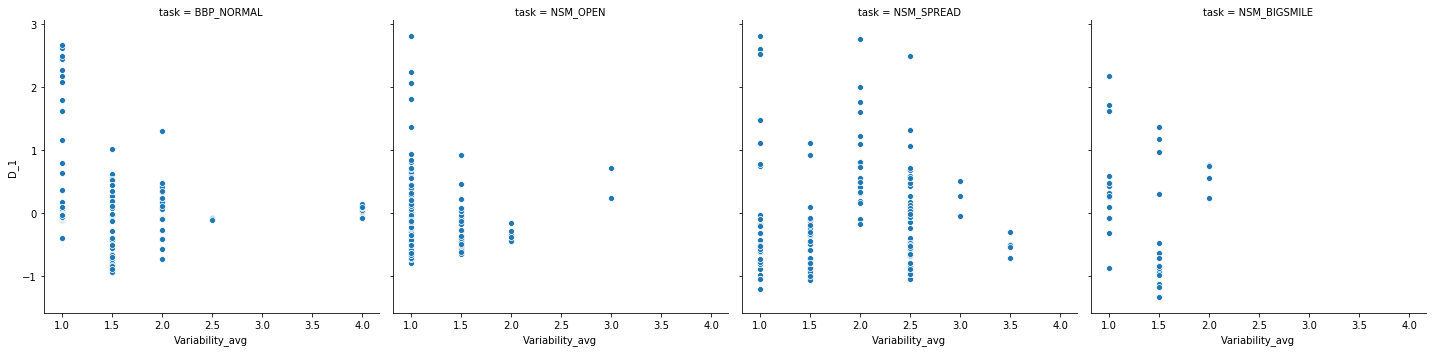

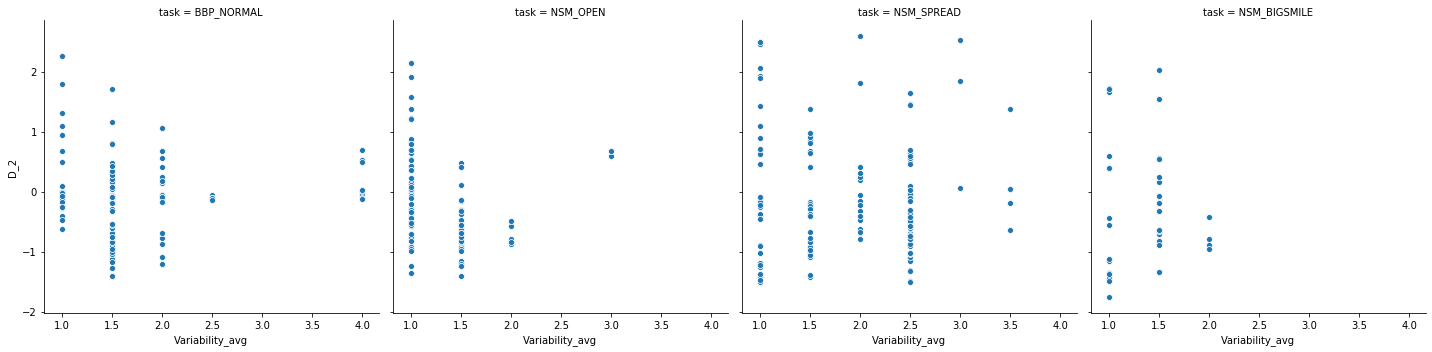

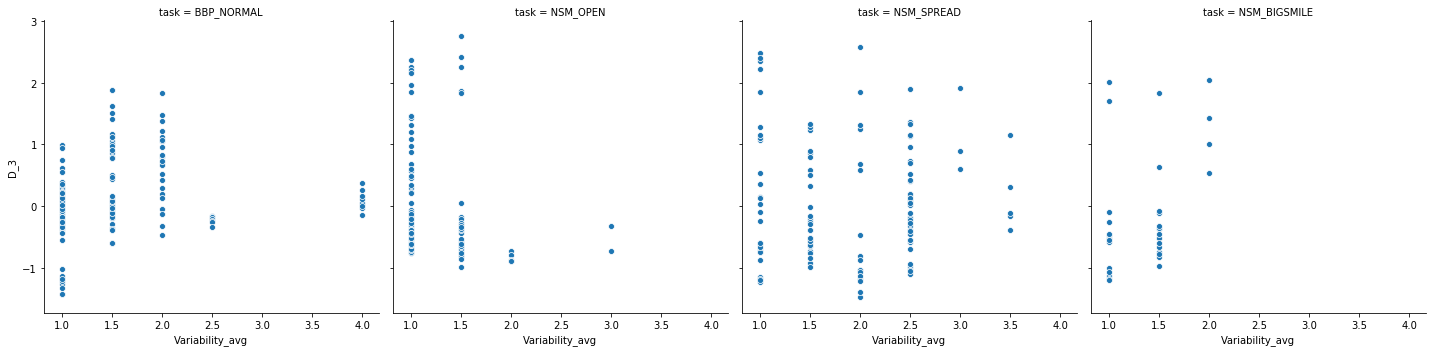

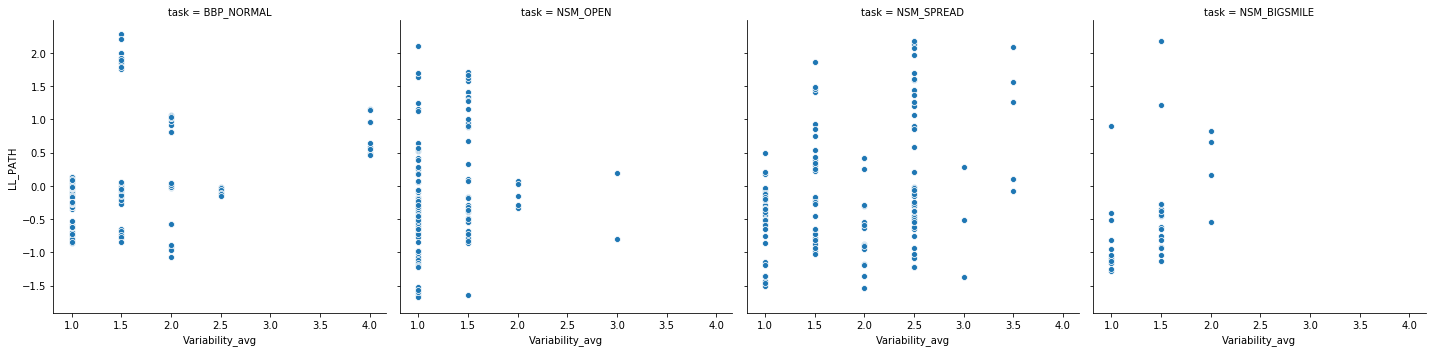

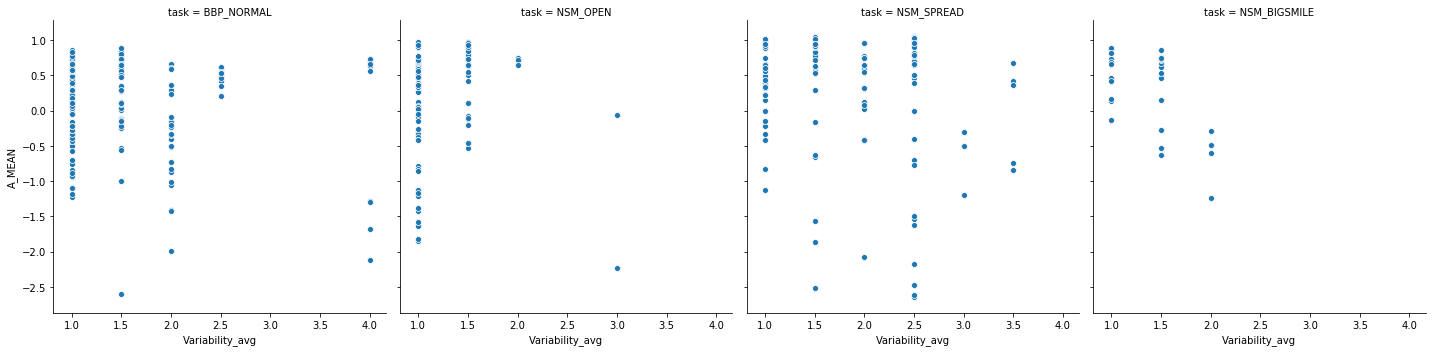

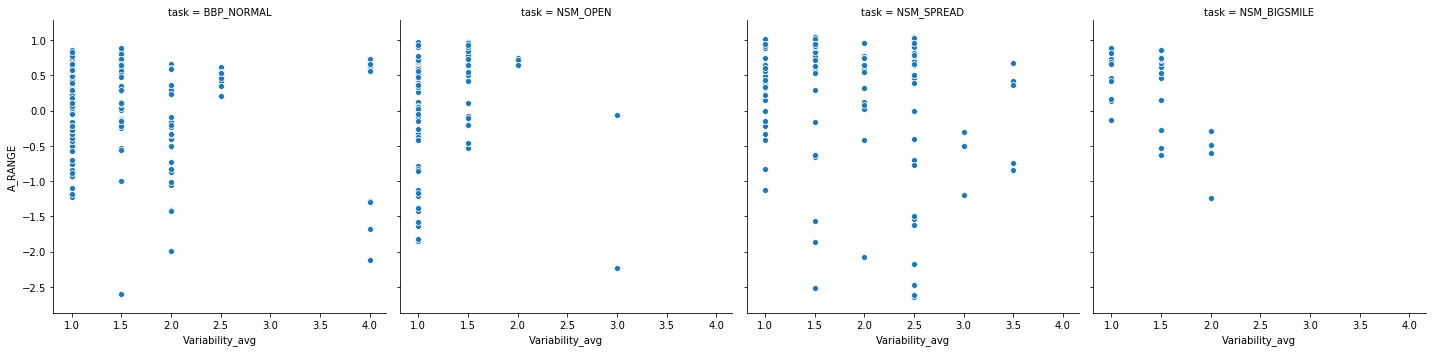

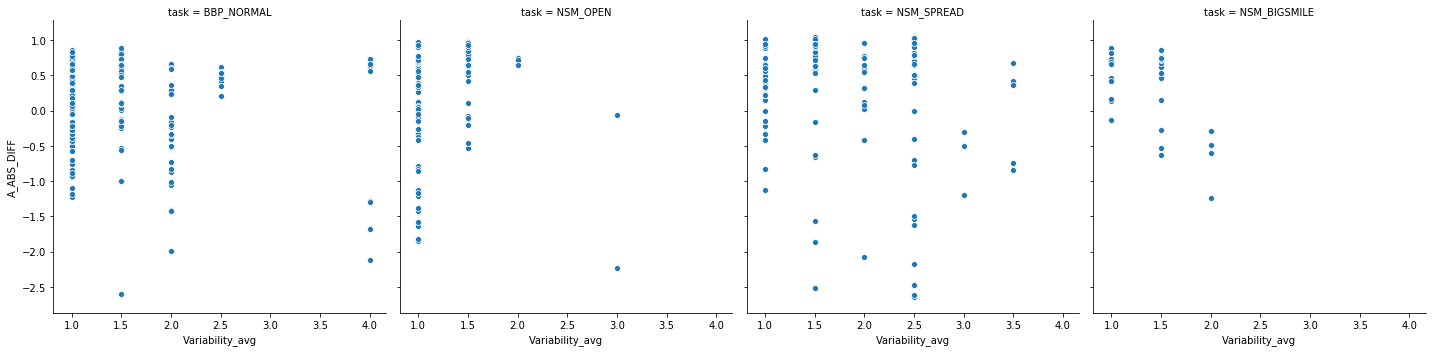

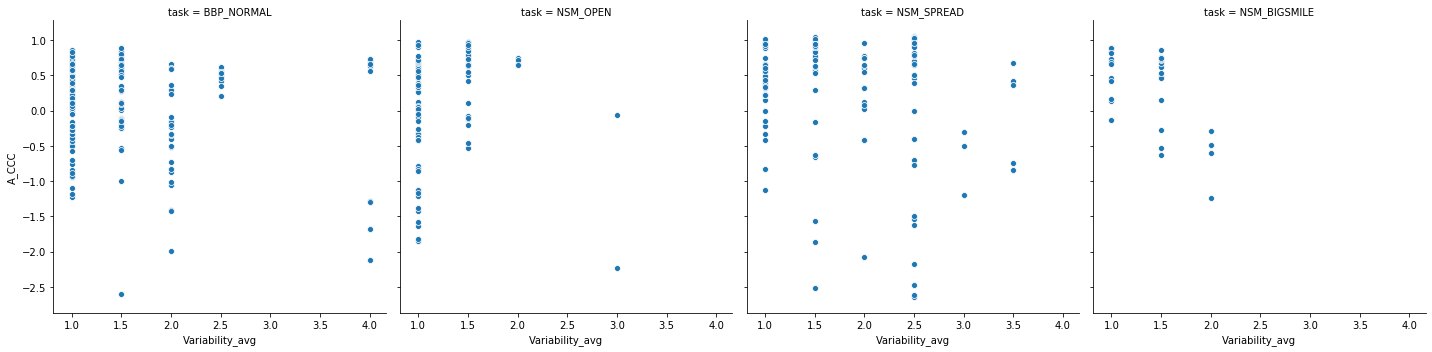

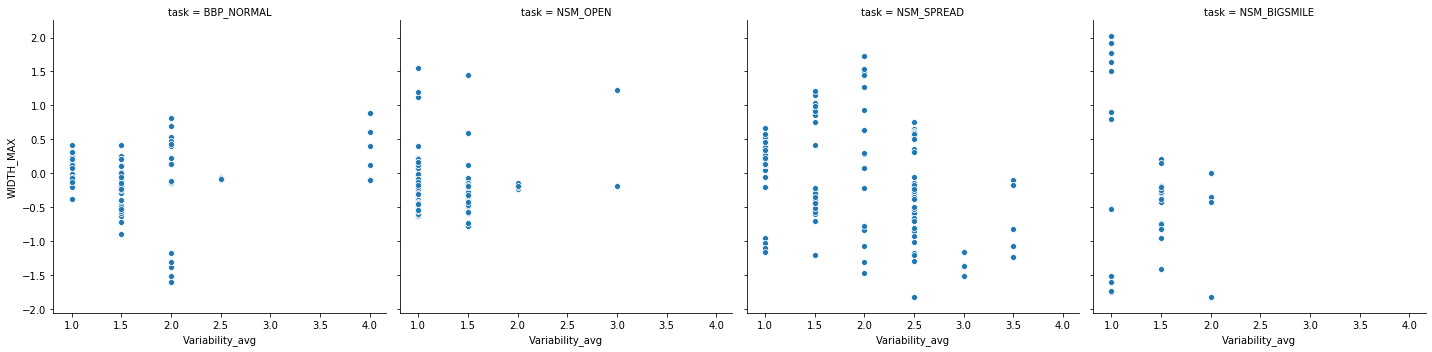

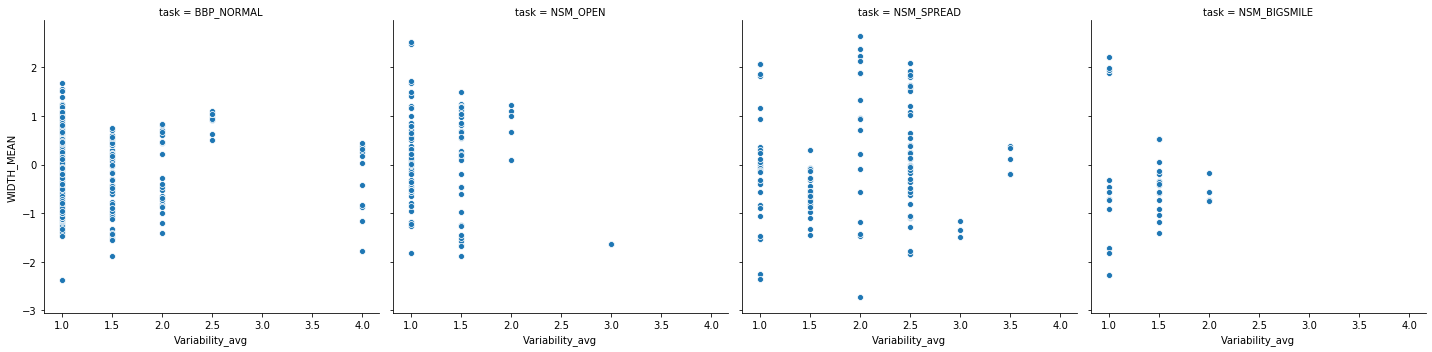

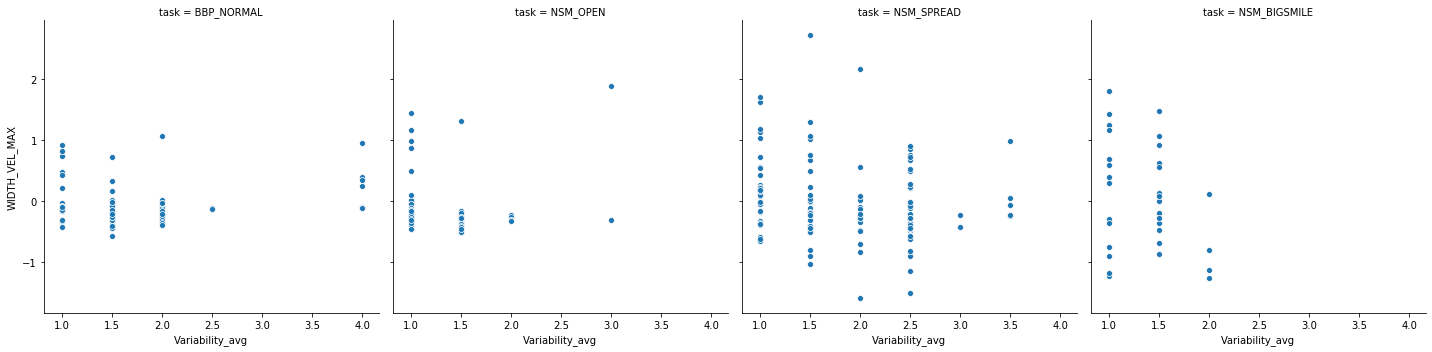

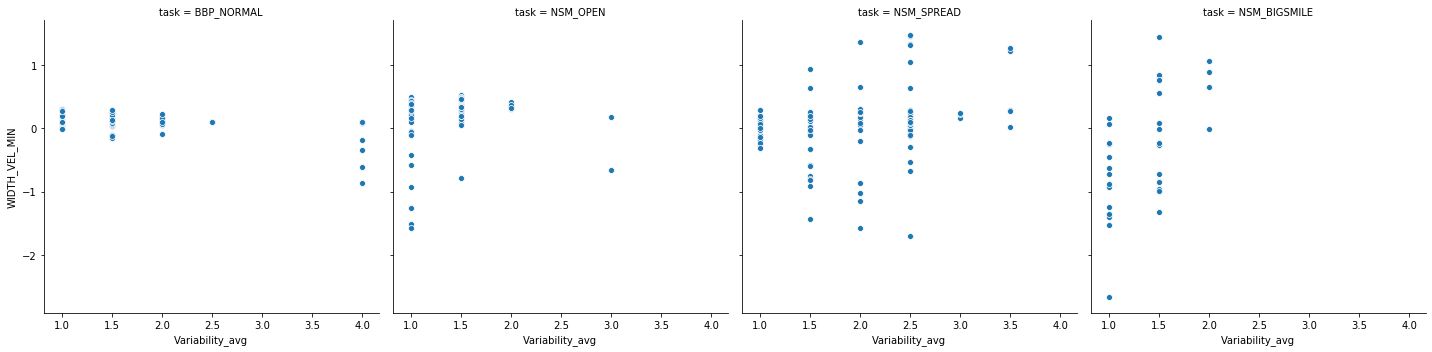

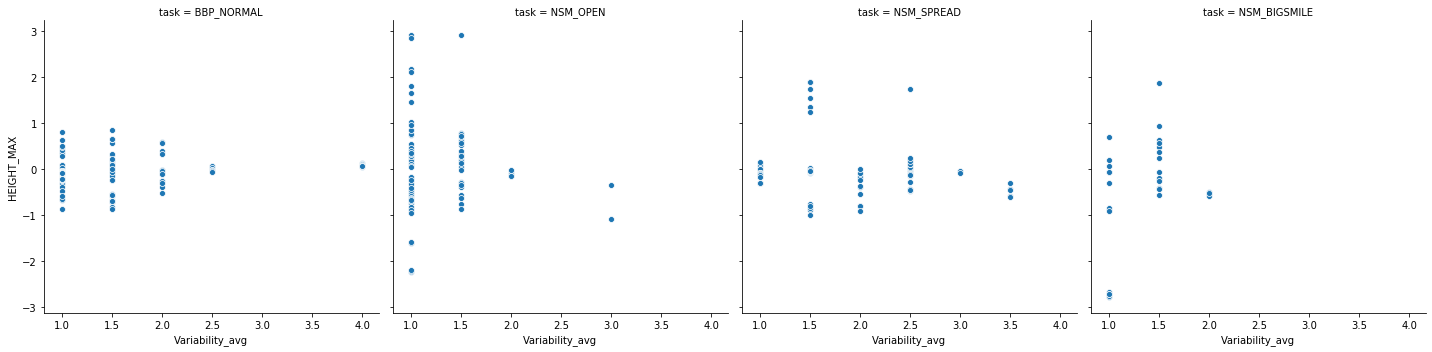

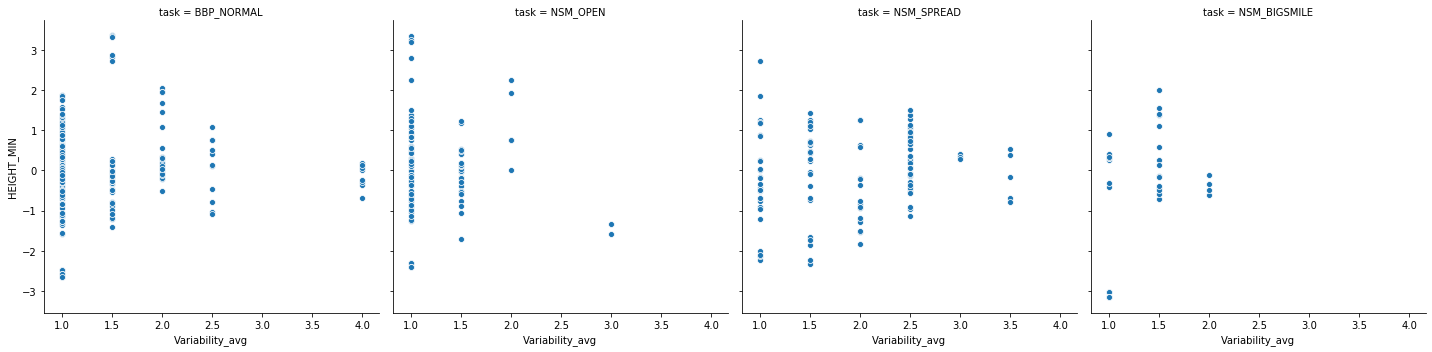

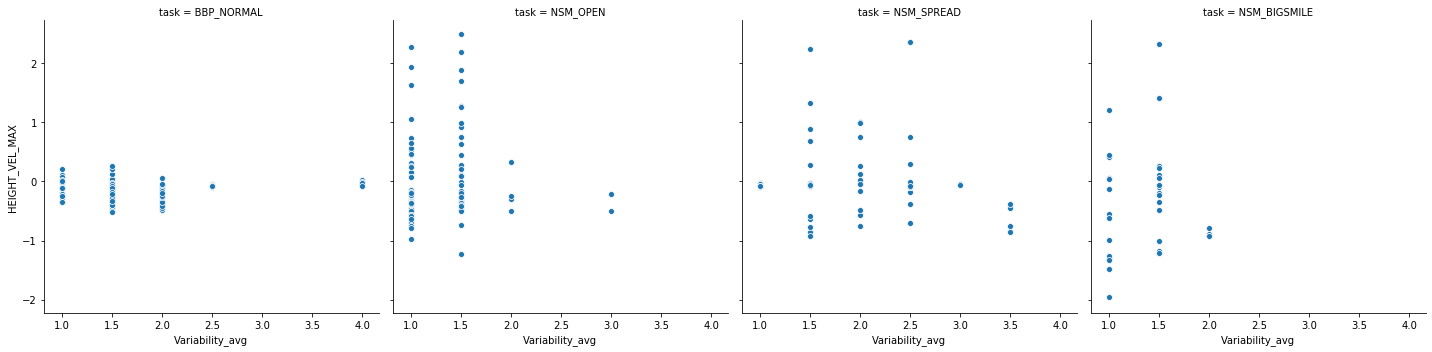

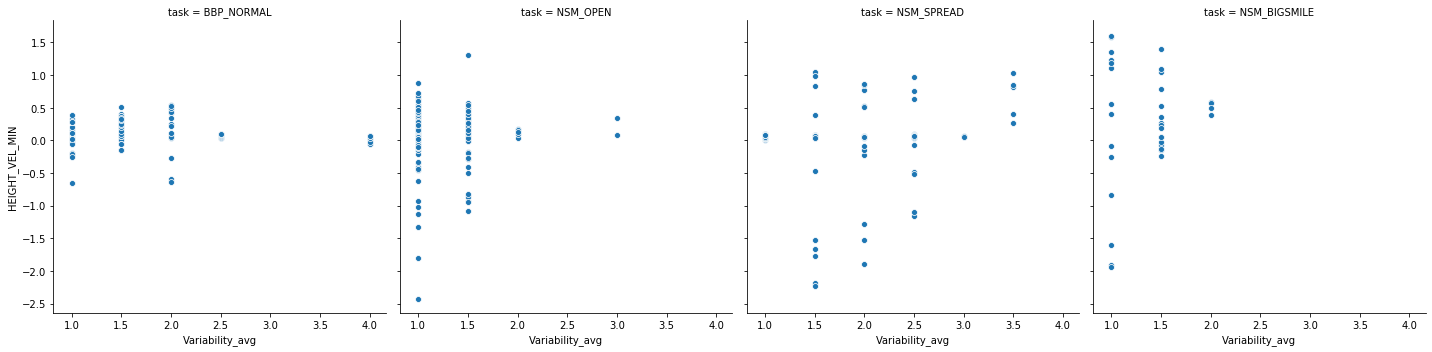

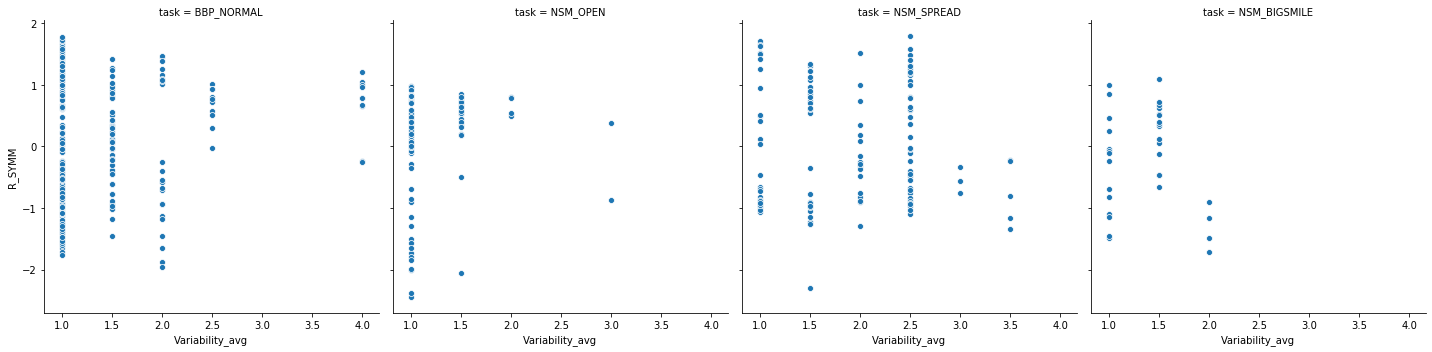

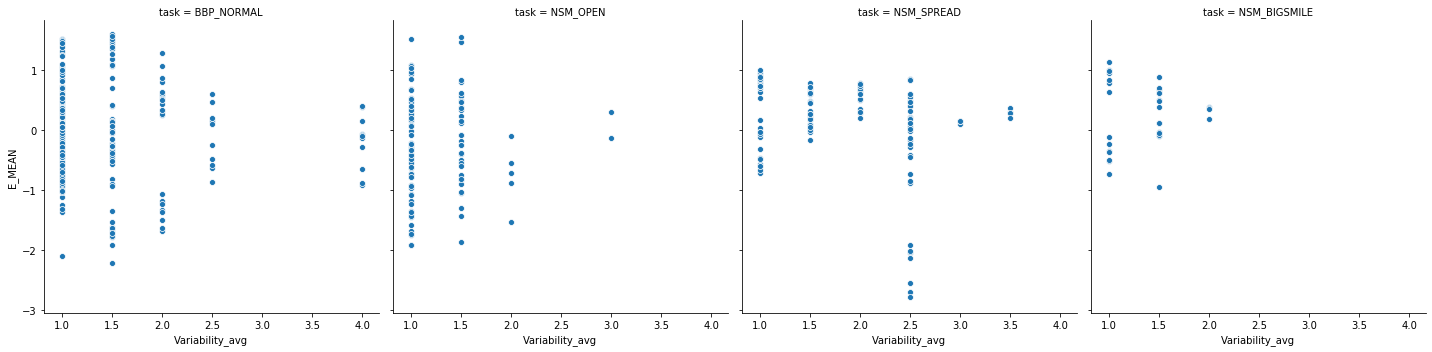

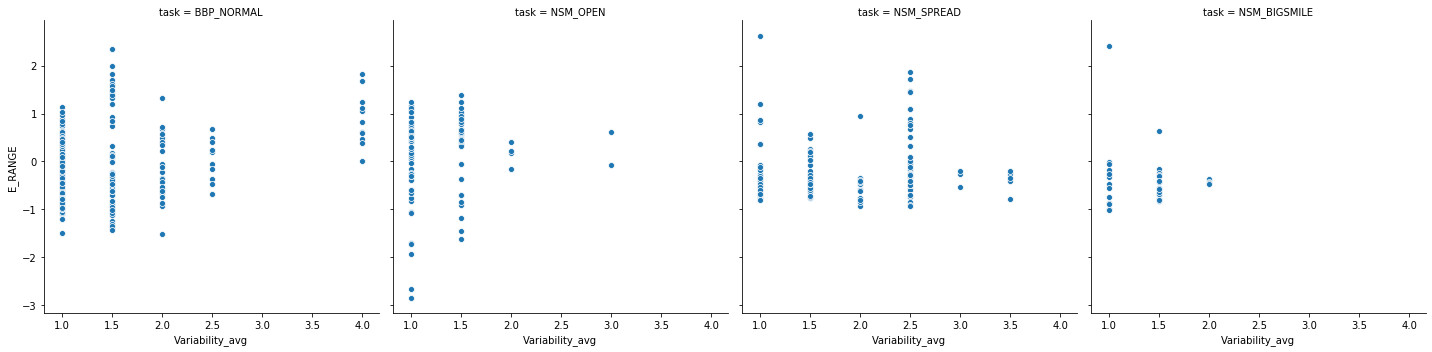

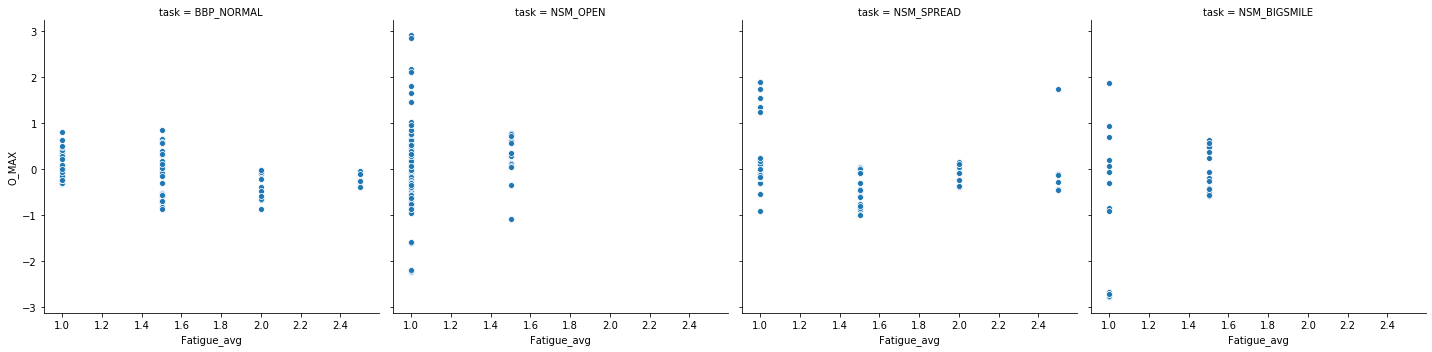

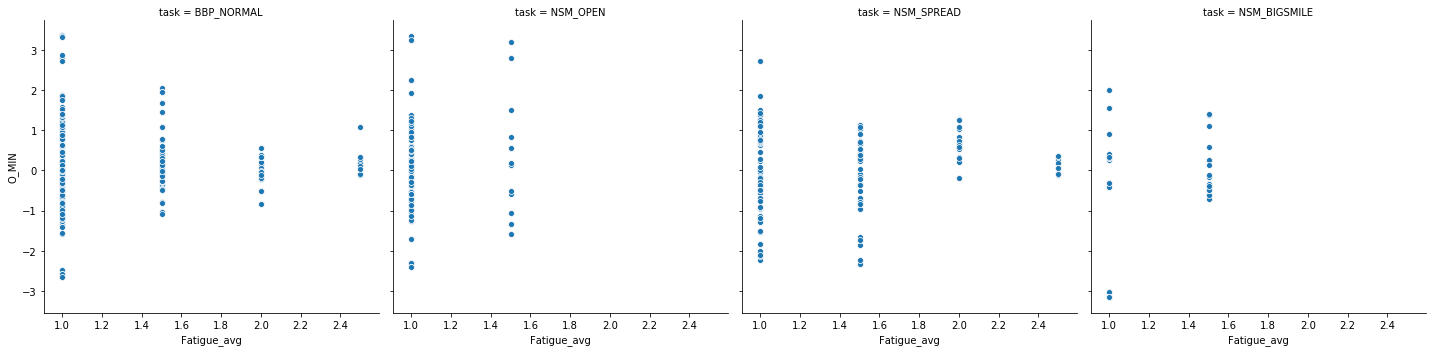

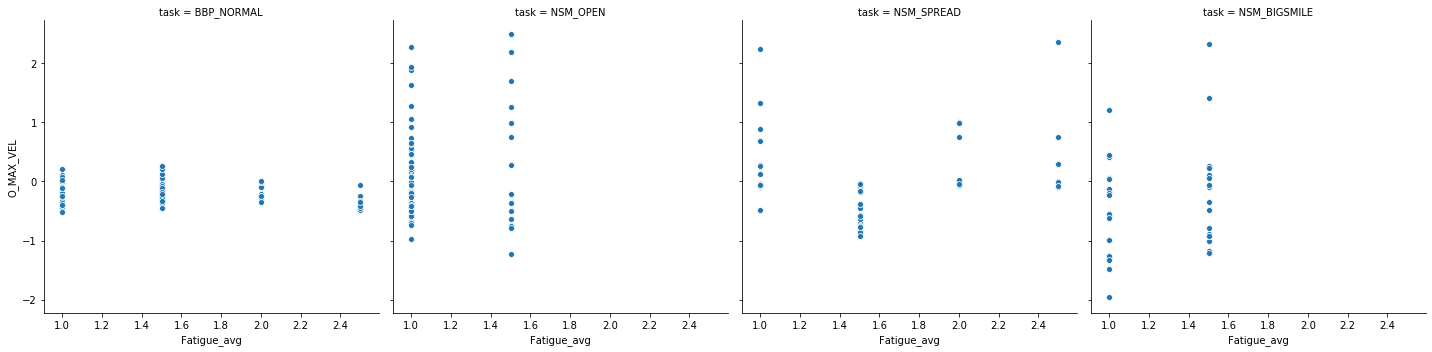

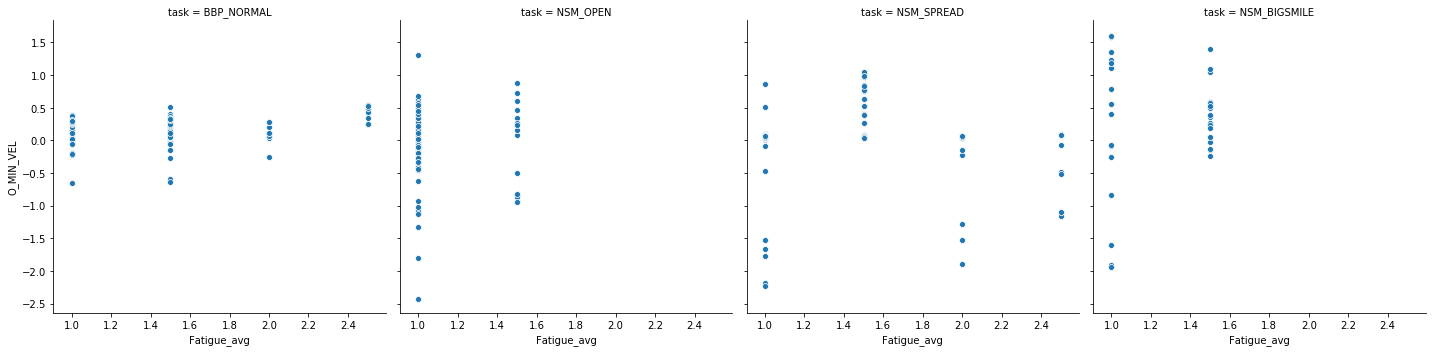

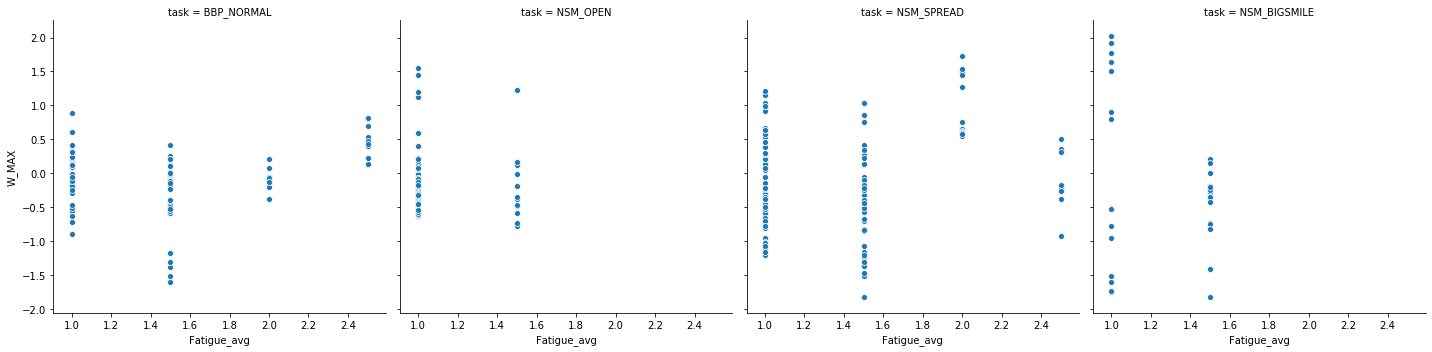

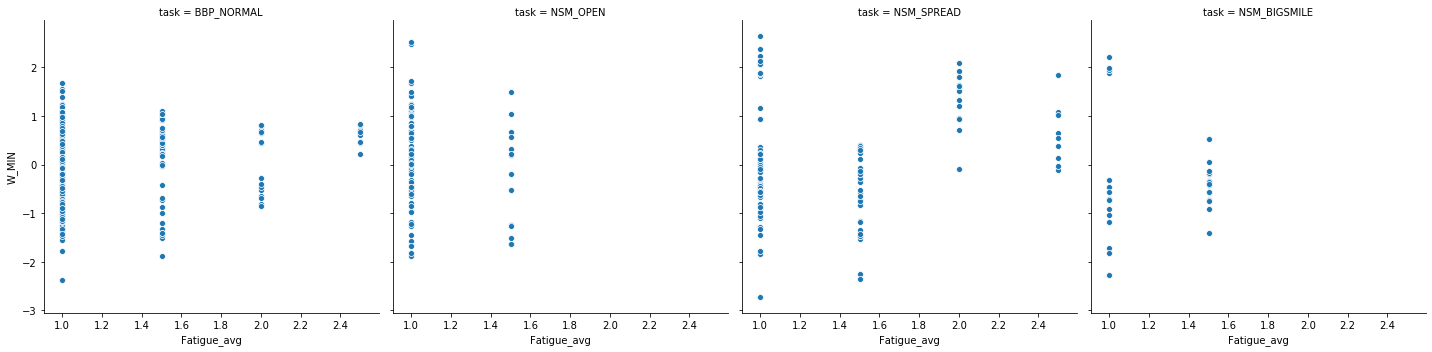

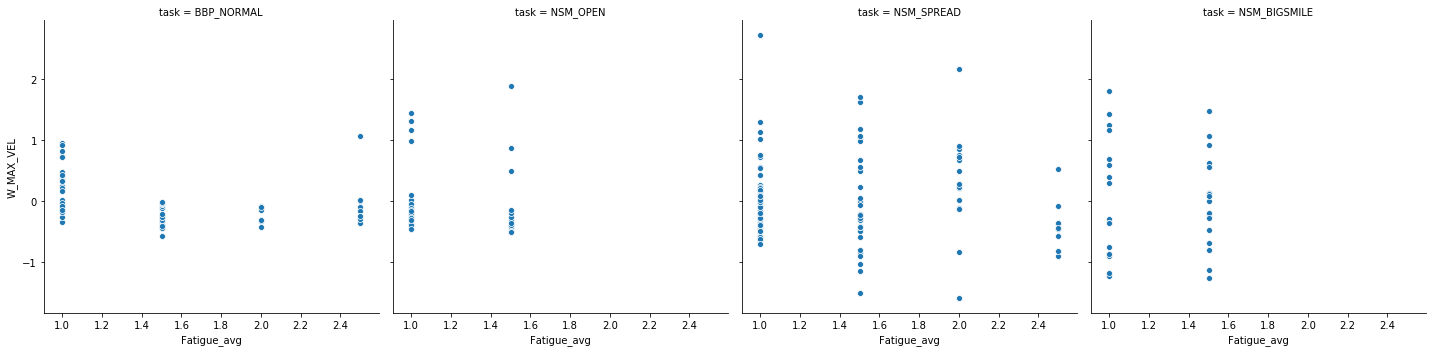

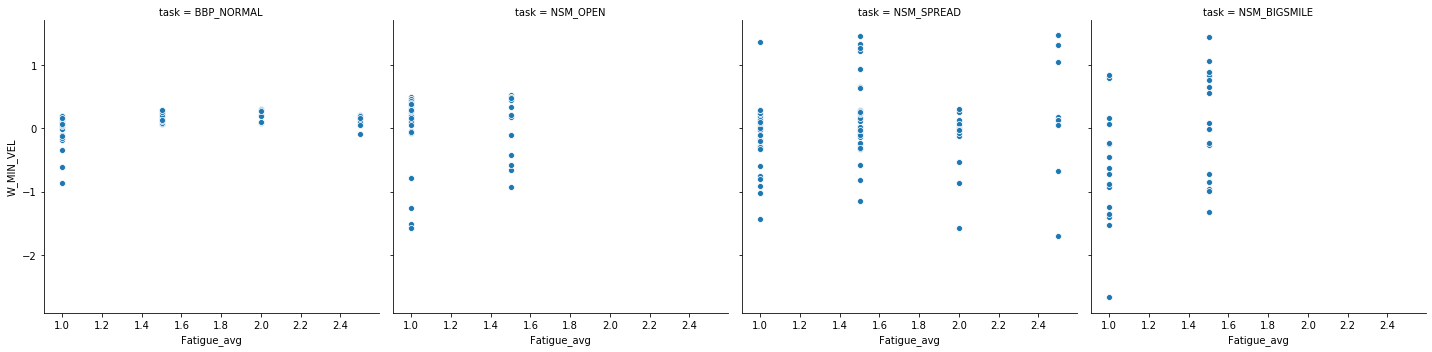

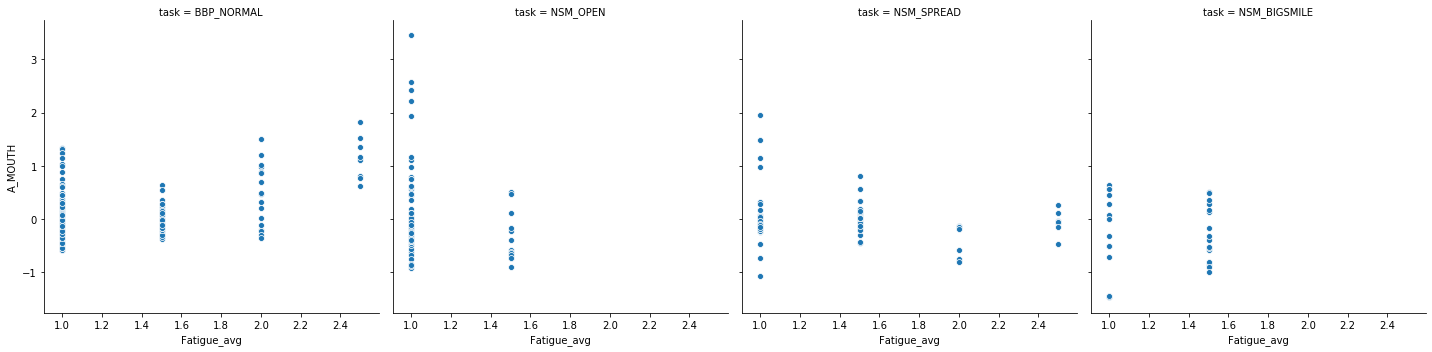

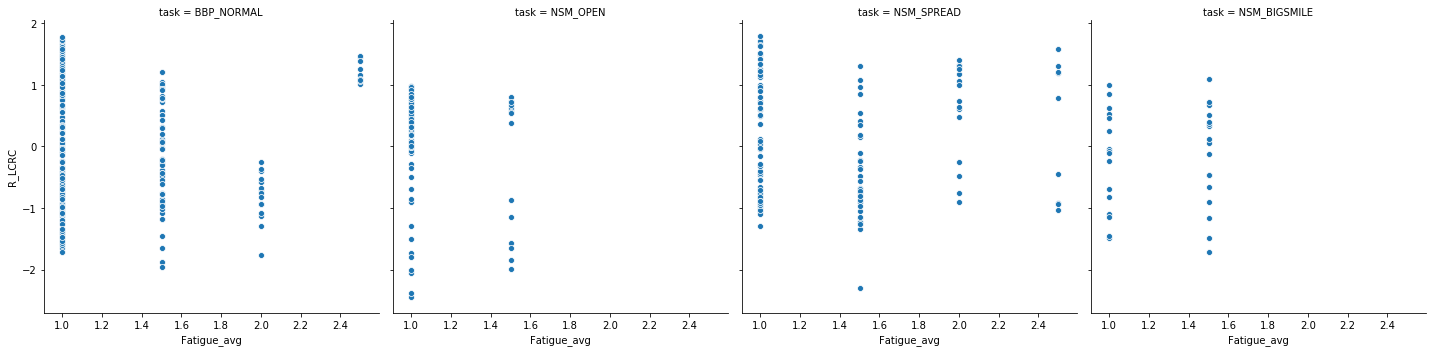

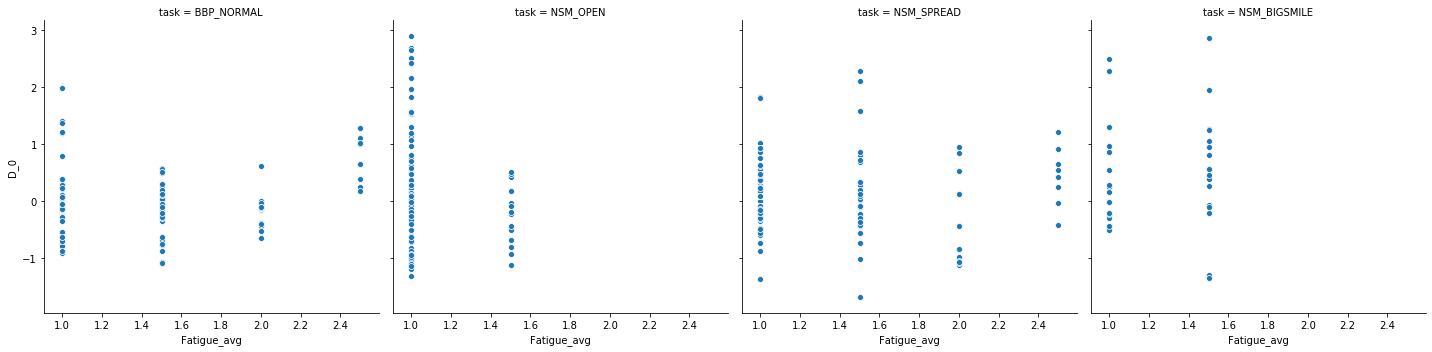

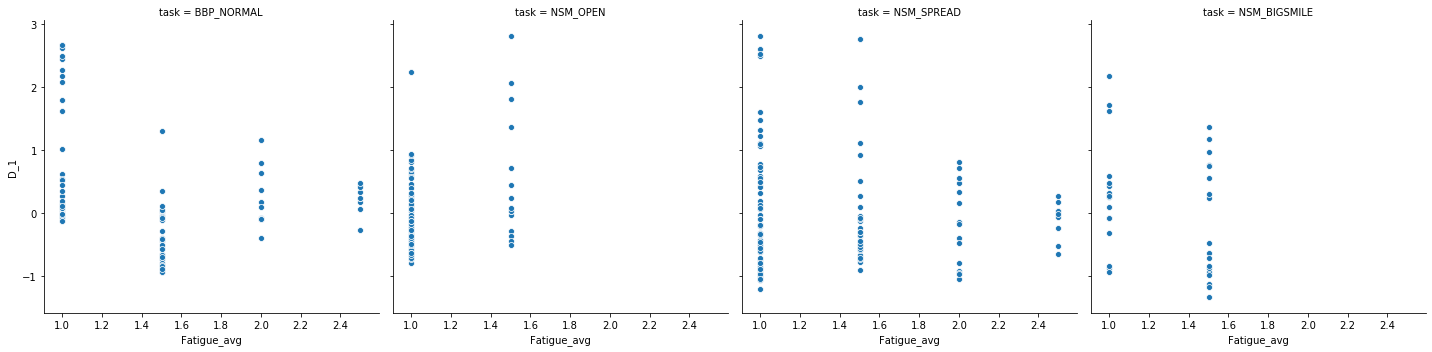

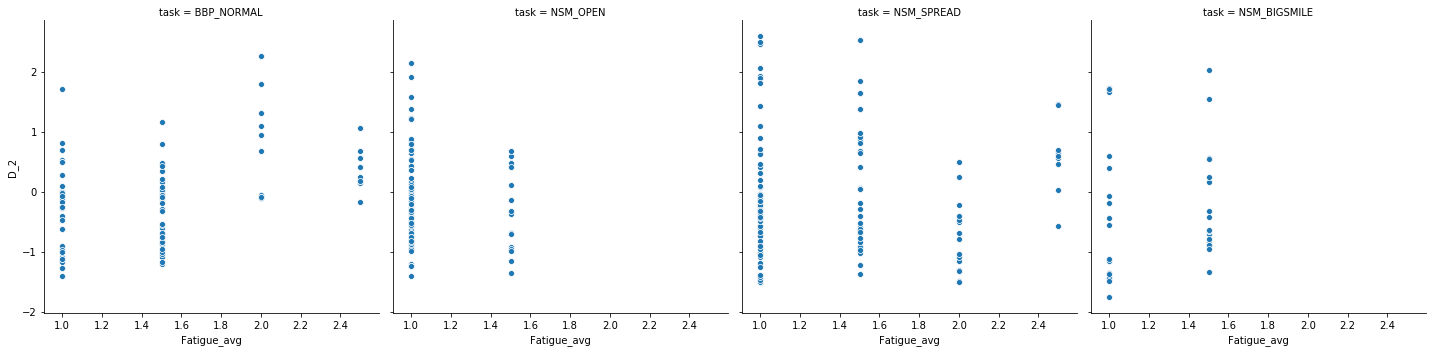

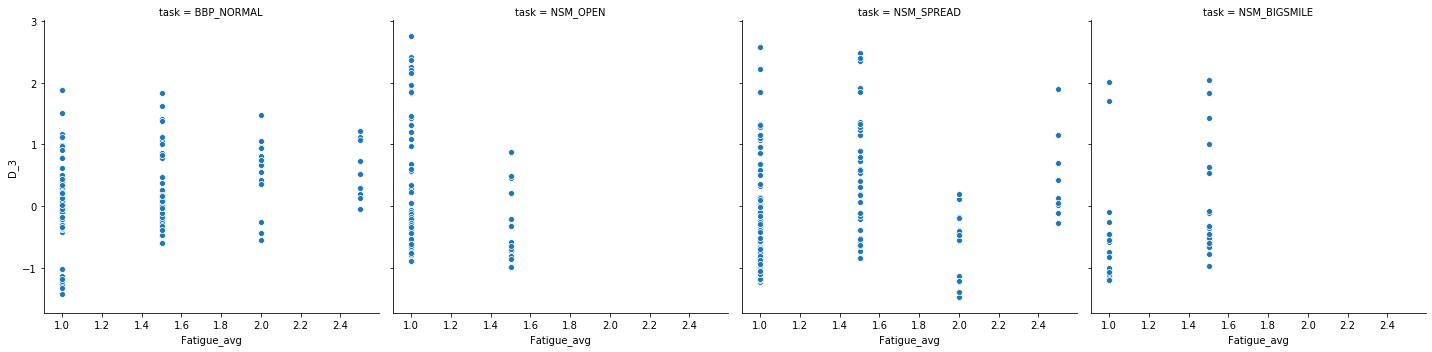

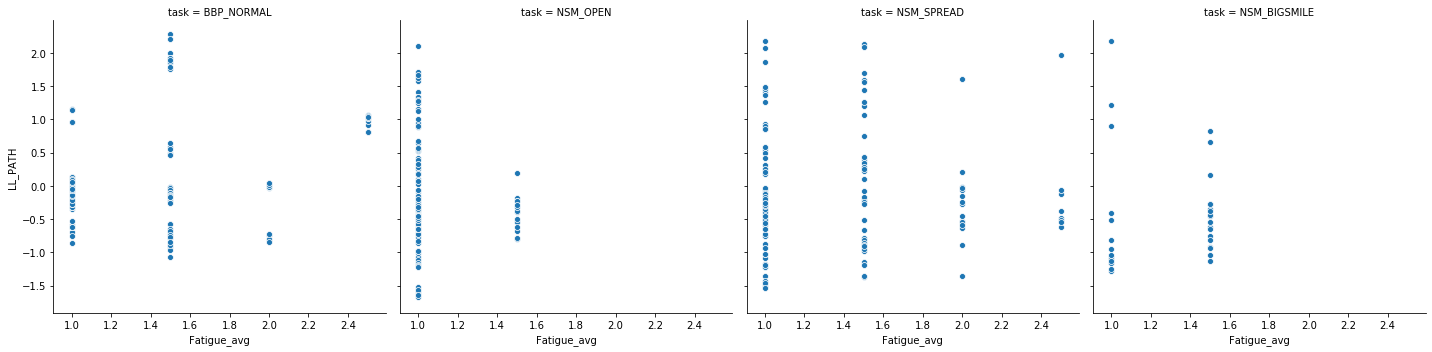

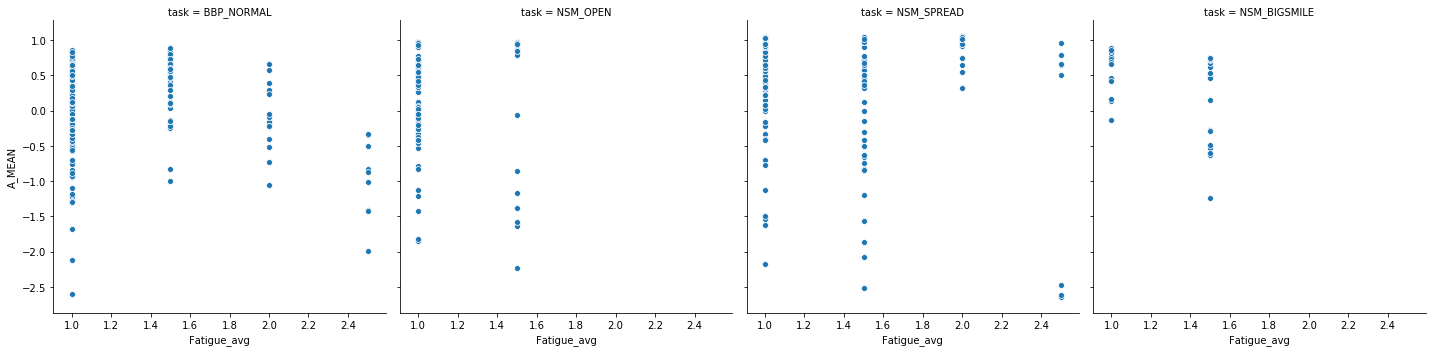

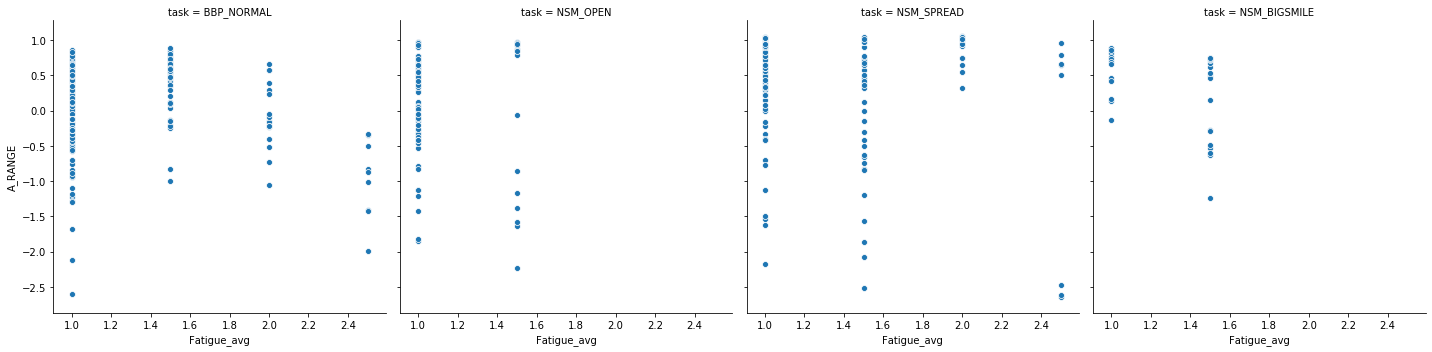

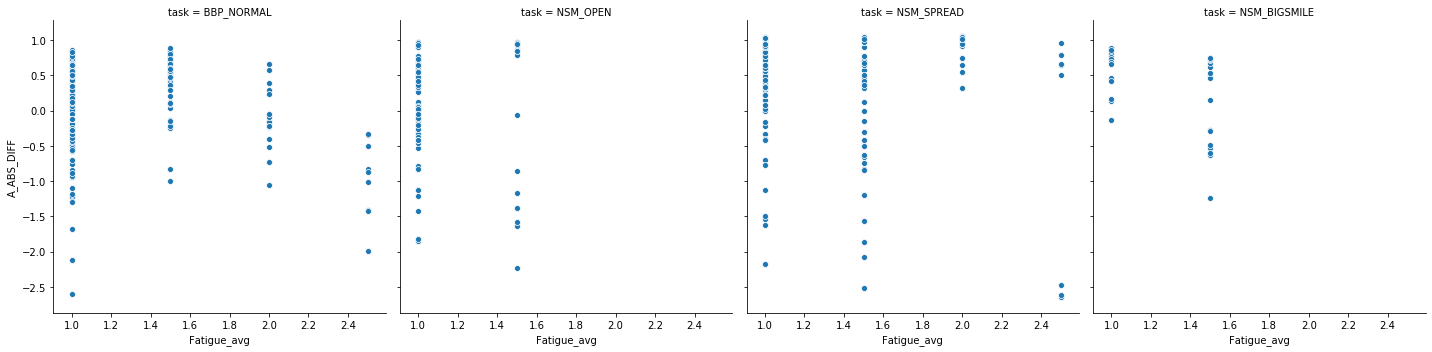

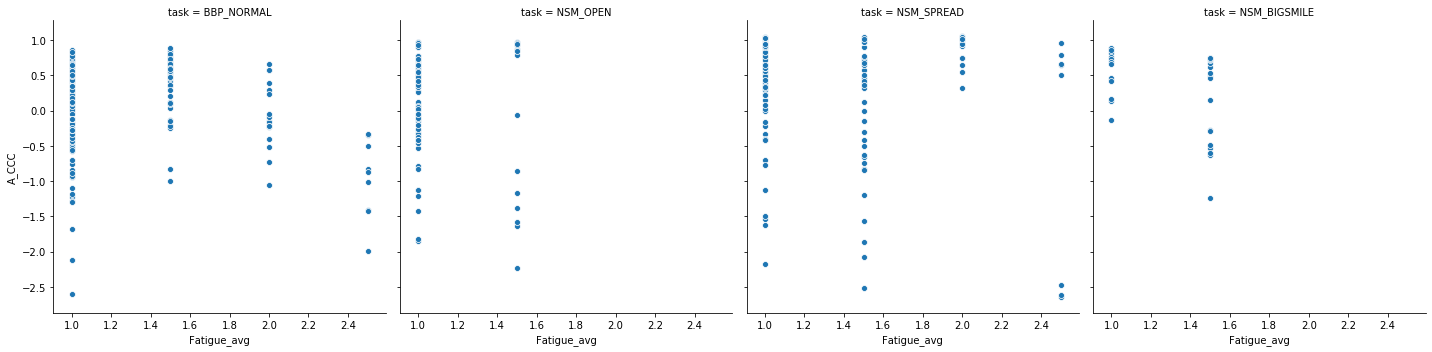

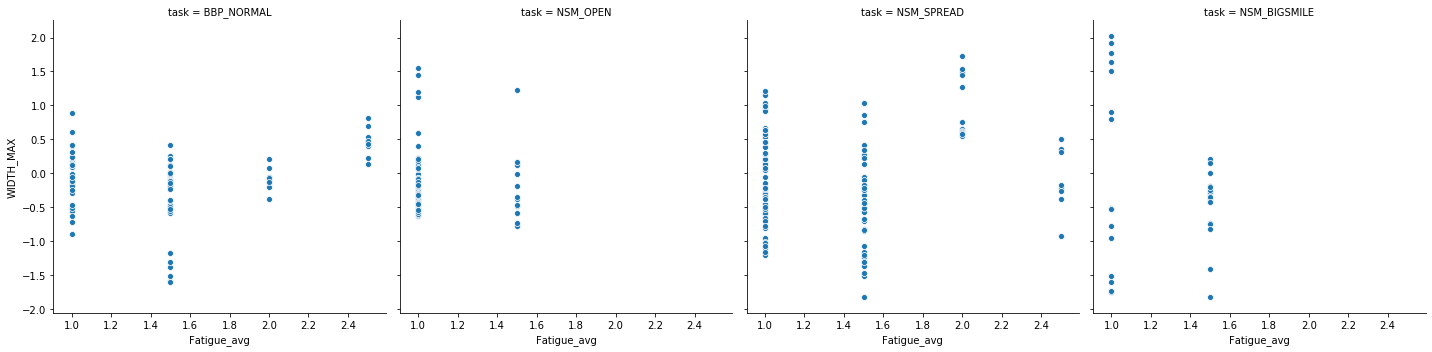

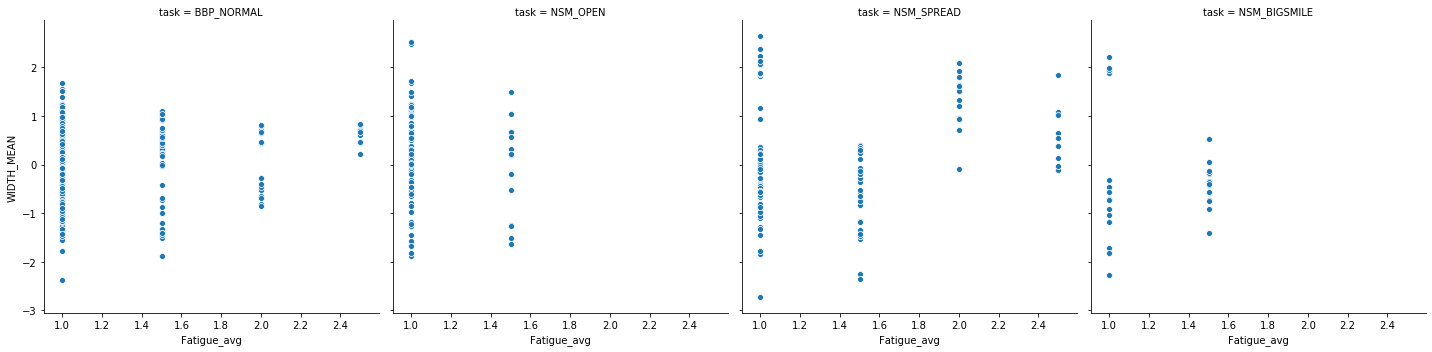

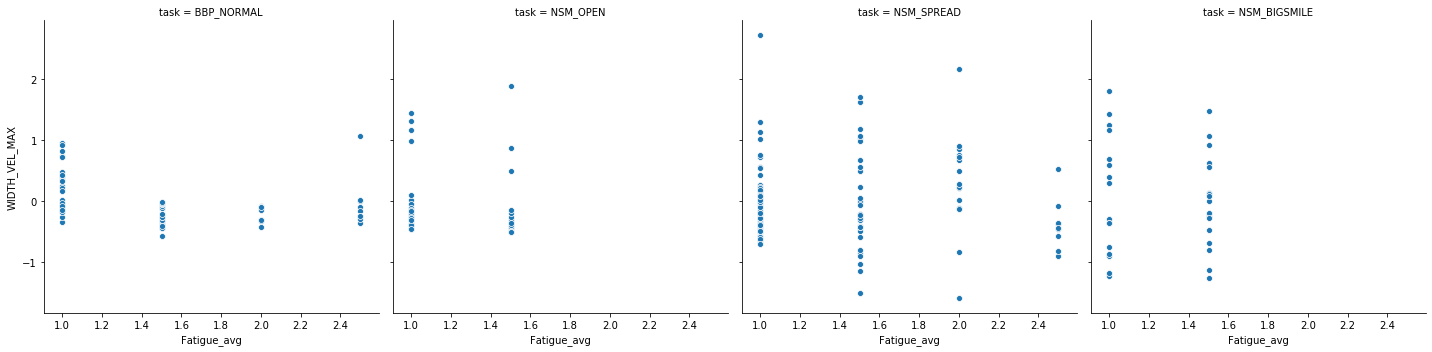

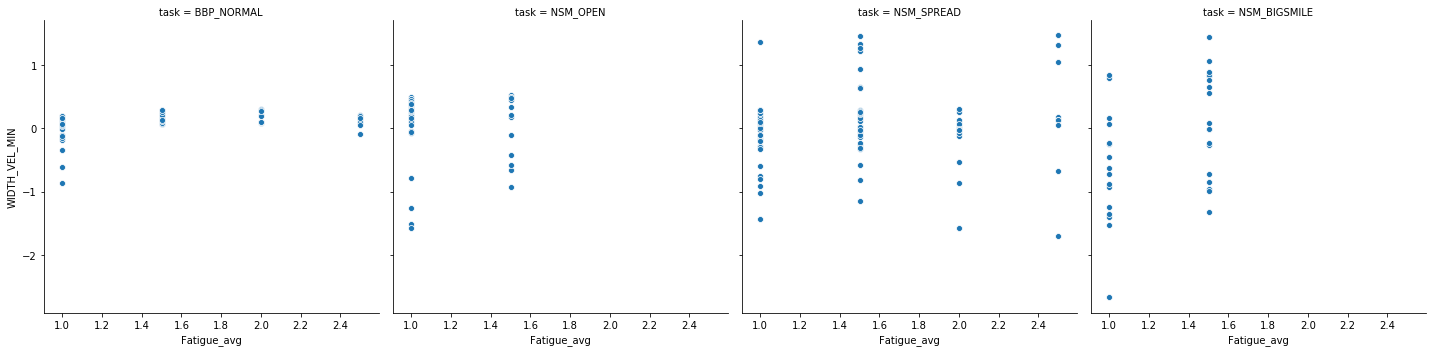

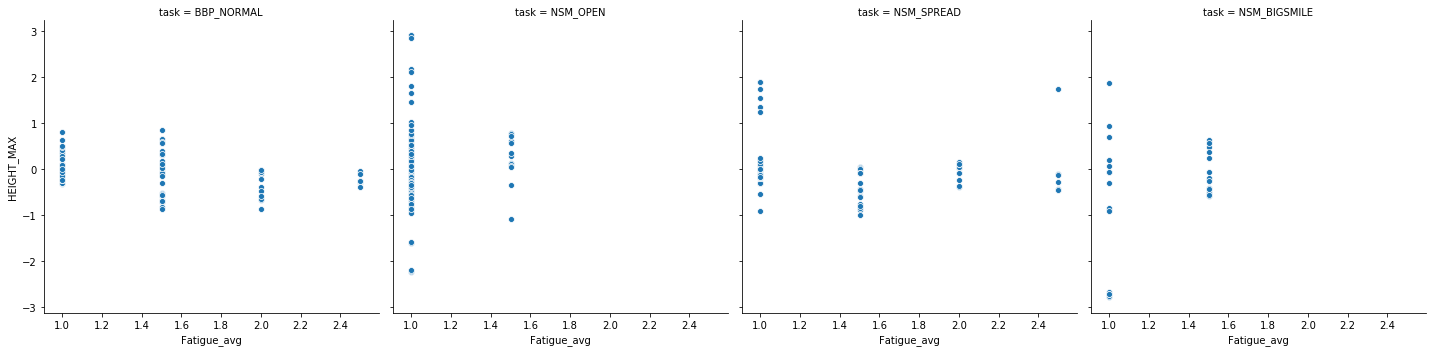

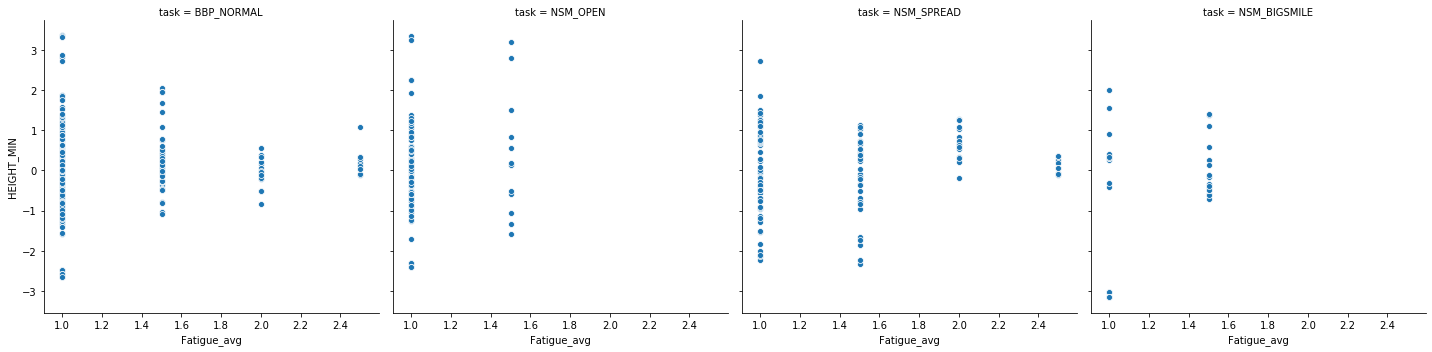

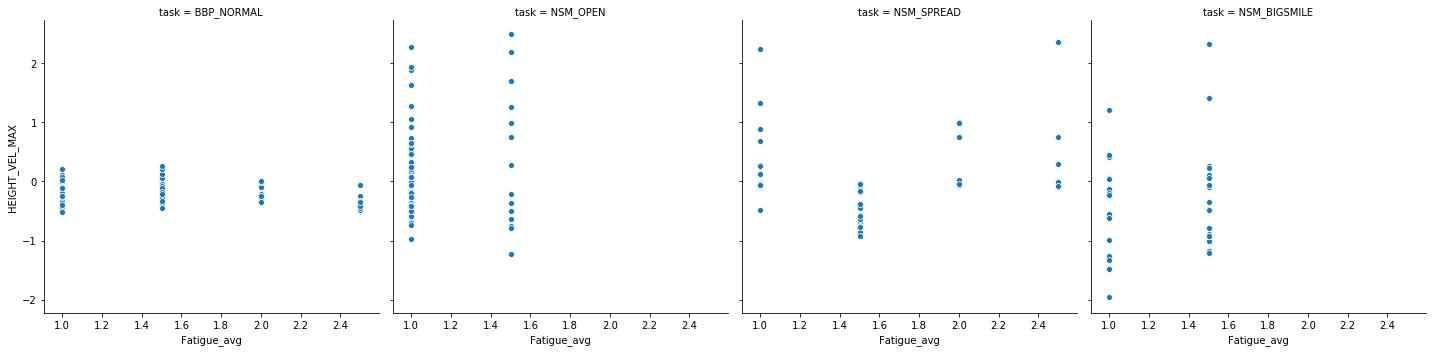

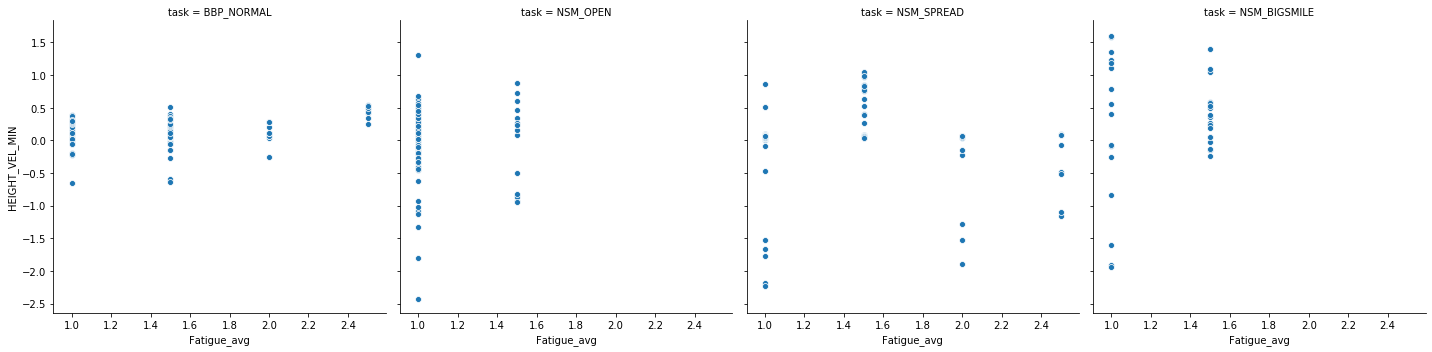

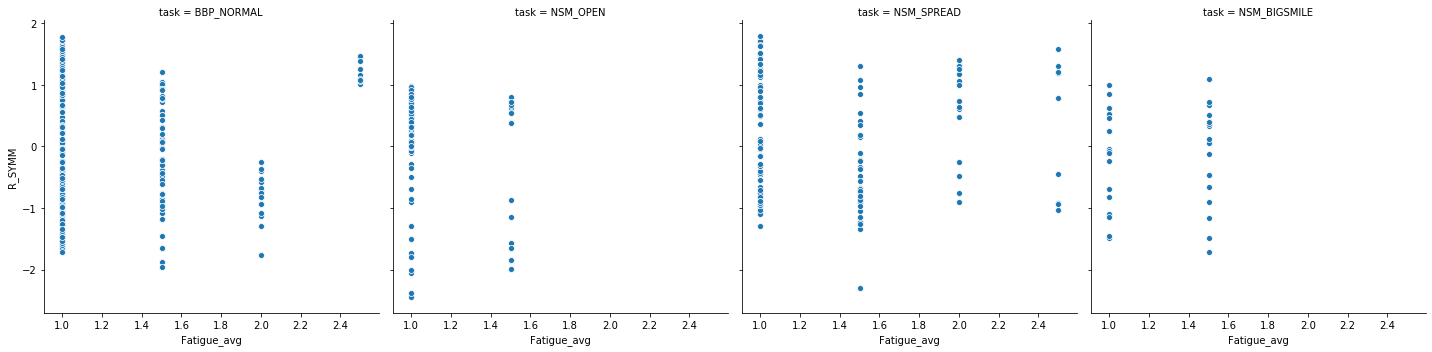

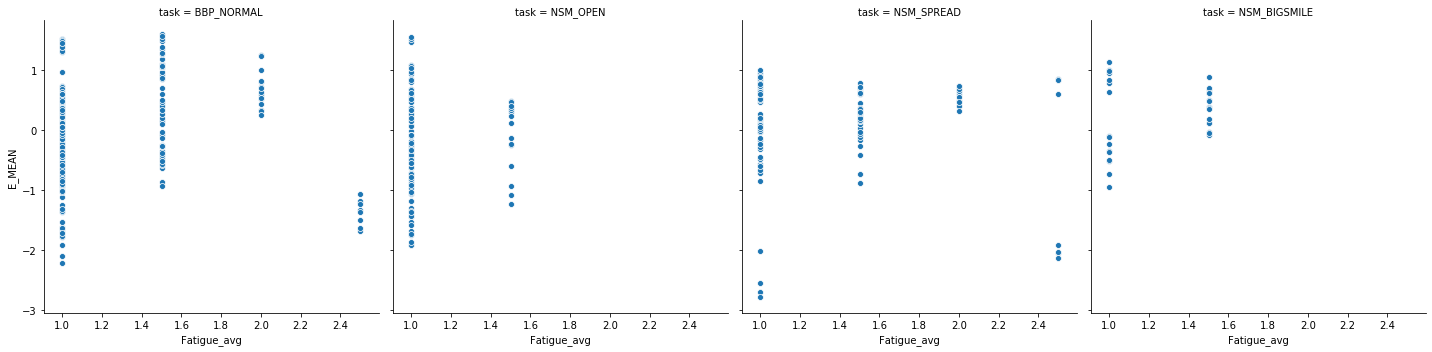

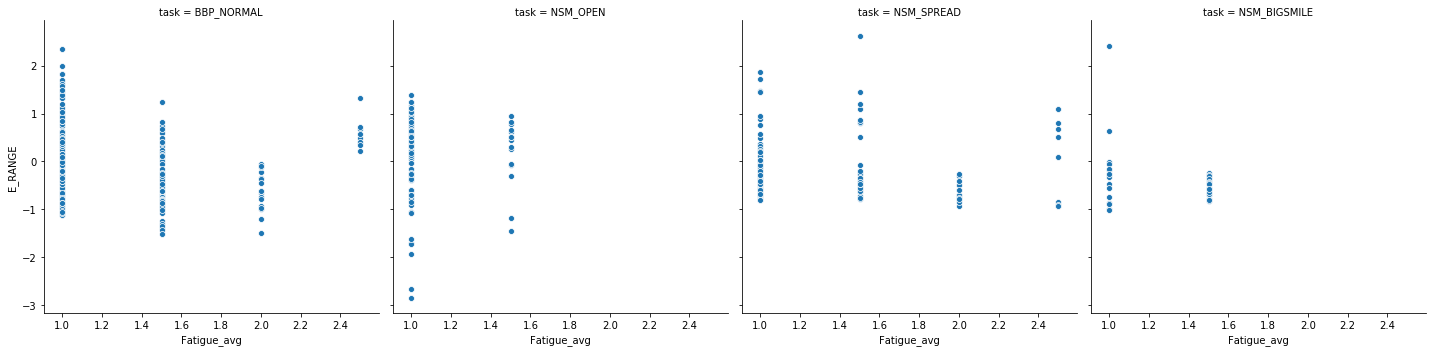

In [33]:
scores = ['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']


for score in scores:

    for f in features:
        
        g = sns.relplot(x=score, y=f, data=sub_neuro_df, kind = 'scatter', col ='task')
        #plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('STROKE_4corPlots_{}_{}'.format(score, f))
        corr, _ = spearmanr(sub_neuro_df[f], sub_neuro_df[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

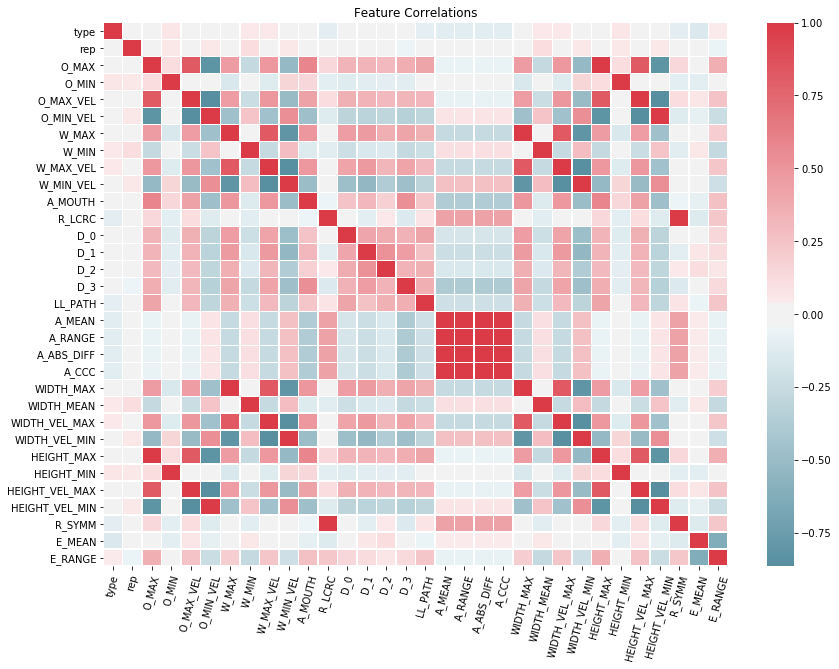

In [34]:
corr = feature_df.corr()
ax, figure = plt.subplots(figsize=(14,10))
g =sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
               center=0.00,cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.title('Feature Correlations')
plt.show()

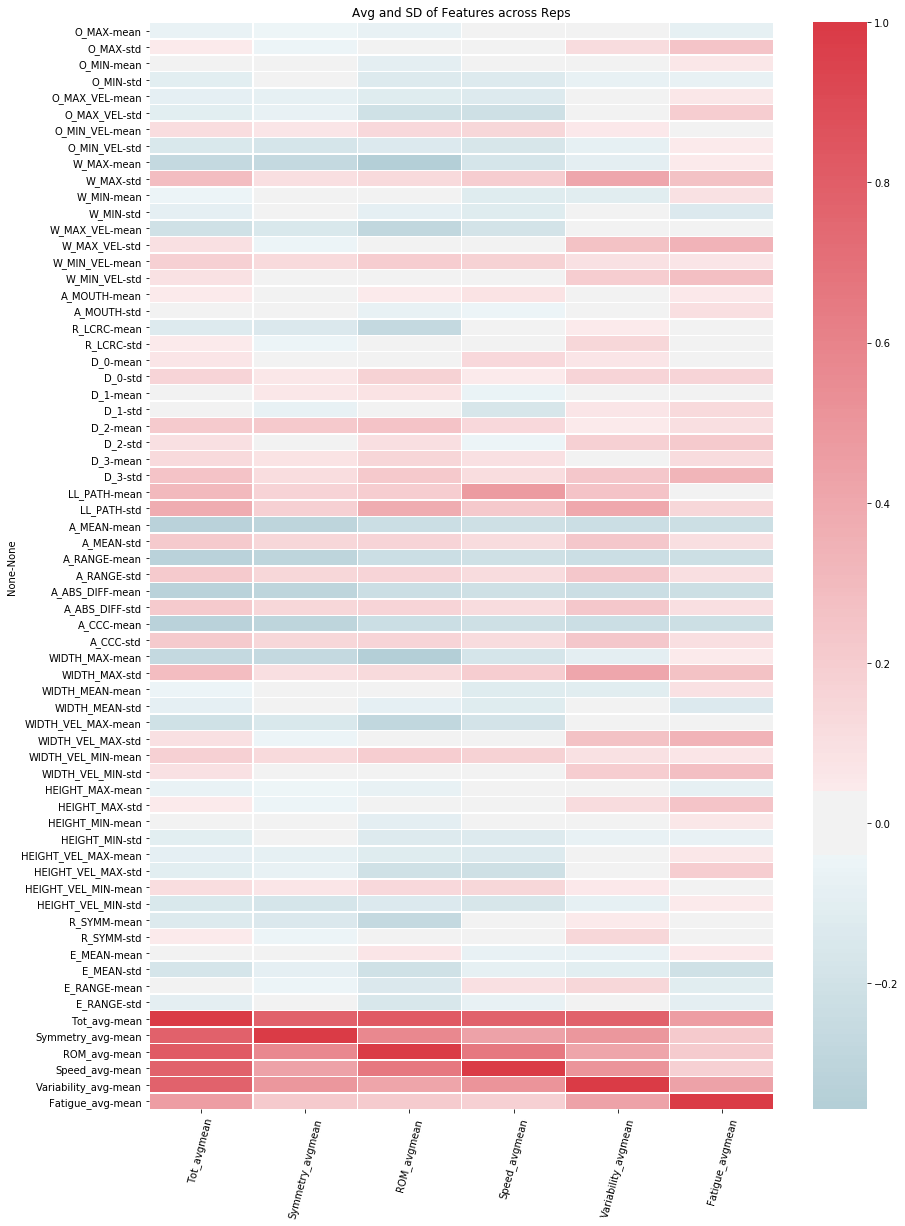

In [35]:
# run the avg and std
### Taking the average and std of the features over all the repetitions per task per participant 
task_avg_st = sub_neuro_df.groupby(['subject_id','task'])[['O_MAX', 'O_MIN', 'O_MAX_VEL', 'O_MIN_VEL',
       'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH', 'R_LCRC', 'D_0',
       'D_1', 'D_2', 'D_3', 'LL_PATH', 'A_MEAN', 'A_RANGE', 'A_ABS_DIFF',
       'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN',
       'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX', 'HEIGHT_VEL_MIN',
       'R_SYMM', 'E_MEAN', 'E_RANGE', 'Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg']].agg([np.mean, np.std])

#print(task_avg_st.shape)
#print(task_avg_st.columns)

corr = task_avg_st.corr()
corr.columns = [''.join(col) for col in corr.columns]
corr = corr.dropna(axis = 1, how='all')
corr = corr.dropna(axis = 0, how='all')

ax, figure = plt.subplots(figsize=(14,20))
sub_corr = corr[['Tot_avgmean', 'Symmetry_avgmean', 'ROM_avgmean','Speed_avgmean', 'Variability_avgmean', 'Fatigue_avgmean']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), 
               cmap=sns.diverging_palette(220, 10, as_cmap=True),center=0.00, linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.title('Avg and SD of Features across Reps')
plt.show()

In [36]:
task_avg_st.head()

O_MAX               O_MIN           O_MAX_VEL  \
                           mean       std      mean       std      mean   
subject_id task                                                           
A008       BBP_NORMAL  0.477748  0.148294  1.007766  0.430603 -0.043567   
           NSM_OPEN    0.659217  0.102355  0.001363  0.326543  0.699339   
           NSM_SPREAD -0.239712  0.145572  0.709866  0.597121  0.549580   
A009       BBP_NORMAL -0.245578  0.103329  0.243027  0.356651 -0.344772   
           NSM_SPREAD -0.484146  0.117444 -0.144375  0.597356 -0.655792   

                                O_MIN_VEL               W_MAX            ...  \
                            std      mean       std      mean       std  ...   
subject_id task                                                          ...   
A008       BBP_NORMAL  0.143394 -0.031156  0.307364  0.157357  0.144102  ...   
           NSM_OPEN    1.273660 -0.661761  0.517548 -0.452800  0.095268  ...   
           NSM_SPREAD  0.515403 -1.013405  0.785857  1.492991  0.166908  ...   
A009       BBP_NORMAL  0.128242  0.437079  0.092685  0.466044  0.209030  ...   
           NSM_SPREAD  0.225031  0.675246  0.325409 -0.681924  0.518037  ...   

                      Symmetry_avg      ROM_avg      Speed_avg       \
                              mean  std    mean  std      mean  std   
subject_id task                                                       
A008       BBP_NORMAL          2.0  0.0     1.0  0.0       1.0  0.0   
           NSM_OPEN            2.5  0.0     1.0  0.0       1.0  0.0   
           NSM_SPREAD          1.0  0.0     1.0  0.0       1.0  0.0   
A009       BBP_NORMAL          2.0  0.0     2.0  0.0       2.5  0.0   
           NSM_SPREAD          2.5  0.0     3.5  0.0       2.5  0.0   

                      Variability_avg      Fatigue_avg       
                                 mean  std        mean  std  
subject_id task                                              
A008       BBP_NORMAL             1.0  0.0         1.0  0.0  
           NSM_OPEN               1.5  0.0         1.5  0.0  
           NSM_SPREAD             2.0  0.0         2.0  0.0  
A009       BBP_NORMAL             2.0  0.0         2.5  0.0  
           NSM_SPREAD             3.5  0.0         1.5  0.0  

[5 rows x 72 columns]

In [37]:
scores_2 = ['Tot_avgmean', 'Symmetry_avgmean', 'ROM_avgmean','Speed_avgmean', 'Variability_avgmean', 'Fatigue_avgmean']

for score in scores_2:

    for f in features:
        
        g = sns.relplot(x=score, y=f, data=task_avg_st, kind = 'scatter', col ='task')
        #plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('All_AcrossReps_4corPlots_{}_{}'.format(score, f))
        corr, _ = spearmanr(task_avg_st[f], task_avg_st[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

ValueError: Could not interpret input 'Tot_avgmean'

In [ ]:
# trend corrolation analysis and scatter plots 

In [ ]:
# Calculating the trend fro fatigue 

first_rep = sub_neuro_df.loc[sub_neuro_df.groupby(['subject_id','task'])['rep'].idxmin()]

last_rep = sub_neuro_df.loc[sub_neuro_df.groupby(['subject_id','task'])['rep'].idxmax()]

trend_df = pd.DataFrame()
trend_df[features] = first_rep[features] - last_rep[features].values


#.apply(lambda x: x.rep.max() - x.rep.min())

print(trend_df.shape)
trend_df

In [ ]:
trend_df = pd.merge(trend_df, sub_neuro_df[['task','Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg','Variability_avg',
                                            'Fatigue_avg']], left_index = True, right_index=True)

In [ ]:
corr = trend_df.corr()
ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool),
               cmap=sns.diverging_palette(220, 10, as_cmap=True), center=0.00,linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

# Fine-Tuned Diego's Results 

In [ ]:
def print_prop(df, file):
    print(file)
    print('Shape: ',df.shape)
    print()
    print(df.columns)
    print()
    print('Total Number of Subjects in Df are: ', len(df.subject_id.unique()))
    print("Subjects IDs are: ",df.subject_id.unique())

    print()



### Diego Stroke DATA 

In [ ]:
### STROKE DATA

tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
task = 0# 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE

stroke_file_1 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_"+tasks[task]+".csv"
stroke_file_2 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_database_finetuned/metric_output_"+tasks[task]+".csv"
stroke_file_3 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
stroke_file_4 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_old_finetuned/metric_output_"+tasks[task]+".csv"


bbp_s_df_1 = pd.read_csv(stroke_file_1)
bbp_s_df_1 = bbp_s_df_1.drop('Unnamed: 0', axis=1)
print_prop(bbp_s_df_1, stroke_file_1)



bbp_s_df_2 = pd.read_csv(stroke_file_2)
bbp_s_df_2 = bbp_s_df_2.drop('Unnamed: 0', axis=1)
print_prop(bbp_s_df_2, stroke_file_2)



bbp_s_df_3 = pd.read_csv(stroke_file_3)
bbp_s_df_3 = bbp_s_df_3.drop('Unnamed: 0', axis=1)
print_prop(bbp_s_df_3, stroke_file_3)



bbp_s_df_4 = pd.read_csv(stroke_file_4)
bbp_s_df_4 = bbp_s_df_4.drop('Unnamed: 0', axis=1)
print_prop(bbp_s_df_4, stroke_file_4)

In [ ]:
bbp_s_df_1.head()

In [ ]:
print('1 includes 2: ', set(bbp_s_df_2.subject_id.unique()).issubset(bbp_s_df_1.subject_id.unique()))
print('1 includes 3: ', set(bbp_s_df_3.subject_id.unique()).issubset(bbp_s_df_1.subject_id.unique()))
print('1 includes 4: ', set(bbp_s_df_4.subject_id.unique()).issubset(bbp_s_df_1.subject_id.unique()))

In [ ]:
for task in range(len(tasks)):
    
    stroke_file_1 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_"+tasks[task]+".csv"
    stroke_file_2 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_database_finetuned/metric_output_"+tasks[task]+".csv"
    stroke_file_3 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
    stroke_file_4 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_old_finetuned/metric_output_"+tasks[task]+".csv"


    print(tasks[task])
    try: 
        df_1 = pd.read_csv(stroke_file_1)
        #df_1 = df_1.drop('Unnamed: 0', axis=1)
        print("df1 shape: ", df_1.shape)
        df_2 = pd.read_csv(stroke_file_2)
        #df_2 = df_2.drop('Unnamed: 0', axis=1)
        print("df2 shape: ", df_2.shape)
        df_3 = pd.read_csv(stroke_file_3)
        #df_3 = df_3.drop('Unnamed: 0', axis=1)
        print("df3 shape: ", df_3.shape)
        df_4 = pd.read_csv(stroke_file_4)
        print("df4 shape: ", df_4.shape)
        #df_4 = df_4.drop('Unnamed: 0', axis=1)
        
    except: 
        pass

    print('1 includes 2: ', set(df_2.subject_id.unique()).issubset(df_1.subject_id.unique()))
    print('1 includes 3: ', set(df_3.subject_id.unique()).issubset(df_1.subject_id.unique()))
    print('1 includes 4: ', set(df_4.subject_id.unique()).issubset(df_1.subject_id.unique()))


In [ ]:
stroke_df = pd.DataFrame()

for task in range(len(tasks)):
    
    stroke_file = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_"+tasks[task]+".csv"
    
    df = pd.read_csv(stroke_file)
    df = df.drop('Unnamed: 0', axis=1)
    stroke_df = pd.concat([stroke_df, df], ignore_index=True)

    
    
print(stroke_df.shape)



In [ ]:
stroke_df['population'] = [pop_labeler(x) for x in stroke_df['subject_id']]
stroke_df.head()

In [ ]:

print('len: ' , len(stroke_df))
print(len(stroke_df.columns))
print(stroke_df.columns)
print(stroke_df.groupby(['population']).subject_id.unique())
print(stroke_df.task.unique())

with np.printoptions(threshold=np.inf):
    print(stroke_df.groupby(['population']).subject_id.unique())
    print(len(stroke_df.subject_id.unique()))
    
print(np.intersect1d(stroke_df.subject_id.unique(),neuroface_subjects))
print(len(np.intersect1d(stroke_df.subject_id.unique(),neuroface_subjects)))

In [ ]:
len(stroke_df.groupby(['population']).subject_id.unique()['Stroke'])

In [ ]:
stroke_df.groupby(['population','task']).count()

In [ ]:
# TASKS 
ax, figure = plt.subplots(figsize=(10,7))
g = sns.countplot(x='task',data=stroke_df,hue='population')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

# set axes labels and title
plt.ylabel('# of reps')
plt.title('Total Number of reps analyzed for each clinical task')
plt.show()

# Getting the corrolations based on the common data with clinical scores 

In [ ]:
slp_scores

In [ ]:
stroke_df

In [ ]:
stroke_and_scores = stroke_df.merge(slp_scores, how= 'inner', left_on=['subject_id', 'task'], right_on=['Subject ID', 'task'])

print(len(stroke_and_scores.subject_id.unique()))
print(stroke_and_scores.subject_id.unique())
print(stroke_and_scores.task.unique())

print(stroke_df.shape)
print(stroke_and_scores.shape)
print(stroke_and_scores.columns)

In [ ]:
# filtering out the outliers 

z_scores = stats.zscore(stroke_and_scores[['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_stroke_and_scores = stroke_and_scores[filtered_entries]

print(new_stroke_and_scores.shape)

In [ ]:
just_stroke = new_stroke_and_scores.loc[new_stroke_and_scores['type']== 1]

z_scores = stats.zscore(just_stroke[['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
just_stroke = just_stroke[filtered_entries]

print(just_stroke.shape)


In [ ]:
stroke_features = ['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']

tasks = ['BBP_NORMAL', 'NSM_OPEN' ,'NSM_SPREAD' ,'NSM_BIGSMILE']

scores = ['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']


for score in scores:

    for f in stroke_features:
        
        g = sns.relplot(x=score, y=f, data=just_stroke, kind = 'scatter', col ='task')
        #plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('STROKE_4corPlots_{}_{}'.format(score, f))
        corr, _ = spearmanr(just_stroke[f], just_stroke[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

        # calculate spearman's correlation

### Figuring out the trend by Trend = 1st repetition feature values - Last repetition feature values 
### for each task per participant 

In [ ]:
# Calculating the trend fro fatigue 

first_rep = just_stroke.loc[just_stroke.groupby(['subject_id','task'])['rep'].idxmin()]

last_rep = just_stroke.loc[just_stroke.groupby(['subject_id','task'])['rep'].idxmax()]

trend_df = pd.DataFrame()
trend_df[['O_MAX_diff', 'O_MIN_diff','O_MAX_VEL_diff', 'O_MIN_VEL_diff', 'W_MAX_diff', 'W_MIN_diff', 'W_MAX_VEL_diff', 'W_MIN_VEL_diff',
       'A_MOUTH_diff', 'R_LCRC_diff', 'D_0_diff', 'D_1_diff', 'D_2_diff', 'D_3_diff']] = first_rep[['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']] - last_rep[['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']].values


#.apply(lambda x: x.rep.max() - x.rep.min())

print(trend_df.shape)
trend_df

In [ ]:
trend_df = pd.merge(trend_df, just_stroke[['task','Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']], left_index = True, right_index=True)

In [ ]:
# Scatter plot for the trend 

for score in scores:

    for f in stroke_features:
        
        g = sns.relplot(x=score, y=f+'_diff', data=trend_df, kind = 'scatter', col ='task')
        #plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('STROKE_4corPlots_{}_{}'.format(score, f+'_diff'))
        corr, _ = spearmanr(just_stroke[f], just_stroke[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [ ]:
corr = trend_df.corr()

In [ ]:
ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

In [ ]:
# working example of agg with definition of fuction 

def diff(x):
    return np.max(x) - np.min(x)

just_stroke.groupby(['subject_id','task'])['rep'].agg([np.max,np.min, diff])

### Taking the average and std of the features over all the repetitions per task per participant 

In [ ]:
### Taking the average and std of the features over all the repetitions per task per participant 
stroke_task_avg = just_stroke.groupby(['subject_id','task'])[['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3', 'Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']].agg([np.mean, np.std])

print(stroke_task_avg.shape)
print(stroke_task_avg.columns)

In [ ]:
corr = stroke_task_avg.corr()

In [ ]:
corr.columns = [''.join(col) for col in corr.columns]
corr = corr.dropna(axis = 1, how='all')
corr = corr.dropna(axis = 0, how='all')

ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avgmean', 'Symmetry_avgmean', 'ROM_avgmean','Speed_avgmean', 'Variability_avgmean', 'Fatigue_avgmean']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

In [ ]:
# raw data corrolations and scatter plots between each feature and a single clinical score 

stroke_features = ['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']

tasks = ['BBP_NORMAL', 'NSM_OPEN' ,'NSM_SPREAD' ,'NSM_BIGSMILE']



for score in scores:

    for task in tasks: 
        for f in stroke_features:
            plt.figure()
            ax, figure = plt.subplots(figsize=(10,7))
            score = 'ROM_avg'
            sns.scatterplot(x=score, y=f, data=just_stroke, hue='task')
            plt.title('The scatter plot between {} and {}'.format(f, score ))

            # calculate spearman's correlation
            #corr, _ = spearmanr(stroke_and_scores[f], stroke_and_scores[score])
            #print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [ ]:
# outliers removed scatter plot and corrolations between each feature and a single clinical score 
scores = ['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']


for score in scores: 
    
    for f in stroke_features:
        plt.figure()
        ax, figure = plt.subplots(figsize=(10,7))
        
        sns.scatterplot(x=score, y=f, data=just_stroke, hue='task', style='population_y')
        plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('STROKE_{}_{}'.format(score, f))

        # calculate spearman's correlation
        corr, _ = spearmanr(new_stroke_and_scores[f], new_stroke_and_scores[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [ ]:
new_stroke_and_scores.columns

In [ ]:
sub_stroke = new_stroke_and_scores[['subject_id', 'task', 'type', 'rep', 'O_MAX', 'O_MIN', 'O_MAX_VEL',
       'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH',
       'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3', 'Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg', 'population_y']]

In [ ]:
corr = sub_stroke.corr()

In [ ]:
ax, figure = plt.subplots(figsize=(14,10))
sub_corr_f = corr[['rep', 'O_MAX', 'O_MIN', 'O_MAX_VEL',
       'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH',
       'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
sub_corr_f = sub_corr_f.drop(['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg'], axis=0)
g =sns.heatmap(sub_corr_f, mask=np.zeros_like(sub_corr_f, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

In [ ]:
# corrolation of clinical scores to themselves and the features 

ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

In [ ]:

ax, figure = plt.subplots(figsize=(14,10))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(corr, mask=mask, vmax=.3, square=True)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

### Diego ALS DATA 

In [ ]:
### ALS DATA
tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
task = 0# 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE
als_file_1 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_"+tasks[task]+".csv"
als_file_2 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
als_file_3 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_old_finetuned/metric_output_"+tasks[task]+".csv"


bbp_als_df_1 = pd.read_csv(als_file_1)
bbp_als_df_1 = bbp_als_df_1.drop('Unnamed: 0', axis=1)
print_prop(bbp_als_df_1, als_file_1)


bbp_als_df_2 = pd.read_csv(als_file_2)
bbp_als_df_2 = bbp_als_df_2.drop('Unnamed: 0', axis=1)
print_prop(bbp_als_df_2, als_file_2)


bbp_als_df_3 = pd.read_csv(als_file_3)
bbp_als_df_3 = bbp_als_df_3.drop('Unnamed: 0', axis=1)
print_prop(bbp_als_df_3, als_file_3)



In [ ]:
print('3 includes 1: ', set(bbp_als_df_1.subject_id.unique()).issubset(bbp_als_df_3.subject_id.unique()))

print('2 includes 1: ', set(bbp_als_df_1.subject_id.unique()).issubset(bbp_als_df_2.subject_id.unique()))

print(bbp_als_df_1.subject_id.unique())
print(bbp_als_df_2.subject_id.unique())
print(bbp_als_df_3.subject_id.unique())

In [ ]:
bbp_als_df_1.loc[bbp_als_df_1['subject_id'] == 'A008']

In [ ]:
bbp_als_df_3.loc[bbp_als_df_3['subject_id'] == 'A008']

In [ ]:
diego_bbp = bbp_als_df_1.merge(bbp_als_df_2)
diego_bbp = diego_bbp.merge(bbp_als_df_3)
uncommon_1 = bbp_als_df_1.loc[~bbp_als_df_1.subject_id.isin(diego_bbp.subject_id)]
uncommon_2 = bbp_als_df_2.loc[~bbp_als_df_2.subject_id.isin(diego_bbp.subject_id)]
uncommon_3 = bbp_als_df_3.loc[~bbp_als_df_3.subject_id.isin(diego_bbp.subject_id)]

print('shapes: ',uncommon_1.shape, uncommon_2.shape, uncommon_3.shape)

diego_bbp = pd.concat([diego_bbp, uncommon_1, uncommon_2, uncommon_3], ignore_index=True)

print_prop(diego_bbp, als_file_3)

In [ ]:
als_df = pd.DataFrame()

for task in range(len(tasks)):
    als_file_1 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_"+tasks[task]+".csv"
    als_file_2 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
    als_file_3 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_old_finetuned/metric_output_"+tasks[task]+".csv"
    
    try: 
        als_df_1 = pd.read_csv(als_file_1)
    except:
        pass
    try:
        als_df_2 = pd.read_csv(als_file_2)
    except:
        pass
    try:
        als_df_3 = pd.read_csv(als_file_3)
    except:
        pass
    als_df = pd.concat([als_df, als_df_1, als_df_2, als_df_3], ignore_index=True)



    
print(als_df.shape)


In [ ]:
als_df = als_df.drop_duplicates()

als_df = als_df.drop('Unnamed: 0', axis=1)

In [ ]:
print(len(als_df_1.groupby(['population']).subject_id.unique()['ALS']))
print(len(als_df_1.groupby(['population']).subject_id.unique()['HC']))
print(als_df_1.groupby(['population']).subject_id.unique()['ALS'])
print(als_df_1.groupby(['population']).subject_id.unique()['HC'])

In [ ]:
als_df['population'] = [pop_labeler(x) for x in als_df['subject_id']]

In [ ]:
print(als_df.shape)
print(als_df.columns)
print(als_df.task.unique())
print(als_df.subject_id.unique())
print(len(als_df.subject_id.unique()))
print(len(als_df.groupby(['population']).subject_id.unique()['ALS']))
print(len(als_df.groupby(['population']).subject_id.unique()['HC']))
print(als_df.groupby(['population']).subject_id.unique()['ALS'])
print(als_df.groupby(['population']).subject_id.unique()['HC'])

In [ ]:
# Print the needed info 

print(np.intersect1d(als_df.subject_id.unique(),neuroface_subjects))
print(len(np.intersect1d(als_df.subject_id.unique(),neuroface_subjects)))

In [ ]:
als_df

In [ ]:
als_and_scores = als_df.merge(slp_scores, how= 'inner', left_on=['subject_id', 'task'], right_on=['Subject ID', 'task'])

print(len(als_and_scores.subject_id.unique()))
print(als_and_scores.subject_id.unique())
print(als_and_scores.task.unique())

print(als_df.shape)
print(als_and_scores.shape)
print(als_and_scores.columns)

In [ ]:
# raw data corrolations and scatter plots between each feature and a single clinical score 

als_features = ['LL_PATH', 'A_MEAN', 'A_RANGE','A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 
                   'WIDTH_VEL_MAX','WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']

for f in als_features:
    plt.figure()
    ax, figure = plt.subplots(figsize=(10,7))
    score = 'ROM_avg'
    sns.scatterplot(x=score, y=f, data=als_and_scores, hue='task', style='population_y')
    plt.title('The scatter plot between {} and {}'.format(f, score ))

    # calculate spearman's correlation
    corr, _ = spearmanr(als_and_scores[f], als_and_scores[score])
    print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [ ]:
# filtering out the outliers 

z_scores = stats.zscore(als_and_scores[['LL_PATH', 'A_MEAN', 'A_RANGE','A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 
                   'WIDTH_VEL_MAX','WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_als_and_scores = als_and_scores[filtered_entries]

print(new_als_and_scores.shape)

In [ ]:
#f, axes = plt.subplots(4, 4, figsize=(7, 7))

scores = ['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']
for score in scores: 
    for f in als_features:
        plt.figure()
        ax, figure = plt.subplots(figsize=(10,7))
        #score = 'ROM_avg'
        sns.scatterplot(x=score, y=f, data=new_als_and_scores, hue='task', style='population_y')
        plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('ALS_{}_{}'.format(score, f))

        # calculate spearman's correlation
        corr, _ = spearmanr(new_als_and_scores[f], new_als_and_scores[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [ ]:
new_als_and_scores.columns

In [ ]:
sub_als = new_als_and_scores[['subject_id', 'task', 'type','rep', 'LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE', 'population_x',
       'File Name', 'Subject ID', 'Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg', 'population_y']]

In [ ]:
print(sub_als.shape)
sub_als.loc[sub_als['subject_id'] != sub_als['Subject ID']]

In [ ]:
corr = sub_als.corr()

In [ ]:
ax, figure = plt.subplots(figsize=(14,10))
sub_corr_f = corr[['rep', 'LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
sub_corr_f = sub_corr_f.drop(['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg'], axis=0)
g =sns.heatmap(sub_corr_f, mask=np.zeros_like(sub_corr_f, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

In [ ]:
# corrolation of clinical scores to themselves and the features 


ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()


In [ ]:
print(corr.shape)
print(corr.columns)
print(sub_corr.columns)
print(sub_corr.shape)

In [ ]:
### Taking the average and std of the features over all the repetitions per task per participant 
als_task_avg = sub_als.groupby(['subject_id','task'])[['LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE', 'Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']].agg([np.mean, np.std])

print(als_task_avg.shape)
print(als_task_avg.columns)

In [ ]:
corr = als_task_avg.corr()
corr.columns = [''.join(col) for col in corr.columns]
corr = corr.dropna(axis = 1, how='all')
corr = corr.dropna(axis = 0, how='all')

ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avgmean', 'Symmetry_avgmean', 'ROM_avgmean','Speed_avgmean', 'Variability_avgmean', 'Fatigue_avgmean']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

# TREND of the features

In [ ]:
# Calculating the trend fro fatigue 

first_rep = sub_als.loc[sub_als.groupby(['subject_id','task'])['rep'].idxmin()]

last_rep = sub_als.loc[sub_als.groupby(['subject_id','task'])['rep'].idxmax()]

trend_als_df = pd.DataFrame()
trend_als_df[['LL_PATH_diff', 'A_MEAN_diff', 'A_RANGE_diff',
       'A_ABS_DIFF_diff', 'A_CCC_diff', 'WIDTH_MAX_diff', 'WIDTH_MEAN_diff', 'WIDTH_VEL_MAX_diff',
       'WIDTH_VEL_MIN_diff', 'HEIGHT_MAX_diff', 'HEIGHT_MIN_diff', 'HEIGHT_VEL_MAX_diff',
       'HEIGHT_VEL_MIN_diff', 'R_SYMM_diff', 'E_MEAN_diff', 'E_RANGE_diff']] = first_rep[['LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']] - last_rep[['LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']].values


#.apply(lambda x: x.rep.max() - x.rep.min())

print(trend_als_df.shape)
trend_als_df = pd.merge(trend_als_df, sub_als[['task','Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 
                                               'Variability_avg', 'Fatigue_avg']], left_index = True, right_index=True)
print(trend_als_df.shape)

In [ ]:
# corrolation plot 

corr = trend_als_df.corr()
ax, figure = plt.subplots(figsize=(14,10))
sub_corr = corr[['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']]
#mask = np.zeros_like(sub_corr)
#mask[np.triu_indices_from(mask)] = True
g =sns.heatmap(sub_corr, mask=np.zeros_like(sub_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
plt.show()

In [ ]:
# scatter plot

# Scatter plot for the trend 

for score in scores:

    for f in als_features:
        f= f+'_diff'
        g = sns.relplot(x=score, y=f, data=trend_als_df, kind = 'scatter', col ='task')
        #plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('ALS_4corPlots_{}_{}'.format(score, f))
        corr, _ = spearmanr(trend_als_df[f], trend_als_df[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [ ]:
just_als = new_als_and_scores.loc[new_als_and_scores['type']== 1]

z_scores = stats.zscore(just_als[[ 'LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
just_als = just_als[filtered_entries]

print(just_als.shape)

In [ ]:
als_features = ['LL_PATH', 'A_MEAN', 'A_RANGE', 'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 
                   'WIDTH_VEL_MAX', 'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
                   'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']

tasks = ['BBP_NORMAL', 'NSM_OPEN' ,'NSM_SPREAD' ,'NSM_BIGSMILE']

scores = ['Tot_avg', 'Symmetry_avg', 'ROM_avg','Speed_avg', 'Variability_avg', 'Fatigue_avg']


for score in scores:

    for f in als_features:
        
        g = sns.relplot(x=score, y=f, data=just_als, kind = 'scatter', col ='task')
        #plt.title('The scatter plot between {} and {}'.format(f, score ))
        plt.savefig('ALS_4corPlots_{}_{}'.format(score, f))
        corr, _ = spearmanr(just_als[f], just_als[score])
        print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

# UP to here

In [ ]:
ax, figure = plt.subplots(figsize=(10,7))
g = sns.countplot(x='task',data=als_df,hue='population')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

# set axes labels and title
plt.ylabel('# of reps')
plt.title('Total Number of reps analyzed for each clinical task')
plt.show()

In [ ]:
#bbp_als_df_1.loc[~bbp_als_df_.subject_id.isin(a.subject_id)]



In [ ]:

np.intersect1d(diego_bbp.subject_id.unique(),neuroface_subjects)



Features of the tasks seperated into repetitions 

In [ ]:
# Standardized BBP 

path4 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_BBP_NORMAL_standardized.csv'

bbp_df = pd.read_csv(path4)

print(len(bbp_df))
print(len(bbp_df.columns))
print(bbp_df.columns)
print(bbp_df.subject_id.unique())
bbp_df.head()


# Standardized Open

path6 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_NSM_OPEN_standardized.csv'

open_df = pd.read_csv(path6)

print(len(open_df))
print(len(open_df.columns))
print(open_df.subject_id.unique())
print(open_df.columns)
open_df.head()

# Standardized Big Smile

path5 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_NSM_BIGSMILE_standardized.csv'

bigs_df = pd.read_csv(path5)

print(len(bigs_df))
print(len(bigs_df.columns))
print(bigs_df.columns)
print(bigs_df.subject_id.unique())
bigs_df.head()


# Standardized Spread

path7 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_NSM_SPREAD_standardized.csv'

spread_df = pd.read_csv(path7)

print(len(spread_df))
print(len(spread_df.columns))
print(spread_df.columns)
print(spread_df.subject_id.unique())
spread_df.head()

Plotting the corrolation of the 

In [ ]:
stroke_features = ['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']

for f in stroke_features:
    plt.figure()
    ax, figure = plt.subplots(figsize=(10,7))
    sns.scatterplot(x='Tot_avg', y=f, data=df_f2, hue='subject_id')

    # calculate spearman's correlation
    corr, _ = spearmanr(df_f2[f], df_f2['Tot_avg'])
    print('Spearmans correlation: %.3f' % corr)

## Stroke data

In [ ]:
# SLP SCORES

path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/Stroke/SLP_Assessment_PS.csv'
ps_df = pd.read_csv(path)

ps_df = ps_df.drop('Unnamed: 8', axis=1)

# average of the clinical scores 

ps_df['Tot_avg'] = ps_df.apply(lambda row: (row['Tot (SLP1)'] + row["Tot (SLP2)"])/2, axis=1)
ps_df['Symmetry_avg'] = ps_df.apply(lambda row: (row['Symmetry (SLP1)'] + row["Symmetry (SLP2)"])/2, axis=1)
ps_df['ROM_avg'] = ps_df.apply(lambda row: (row['ROM (SLP1)'] + row["ROM (SLP2)"])/2, axis=1)
ps_df['Speed_avg'] = ps_df.apply(lambda row: (row['Speed (SLP1)'] + row["Speed (SLP2)"])/2, axis=1)
ps_df['Variability_avg'] = ps_df.apply(lambda row: (row['Variability (SLP1)'] + row["Variability (SLP2)"])/2, axis=1)
ps_df['Fatigue_avg'] = ps_df.apply(lambda row: (row['Fatigue (SLP1)'] + row["Fatigue (SLP2)"])/2, axis=1)



print('len: ', len(ps_df))
print(ps_df.columns)
print(ps_df['Subject ID'].unique())
ps_df.head()

In [ ]:
tasks = ['BBP_NORMAL', 'PA', 'PATAKA', 'BLOW', 'KISS', 'OPEN', 'SPREAD', 'BIGSMILE', 'BROW']

def task_labeler(row):
    for t in tasks: 
        if t in row: 
            return t
    

ps_df['task'] = [task_labeler(x) for x in ps_df['File Name']]

ps_df.head()

In [ ]:
print(ps_df.shape)
print(ps_df['Subject ID'].unique())

In [ ]:
ps_df_bbp = ps_df[ps_df['task']== 'BBP_NORMAL']

In [ ]:
print(ps_df.shape)

print(ps_df_bbp.shape)
print(ps_df_bbp['Subject ID'].unique())
ps_df_bbp.head()

In [ ]:
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_BBP_NORMAL_standardized.csv'

s_bbp_df = pd.read_csv(path)

print('len: ' , len(s_bbp_df))
print(len(s_bbp_df.columns))
print(s_bbp_df.columns)
print(s_bbp_df.subject_id.unique())
print(s_bbp_df.task.unique())
s_bbp_df.head()

In [ ]:
df_f = s_bbp_df.merge(ps_df_bbp, how= 'inner', left_on='subject_id', right_on='Subject ID')

print(df_f.size)
print(df_f.shape)
print(ps_df_bbp.shape)
print(s_bbp_df.shape)
print('len: ', len(df_f))

print(df_f.Tot_avg.isnull().count())

df_f.Tot_avg

In [ ]:
df_f.head()

In [ ]:
df_f.subject_id.unique()

In [ ]:
g = sns.FacetGrid(df_f, col="subject_id", col_wrap=3, height=5, ylim=(0, 20))
g.map(sns.pointplot, "O_MAX", "Tot_avg",color=".3", ci=None);

In [ ]:
ax, figure = plt.subplots(figsize=(10,7))
plt.scatter(df_f['Tot_avg'], df_f["O_MAX"])


# calculate spearman's correlation
corr, _ = spearmanr(df_f["O_MAX"], df_f['Tot_avg'])
print('Spearmans correlation: %.3f' % corr)

In [ ]:
ax, figure = plt.subplots(figsize=(10,7))
sns.scatterplot(x='Tot_avg', y="O_MAX", data=df_f, hue='subject_id')

# calculate spearman's correlation
corr, _ = spearmanr(df_f["O_MAX"], df_f['Tot_avg'])
print('Spearmans correlation: %.3f' % corr)

In [ ]:
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_database_finetuned/metric_output_BBP_NORMAL_standardized.csv'

s_bbp2_df = pd.read_csv(path)

print(len(s_bbp2_df))
print(len(s_bbp2_df.columns))
print(s_bbp2_df.columns)
print(s_bbp2_df.subject_id.unique())
s_bbp2_df

In [ ]:
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_BBP_NORMAL_standardized.csv'

als_bbp2_df = pd.read_csv(path)

print(len(als_bbp2_df))
print(len(als_bbp2_df.columns))
print(als_bbp2_df.columns)
print(als_bbp2_df.subject_id.unique())
als_bbp2_df

### BBP_NORMAL ACROSS ALL SUBJECTS ANALYSIS

In [ ]:
# obtaining the clinical data for bbp task only 
df_bbp = slp_scores[slp_scores['task']== 'BBP_NORMAL']

# merging the clinical data with the features 
df_f1 = als_bbp2_df.merge(df_bbp, how= 'inner', left_on='subject_id', right_on='Subject ID')
df_f2 = s_bbp2_df.merge(df_bbp, how= 'inner', left_on='subject_id', right_on='Subject ID')

print(df_f1.subject_id.unique())
print(df_f2.subject_id.unique())


In [ ]:
df_f1.columns

In [ ]:
df_f2.columns

In [ ]:
stroke_features = ['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']

for f in stroke_features:
    plt.figure()
    ax, figure = plt.subplots(figsize=(10,7))
    sns.scatterplot(x='Tot_avg', y=f, data=df_f2, hue='subject_id')

    # calculate spearman's correlation
    corr, _ = spearmanr(df_f2[f], df_f2['Tot_avg'])
    print('Spearmans correlation: %.3f' % corr)

In [ ]:
stroke_to_regr_df = df_f2[['subject_id', 'task_x','Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg',
       'Variability_avg', 'Fatigue_avg', 'O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']]



In [ ]:
stroke_to_regr_df

## Running RF Regression on the data

In [ ]:
print(sub_als.columns)
sub_als.head()

In [ ]:
sub_als.columns[3:20]
sub_als.columns[23]

In [ ]:
def regressor(data, regr, col): 
    
    # col will tell us which clinical score we will predict, there are 5 of them 
    # regr is the type of regression model we use, start testing with rf regressor
    # data is the df 
    
    # we will do leave one subject out for evaluating the model 
    subjects  = data['subject_id'].unique()
    
    all_y = []
    all_y_star = []

    all_y_subject = []
    all_prob_subject = []
    
    for s in subjects: 
        values_train = data.loc[data.subject_id != s].values  
        
        ##### need to change this based on the df structure in my setup!!!!!!!!!
        ### change 4, for y is already made the change 
        X_train = values_train[:,3:20]
        y_train = values_train[:,col]

        values_test = data.loc[data.subject_id == s].values  
        X_test = values_test[:,3:20]
        # reps of the same task for a given subject 
        y_test = values_test[:,col]
        

        regr_fit = regr.fit(X_train,y_train)
        results = regr_fit.predict(X_test)#[:,1]
        
        all_y.append(y_test)
        all_y_star.append(results)
        
        
           # average out the predictions of the reps of the task to get one final vlue for clinical score
        all_y_subject.append(np.mean(y_test[:]))
        all_prob_subject.append(np.mean(results[:]))
        
        #print(clf_fit.feature_importances_)
        #print('y-all-subj: ' , all_y_subject)
        #print('y_all_star-subj: ', all_prob_subject)
        

    
    #flat_list_y = [item for sublist in all_y for item in sublist]
    #flat_list_prob = [item for sublist in all_y_star for item in sublist]
    
    #print('y-all-flat: ' , flat_list_y)
    #print('y_all_star-flat: ', flat_list_prob)
    #return np.array(all_y_subject).astype(int),np.array(all_prob_subject), np.array(flat_list_y).astype(int), np.array(flat_list_prob)
    return np.array(all_y_subject), np.array(all_prob_subject)

In [ ]:
### BBP_NORMAL Task 

regr = RandomForestRegressor(n_jobs=-1, random_state=42)


clinical_measure = ['Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg','Variability_avg', 'Fatigue_avg']
col = 23  # 2-> Tot_avg, 3-> Symmetry_avg, 4-> ROM_avg, 5-> Speed_avg, 6-> Variability_avg, 7-> Fatigue_avg
#all_y_subject_finetuned,all_prob_subject_finetuned,all_y_finetuned,all_prob_finetuned = regressor(Data_3D, regr)

all_y_subject,all_prob_subject = regressor(sub_als, regr, col)

idx = 0
print('clinical_measure: ', clinical_measure[idx])
print("y: ",all_y_subject)
print("prediction: ",all_prob_subject)

corr, _ = spearmanr(all_y_subject, all_prob_subject)
print('Spearmans correlation: %.3f' % corr)
print()


plt.figure()
ax, figure = plt.subplots(figsize=(10,7))
#score = 'ROM_avg'
plt.scatter(x=all_y_subject, y=all_prob_subject)

plt.xlabel('True Labels');
plt.ylabel('Predicted Labels');
plt.title('The scatter plot between y and prediction for total score in ALS')
#plt.savefig('ALS_{}_{}'.format(score, f))



if 0:

    fpr_finetuned, tpr_finetuned, thresholds_finetuned = roc_curve(all_y_subject_finetuned,all_prob_subject_finetuned,pos_label=0)
    roc_auc_finetuned= auc(fpr_finetuned, tpr_finetuned)



    plt.figure(1, figsize=(12,6))
    plt.plot(fpr_finetuned, tpr_finetuned, lw=2, alpha=0.75, color='r');

    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100),'k')
    plt.ylabel('True Positive');
    plt.xlabel('False Positive');
    plt.legend(['finetuned model - AUC ='+str(np.round(roc_auc_finetuned,2))]);

In [ ]:
print(sub_stroke.columns)
sub_stroke.head()

In [ ]:
sub_stroke.columns[18]

In [ ]:
def regressor_stroke(data, regr, col): 
    
    # col will tell us which clinical score we will predict, there are 5 of them 
    # regr is the type of regression model we use, start testing with rf regressor
    # data is the df 
    
    # we will do leave one subject out for evaluating the model 
    subjects  = data['subject_id'].unique()
    
    all_y = []
    all_y_star = []

    all_y_subject = []
    all_prob_subject = []
    
    for s in subjects: 
        values_train = data.loc[data.subject_id != s].values  
        
        ##### need to change this based on the df structure in my setup!!!!!!!!!
        ### change 4, for y is already made the change 
        X_train = values_train[:,3:18]
        y_train = values_train[:,col]

        values_test = data.loc[data.subject_id == s].values  
        X_test = values_test[:,3:18]
        # reps of the same task for a given subject 
        y_test = values_test[:,col]
        

        regr_fit = regr.fit(X_train,y_train)
        results = regr_fit.predict(X_test)#[:,1]
        
        all_y.append(y_test)
        all_y_star.append(results)
        
        
           # average out the predictions of the reps of the task to get one final vlue for clinical score
        all_y_subject.append(np.mean(y_test[:]))
        all_prob_subject.append(np.mean(results[:]))
        
        #print(clf_fit.feature_importances_)
        #print('y-all-subj: ' , all_y_subject)
        #print('y_all_star-subj: ', all_prob_subject)
        

    
    #flat_list_y = [item for sublist in all_y for item in sublist]
    #flat_list_prob = [item for sublist in all_y_star for item in sublist]
    
    #print('y-all-flat: ' , flat_list_y)
    #print('y_all_star-flat: ', flat_list_prob)
    #return np.array(all_y_subject).astype(int),np.array(all_prob_subject), np.array(flat_list_y).astype(int), np.array(flat_list_prob)
    return np.array(all_y_subject), np.array(all_prob_subject)

In [ ]:
regr = RandomForestRegressor(n_jobs=-1, random_state=42)


clinical_measure = ['Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg','Variability_avg', 'Fatigue_avg']
col = 18  # 2-> Tot_avg, 3-> Symmetry_avg, 4-> ROM_avg, 5-> Speed_avg, 6-> Variability_avg, 7-> Fatigue_avg
#all_y_subject_finetuned,all_prob_subject_finetuned,all_y_finetuned,all_prob_finetuned = regressor(Data_3D, regr)

all_y_subject,all_prob_subject = regressor_stroke(sub_stroke, regr, col)

idx = 0
print('clinical_measure: ', clinical_measure[idx])
print("y: ",all_y_subject)
print("prediction: ",all_prob_subject)

corr, _ = spearmanr(all_y_subject, all_prob_subject)
print('Spearmans correlation: %.3f' % corr)
print()


plt.figure()
ax, figure = plt.subplots(figsize=(10,7))
#score = 'ROM_avg'
plt.scatter(x=all_y_subject, y=all_prob_subject)

plt.xlabel('True Labels');
plt.ylabel('Predicted Labels');
plt.title('The scatter plot between y and prediction for total score in Stroke')
#plt.savefig('ALS_{}_{}'.format(score, f))



The end!!!!!!!!!!!

In [ ]:
tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
task = 0 # 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE


file = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
Data_3D = pd.read_csv(file, index_col=0)
Data_3D

In [ ]:
subjects_to_remove = 'NF11|OP01'




In [ ]:
Data_3D.subject_id.unique()

In [ ]:
Data_3D[Data_3D['subject_id'].str.contains(subjects_to_remove,regex=True)==False] 

In [ ]:
    
if 0:    
    path3 = r'/Users/denizjafari/documents/CODE/ClinicalScore/for_deniz.csv'

    df3 = pd.read_csv(path3)

    print(len(df3))
    print(df3.columns)
    df3.head()
    
    
# average of the clinical scores 

#df['Tot_avg'] = df.apply(lambda row: (row['Tot (SLP1)'] + row["Tot (SLP2)"])/2, axis=1)
#df['Symmetry_avg'] = df.apply(lambda row: (row['Symmetry (SLP1)'] + row["Symmetry (SLP2)"])/2, axis=1)
#df['ROM_avg'] = df.apply(lambda row: (row['ROM (SLP1)'] + row["ROM (SLP2)"])/2, axis=1)
#df['Speed_avg'] = df.apply(lambda row: (row['Speed (SLP1)'] + row["Speed (SLP2)"])/2, axis=1)
#df['Variability_avg'] = df.apply(lambda row: (row['Variability (SLP1)'] + row["Variability (SLP2)"])/2, axis=1)
#df['Fatigue_avg'] = df.apply(lambda row: (row['Fatigue (SLP1)'] + row["Fatigue (SLP2)"])/2, axis=1)

# the ranges 


def clinical_severity(row):
    if row['Tot_avg'] ==5 :
        return 'Normal'
    if row['Tot_avg'] > 5 and row['Tot_avg'] <=10 :
        return 'Mild'
    if row['Tot_avg'] <=15 and row['Tot_avg'] > 10:
        return 'Moderate'
    if row['Tot_avg'] >15 :
        return 'Severe'
    return 'Wrong_Value'

#df['Clinical_Cat'] = df.apply (lambda row: clinical_severity(row), axis=1)

# lets see the severity of the oro-facial defecits in the clinical population 

if 0:
    sns.countplot(x='Clinical_Cat',data=df)
    # set axes labels and title
    plt.ylabel('Number of People')
    plt.title('Total Number of People in each Clinical category')
    plt.show()
    
if 0:
    plt.scatter(df['Tot (SLP1)'], df['Tot (SLP2)'])
    # calculate spearman's correlation
    corr, _ = spearmanr(df['Tot (SLP1)'], df['Tot (SLP2)'])
    print('Spearmans correlation: %.3f' % corr)
    
    
if 0:
    sns.boxplot(x=df['Subject ID'], y=df['Tot (SLP1)'])
    plt.title('Distribution of SLP1 Total Score')
    plt.show()

    sns.boxplot(x=df['Subject ID'], y=df['Tot (SLP2)'])
    plt.title('Distribution of SLP2 Total Score')
    plt.show()

    sns.boxplot(x=df['Subject ID'], y=df['Tot_avg'])
    plt.title('Distribution of SLP Avg Total Score')
    plt.show()